In [1]:
import pandas as pd
import numpy as np
import re
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import random
import glob
import os
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import jaccard_score
import time
start = time.time()

In [51]:
diversity_df = pd.read_csv('./final_diversity_df-220625.csv',index_col=0)

diversity_df

,strain,bd_meta,bd_gen
0,2531839319,0.887337,0.967367
1,GCA_000145355,0.887337,0.975434
2,2531839422,0.887961,0.977339
3,GCA_000144085,0.887961,0.977339
4,648276711,0.888598,0.997479
...,...,...,...
396,GCA_001942475,0.998439,0.993676
397,GCA_001942495,0.998591,0.994707
398,GCA_011290345,0.998633,0.989798
399,2724679019,0.999040,0.992360


# Loading MIBiG dataframes and creating dictionaries

In [3]:
bioactivity_df = pd.read_csv("./bioactivity_df-220203.csv",sep='\t',index_col=0)

bioactivity_dict = dict(zip(bioactivity_df['metabolite'],bioactivity_df['activity']))

bioactivity_dict['abyssomicin']

'antibacterial'

In [4]:
np.unique(list(bioactivity_dict.values()))

array(['antibacterial', 'antibacterial-antifungal',
       'antibacterial-antifungal-cytotoxic', 'antibacterial-cytotoxic',
       'antifungal', 'antifungal-cytotoxic', 'cytotoxic',
       'cytotoxic-unknown', 'nan', 'unknown'], dtype='<U34')

In [5]:
mibig_df = pd.read_csv("/Users/tiagoferreiraleao/Dropbox/tiago-NAS/mibig_classifications/All_MIBiG_compounds_with_CF_NPC_classes.txt",sep='\t')

mibig_df

,compound_name,smiles,inchi_key,cf_kingdom,cf_superclass,cf_class,cf_subclass,cf_direct_parent,npc_class,npc_superclass,npc_pathway,npc_isglycoside
0,BGC0000001_abyssomicin C,CC1C[C@]23OC(=O)C4=C2OC1C(O)C3\C=C/C(=O)[C@@H]...,FNEADFUPWHAVTA-UHFFFAOYSA-N,Organic compounds,Organoheterocyclic compounds,Oxanes,NaN,Oxanes,Spirotetronate macrolides,Macrolides,Polyketides,0
1,BGC0000001_atrop-abyssomicin C,CC1CC23OC(=O)C4=C2OC1C(O)C3\C=C/C(=O)C(C)CC(C)...,FNEADFUPWHAVTA-UHFFFAOYSA-N,Organic compounds,Organoheterocyclic compounds,Oxanes,NaN,Oxanes,Spirotetronate macrolides,Macrolides,Polyketides,0
2,BGC0000002_aculeximycin,CCCC(O[C@H]1C[C@](C)(N)[C@H](O)[C@H](C)O1)C(C)...,VJKZKLDZOAFAEE-UHFFFAOYSA-N,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Terpene glycosides,Diterpene glycosides,NaN,NaN,NaN,1
3,BGC0000003_AF-toxin,CCC(C)C(C(=O)OC(/C=C/C=C/C=C/C(=O)O)C1(CO1)C)O...,ONOBRFRRMLDPES-UHFFFAOYSA-N,Organic compounds,Organic acids and derivatives,Peptidomimetics,Depsipeptides,Depsipeptides,NaN,NaN,NaN,0
4,BGC0000004_aflatoxin G1,[H][C@@]12OC=C[C@]1([H])C1=C(O2)C=C(OC)C2=C1OC...,XWIYFDMXXLINPU-UHFFFAOYSA-N,Organic compounds,Phenylpropanoids and polyketides,Coumarins and derivatives,Furanocoumarins,Difurocoumarolactones,Aflatoxins; Simple coumarins,Chromanes; Coumarins,Polyketides; Shikimates and Phenylpropanoids,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2107,BGC0002034_perquinoline A,C1CC2(C(C3=C(C=C(C=C3O)O)C(N2C1=O)C(=O)NCCCC(=...,CDFQOHHGTNUFPU-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alkaloids,0
2108,BGC0002034_perquinoline B,C1CC2(C(C3=C(C=C(C=C3O)O)C(N2C1=O)C(=O)NCCC(=O...,XHJZZGRZEGUFCM-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alkaloids,0
2109,BGC0002034_perquinoline C,C1CC2(C(C3=C(C=C(C=C3O)O)C(N2C1=O)C(=O)NCCCC(=...,ZNSLKIGPUIPFNC-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alkaloids,0
2110,BGC0002035_ilicicolin H,CC=CC1C2CC(CCC2C(=CC1C(=O)C3=C(C(=CNC3=O)C4=CC...,BYVVOONSAAQMKI-UHFFFAOYSA-N,Organic compounds,Organoheterocyclic compounds,Pyridines and derivatives,Phenylpyridines,Phenylpyridines,Pyridine alkaloids,Nicotinic acid alkaloids,Alkaloids,0


In [6]:
mibig_activity_dict = {}
missing_mets_list = []

for i,r in mibig_df.iterrows():
    met_name = r['compound_name'].split('_')[1].replace(' ','_').lower().split('_')[0]
    for key in bioactivity_dict.keys():
        if type(key) != float:
            if met_name in key:
                if type(bioactivity_dict[key]) == float:
                    mibig_activity_dict[r['compound_name'].split('_')[0]] = 'unknown'
                else:
                    mibig_activity_dict[r['compound_name'].split('_')[0]] = bioactivity_dict[key]
            else:
                missing_mets_list.append(met_name)
                
mibig_activity_dict['BGC0000001']

'antibacterial'

In [7]:
len(mibig_activity_dict)

806

In [8]:
mibig_bio_3_df = pd.read_csv('./mibig_3_bioactivity.csv',sep='\t',names=['MIBIG_ID','Activity'])

mibig_bio_3_dict = dict(zip(mibig_bio_3_df['MIBIG_ID'],mibig_bio_3_df['Activity']))

mibig_bio_3_dict['BGC0000018']

'Antibacterial'

In [9]:
for key in mibig_activity_dict:
    if mibig_activity_dict[key] == 'unknown':
        if key in mibig_bio_3_dict.keys():
            mibig_activity_dict[key] = mibig_bio_3_dict[key].lower()

for key in mibig_bio_3_dict:
    if key not in mibig_activity_dict:
        mibig_activity_dict[key] = mibig_bio_3_dict[key].lower()

In [10]:
bgc_subtype_df = pd.read_csv("/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NRPOmix/bgc_subtype_df.csv",'\t',names=['BGC','subtype'])

bgc_subtype_df[:5]

,BGC,subtype
0,BGC0000001,Modular type I polyketide
1,BGC0000002,Polyketide
2,BGC0000003,Polyketide
3,BGC0000004,Polyketide
4,BGC0000005,Polyketide


In [11]:
subtype_type_dict = {}
with open("/Users/tiagoferreiraleao/Dropbox/tiago-NAS/NRPOmix/subtype_type_df.csv") as f:
    for line in f:
        (key, val) = line.split(',')
        subtype_type_dict[key] = val.strip('\n')
        
subtype_type_dict['Modular type I polyketide']

'PKS'

In [12]:
type_col = []

for i,r in bgc_subtype_df.iterrows():
    type_col.append(subtype_type_dict[r['subtype']])
    
bgc_subtype_df['type'] = type_col

bgc_subtype_df

,BGC,subtype,type
0,BGC0000001,Modular type I polyketide,PKS
1,BGC0000002,Polyketide,PKS
2,BGC0000003,Polyketide,PKS
3,BGC0000004,Polyketide,PKS
4,BGC0000005,Polyketide,PKS
...,...,...,...
1921,BGC0002045,Type II polyketide,PKS
1922,BGC0002055,Trans-AT type I polyketide,PKS
1923,BGC0002056,Trans-AT type I polyketide,PKS
1924,BGC0002057,Trans-AT type I polyketide,PKS


In [13]:
bgc_type_dict = dict(zip(bgc_subtype_df.BGC,bgc_subtype_df.type))

bgc_type_dict['BGC0000001']

'PKS'

# Getting classes for PoDP samples

In [14]:
exclude_list = ['ADYI01000041.1.region001.gbk','AIIJ01000878.1.region001.gbk','JNID01000042.1.region001.gbk',
                'c01262_NODE_12...region001.gbk','c07132_NODE_71...region001.gbk','c00954_NODE_95...region001.gbk',
                'c00057_NODE_57...region001.gbk','c00096_NODE_96...region001.gbk','c01832_NODE_18...region001.gbk',
                'c00301_NODE_30...region001.gbk','c00301_NODE_30...region001.gbk','c01385_NODE_13...region001.gbk',
                'c01846_NODE_18...region001.gbk','c07096_NODE_70...region001.gbk','c03725_NODE_37...region001.gbk',
                'c05616_NODE_56...region001.gbk','c00351_NODE_35...region001.gbk','c00045_NODE_45...region001.gbk',
                'c00852_NODE_85...region001.gbk','c05596_NODE_55...region001.gbk','c00016_NODE_16...region001.gbk',
                'c05820_NODE_58...region001.gbk','c00001_NODE_1_...region002.gbk','c05506_NODE_55...region001.gbk',
                'c04176_NODE_41...region001.gbk','c07583_NODE_75...region001.gbk','KE993499.1.region002.gbk']

def get_feature_class(bgc_name,genome_name):
    filename = "/Volumes/TFL210426/tiago2022/%s/%s"%(genome_name,bgc_name)
    if os.path.exists(filename):
        input_handle = open(filename,'r')
        for seq_record in SeqIO.parse(input_handle,'genbank'):
            edge_list,type_list = [],[]
            for feature in seq_record.features:
                if feature.type == 'cand_cluster':
                    for qual in feature.qualifiers:
                        if qual == 'contig_edge':
                            ctg_edge = feature.qualifiers[qual]
                            edge_list.append(ctg_edge[0])
                        if qual == 'product':
                            bgc_type = feature.qualifiers[qual]
                            for item_type in bgc_type:
                                if item_type not in type_list:
                                    type_list.append(item_type)
            return edge_list,type_list
    else:
        return 'NA','NA'
            
all_classes = []
count = 1

for root, dirs, files in os.walk("/Volumes/TFL210426/tiago2022/"):
    for file in files:
        if file.endswith(".gbk"):
            if '._' not in file and 'region' in file:
                print(count)
                print(file)
                if file not in exclude_list:
                    ctg_edge,class_list = get_feature_class(file,os.path.basename(root))
                    count += 1
                    for class_type in class_list:
                        all_classes.append(class_type)
    
all_classes = np.unique(all_classes)

len(all_classes)

1
ACTG01000017.1.region001.gbk
2
ACTG01000005.1.region001.gbk
3
ACTG01000010.1.region001.gbk
4
AFXP01000024.1.region001.gbk
5
AFXP01000005.1.region001.gbk
6
AFXP01000021.1.region001.gbk
7
AZXH01000032.1.region001.gbk
8
AZXH01000013.1.region001.gbk
9
AZXH01000051.1.region001.gbk
10
AZXH01000003.1.region001.gbk
11
AZXH01000040.1.region001.gbk
12
AZXH01000004.1.region002.gbk
13
AZXH01000062.1.region001.gbk
14
AZXH01000019.1.region002.gbk
15
AZXH01000001.1.region001.gbk
16
AZXH01000017.1.region002.gbk
17
AZXH01000030.1.region001.gbk
18
AZXH01000004.1.region003.gbk
19
AZXH01000004.1.region004.gbk
20
AZXH01000031.1.region001.gbk
21
AZXH01000052.1.region001.gbk
22
AZXH01000092.1.region001.gbk
23
AZXH01000006.1.region001.gbk
24
AZXH01000039.1.region001.gbk
25
AZXH01000054.1.region001.gbk
26
AZXH01000082.1.region001.gbk
27
AZXH01000019.1.region001.gbk
28
AZXH01000038.1.region001.gbk
29
AZXH01000001.1.region002.gbk
30
AZXH01000017.1.region001.gbk
31
AZXH01000028.1.region001.gbk
32
AZXH01000036.1

255
ARGK01000115.1.region001.gbk
256
ARGK01000095.1.region002.gbk
257
ARGK01000113.1.region001.gbk
258
ARGK01000095.1.region001.gbk
259
ARGK01000112.1.region001.gbk
260
ARGK01000084.1.region001.gbk
261
ARGK01000104.1.region002.gbk
262
ARGK01000099.1.region001.gbk
263
ARGK01000101.1.region001.gbk
264
ARGK01000097.1.region001.gbk
265
ARGK01000098.1.region001.gbk
266
ARGK01000110.1.region001.gbk
267
ARGK01000088.1.region001.gbk
268
ARHR01000025.1.region001.gbk
269
ARHR01000088.1.region002.gbk
270
ARHR01000079.1.region001.gbk
271
ARHR01000058.1.region001.gbk
272
ARHR01000014.1.region001.gbk
273
ARHR01000035.1.region001.gbk
274
ARHR01000077.1.region001.gbk
275
ARHR01000080.1.region001.gbk
276
ARHR01000069.1.region001.gbk
277
ARHR01000066.1.region001.gbk
278
ARHR01000059.1.region001.gbk
279
ARHR01000091.1.region001.gbk
280
ARHR01000089.1.region002.gbk
281
ARHR01000024.1.region001.gbk
282
ARHR01000068.1.region001.gbk
283
ARHR01000057.1.region001.gbk
284
ARHR01000076.1.region001.gbk
285
ARHR01

505
AUKP01000027.1.region001.gbk
506
AUKP01000017.1.region001.gbk
507
AUKP01000009.1.region001.gbk
508
AUKP01000011.1.region002.gbk
509
AUKP01000055.1.region001.gbk
510
AUKP01000019.1.region001.gbk
511
AUKP01000007.1.region001.gbk
512
AUKP01000001.1.region002.gbk
513
AUKP01000004.1.region001.gbk
514
AUKP01000002.1.region002.gbk
515
AUKP01000090.1.region001.gbk
516
AUKP01000014.1.region001.gbk
517
AUKP01000069.1.region001.gbk
518
AUKP01000056.1.region001.gbk
519
AUKP01000022.1.region002.gbk
520
AUKP01000047.1.region001.gbk
521
AUKP01000024.1.region001.gbk
522
AUKP01000005.1.region001.gbk
523
AUKP01000076.1.region001.gbk
524
AUKP01000068.1.region001.gbk
525
AUKP01000015.1.region001.gbk
526
AUKP01000003.1.region001.gbk
527
AUKP01000022.1.region001.gbk
528
AUKP01000024.1.region002.gbk
529
AUKP01000032.1.region001.gbk
530
AUKP01000040.1.region001.gbk
531
AUKP01000061.1.region001.gbk
532
AUKP01000002.1.region001.gbk
533
AUKP01000050.1.region001.gbk
534
AUKP01000009.1.region002.gbk
535
AUKP01

753
AGXZ01000029.1.region001.gbk
754
AGXZ01000015.1.region001.gbk
755
ADYJ01000005.1.region001.gbk
756
ADYJ01000025.1.region001.gbk
757
ADYR01000020.1.region001.gbk
758
ADYR01000020.1.region002.gbk
759
ADZD01000027.1.region001.gbk
760
ADZD01000001.1.region001.gbk
761
ADXW01000026.1.region001.gbk
762
ADXW01000032.1.region001.gbk
763
ADYK01000018.1.region001.gbk
764
ADYK01000017.1.region001.gbk
765
ADYT01000010.1.region001.gbk
766
ADYT01000011.1.region001.gbk
767
ADXX01000063.1.region001.gbk
768
ADXX01000073.1.region001.gbk
769
ADZT01000014.1.region001.gbk
770
ADZT01000012.1.region001.gbk
771
ALJL01000015.1.region001.gbk
772
AKCE01000001.1.region001.gbk
773
ALOA01000018.1.region001.gbk
774
ALOA01000006.1.region001.gbk
775
AGXH01000001.1.region001.gbk
776
AGXH01000038.1.region001.gbk
777
AGXH01000039.1.region001.gbk
778
AGXH01000027.1.region001.gbk
779
ADGH01000016.1.region001.gbk
780
ATFP01000018.1.region001.gbk
781
ATFN01000002.1.region001.gbk
782
ATCF01000012.1.region001.gbk
783
AWSX01

1000
PEFS01000001.1.region016.gbk
1001
PEFS01000001.1.region023.gbk
1002
PEFS01000001.1.region024.gbk
1003
PEFS01000001.1.region008.gbk
1004
PEFS01000001.1.region001.gbk
1005
PEFS01000001.1.region006.gbk
1006
PEFS01000001.1.region033.gbk
1007
PEFS01000001.1.region034.gbk
1008
PEFS01000001.1.region025.gbk
1009
PEFS01000001.1.region022.gbk
1010
PEFS01000001.1.region017.gbk
1011
PEFS01000001.1.region010.gbk
1012
PEFS01000001.1.region019.gbk
1013
PEFS01000001.1.region028.gbk
1014
PEFS01000001.1.region021.gbk
1015
PEFS01000001.1.region026.gbk
1016
PEFS01000001.1.region013.gbk
1017
PEFS01000001.1.region014.gbk
1018
PEFS01000001.1.region005.gbk
1019
PEFS01000001.1.region002.gbk
1020
PEFS01000001.1.region030.gbk
1021
PEFS01000001.1.region015.gbk
1022
PEFS01000001.1.region012.gbk
1023
PEFS01000001.1.region027.gbk
1024
PEFS01000001.1.region020.gbk
1025
PEFS01000001.1.region029.gbk
1026
PEFS01000001.1.region031.gbk
1027
PEFS01000001.1.region003.gbk
1028
PEFS01000001.1.region004.gbk
1029
PGEW01000

1241
c00001_gi2925...region001.gbk
1242
AEAA01000004.1.region001.gbk
1243
AEAA01000101.1.region001.gbk
1244
ADCS01000038.1.region001.gbk
1245
AKBX01000004.1.region001.gbk
1246
AKBX01000001.1.region001.gbk
1247
ACTC01000110.1.region001.gbk
1248
ADCN01000035.1.region001.gbk
1249
AENW01000043.1.region001.gbk
1250
ADLR01000034.1.region001.gbk
1251
AEBC01000107.1.region001.gbk
1252
AEBC01000116.1.region001.gbk
1253
ACWH01000015.1.region001.gbk
1254
ACWH01000011.1.region001.gbk
1255
ACTO01000016.1.region001.gbk
1256
ACTO01000067.1.region001.gbk
1257
ACTO01000040.1.region001.gbk
1258
ADDS01000006.1.region001.gbk
1259
ADDS01000011.1.region001.gbk
1260
ADDS01000020.1.region001.gbk
1261
AFII01000002.1.region001.gbk
1262
JNID01000006.1.region002.gbk
1263
JNID01000042.1.region001.gbk
1263
JNID01000021.1.region001.gbk
1264
JNID01000010.1.region001.gbk
1265
JNID01000020.1.region001.gbk
1266
JNID01000001.1.region001.gbk
1267
JNID01000062.1.region001.gbk
1268
JNID01000007.1.region002.gbk
1269
JNID0100

1482
c00112_NODE_11...region001.gbk
1483
c00168_NODE_16...region001.gbk
1484
c00333_NODE_33...region001.gbk
1485
c01062_NODE_10...region001.gbk
1486
c00218_NODE_21...region001.gbk
1487
c00048_NODE_48...region001.gbk
1488
c00521_NODE_52...region001.gbk
1489
c01425_NODE_14...region001.gbk
1490
c00027_NODE_27...region001.gbk
1491
c01726_NODE_17...region001.gbk
1492
c01267_NODE_12...region001.gbk
1493
c01089_NODE_10...region001.gbk
1494
c00071_NODE_71...region001.gbk
1495
c02197_NODE_21...region001.gbk
1496
c00109_NODE_10...region001.gbk
1497
c00015_NODE_15...region001.gbk
1498
c00304_NODE_30...region001.gbk
1499
c01216_NODE_12...region001.gbk
1500
c00005_NODE_5_...region001.gbk
1501
c00212_NODE_21...region001.gbk
1502
c00070_NODE_70...region001.gbk
1503
c00006_NODE_6_...region001.gbk
1504
c00065_NODE_65...region001.gbk
1505
c02064_NODE_20...region001.gbk
1506
c00278_NODE_27...region001.gbk
1507
c00168_NODE_16...region001.gbk
1508
c00006_NODE_6_...region001.gbk
1509
c01245_NODE_12...region

1711
c01486_NODE_14...region001.gbk
1712
c00597_NODE_59...region001.gbk
1713
c01845_NODE_18...region001.gbk
1714
c00175_NODE_17...region001.gbk
1715
c00038_NODE_38...region001.gbk
1716
c00052_NODE_52...region001.gbk
1717
c00526_NODE_52...region001.gbk
1718
c00745_NODE_74...region001.gbk
1719
c00018_NODE_18...region001.gbk
1720
c00003_NODE_3_...region001.gbk
1721
c00014_NODE_14...region001.gbk
1722
c00008_NODE_8_...region001.gbk
1723
c00001_NODE_1_...region001.gbk
1724
c00245_NODE_24...region001.gbk
1725
c00621_NODE_62...region001.gbk
1726
c02608_NODE_26...region001.gbk
1727
c00870_NODE_87...region001.gbk
1728
c00124_NODE_12...region001.gbk
1729
c00400_NODE_40...region001.gbk
1730
c00654_NODE_65...region001.gbk
1731
c00074_NODE_74...region001.gbk
1732
c00327_NODE_32...region001.gbk
1733
c01975_NODE_19...region001.gbk
1734
c00349_NODE_34...region001.gbk
1735
c00284_NODE_28...region001.gbk
1736
c00188_NODE_18...region001.gbk
1737
c00830_NODE_83...region001.gbk
1738
c00082_NODE_82...region

1936
c00041_NODE_41...region001.gbk
1937
c00893_NODE_89...region001.gbk
1938
c00887_NODE_88...region001.gbk
1939
c00108_NODE_10...region001.gbk
1940
c00579_NODE_57...region001.gbk
1941
c04039_NODE_40...region001.gbk
1942
c02502_NODE_25...region001.gbk
1943
c00033_NODE_33...region001.gbk
1944
c02986_NODE_29...region001.gbk
1945
c00463_NODE_46...region001.gbk
1946
c01286_NODE_12...region001.gbk
1947
c01053_NODE_10...region001.gbk
1948
c00029_NODE_29...region001.gbk
1949
c03967_NODE_39...region001.gbk
1950
c01712_NODE_17...region001.gbk
1951
c02006_NODE_20...region001.gbk
1952
c00354_NODE_35...region001.gbk
1953
c00398_NODE_39...region001.gbk
1954
c00176_NODE_17...region001.gbk
1955
c00502_NODE_50...region001.gbk
1956
c00110_NODE_11...region001.gbk
1957
c00071_NODE_71...region001.gbk
1958
c00880_NODE_88...region001.gbk
1959
c01076_NODE_10...region001.gbk
1960
c03322_NODE_33...region001.gbk
1961
c00640_NODE_64...region001.gbk
1962
c01527_NODE_15...region001.gbk
1963
c02110_NODE_21...region

2163
c00246_NODE_24...region001.gbk
2164
c00004_NODE_4_...region001.gbk
2165
c00461_NODE_46...region001.gbk
2166
c01960_NODE_19...region001.gbk
2167
c02000_NODE_20...region001.gbk
2168
c00513_NODE_51...region001.gbk
2169
c00149_NODE_14...region001.gbk
2170
c01498_NODE_14...region001.gbk
2171
c01633_NODE_16...region001.gbk
2172
c00041_NODE_41...region001.gbk
2173
c00025_NODE_25...region001.gbk
2174
c01986_NODE_19...region001.gbk
2175
c00429_NODE_42...region001.gbk
2176
c00618_NODE_61...region001.gbk
2177
c00278_NODE_27...region001.gbk
2178
c01483_NODE_14...region001.gbk
2179
c00049_NODE_49...region001.gbk
2180
c07990_NODE_79...region001.gbk
2181
c04974_NODE_49...region001.gbk
2182
c00010_NODE_10...region001.gbk
2183
c08479_NODE_84...region001.gbk
2184
c00537_NODE_53...region001.gbk
2185
c00045_NODE_45...region001.gbk
2185
c00004_NODE_4_...region001.gbk
2186
c01630_NODE_16...region001.gbk
2187
c06054_NODE_60...region001.gbk
2188
c00009_NODE_9_...region001.gbk
2189
c00762_NODE_76...region

2390
c00014_NODE_14...region001.gbk
2391
c03213_NODE_32...region001.gbk
2392
c03110_NODE_31...region001.gbk
2393
c04768_NODE_47...region001.gbk
2394
c02209_NODE_22...region001.gbk
2395
c02126_NODE_21...region001.gbk
2396
c04035_NODE_40...region001.gbk
2397
c01206_NODE_12...region001.gbk
2398
c00020_NODE_20...region001.gbk
2399
c00240_NODE_24...region001.gbk
2400
c00039_NODE_39...region001.gbk
2401
c00001_NODE_1_...region001.gbk
2402
c01509_NODE_15...region001.gbk
2403
c00886_NODE_88...region001.gbk
2404
c04938_NODE_49...region001.gbk
2405
c00002_NODE_2_...region001.gbk
2406
c01048_NODE_10...region001.gbk
2407
c03989_NODE_39...region001.gbk
2408
c04849_NODE_48...region001.gbk
2409
c00303_NODE_30...region001.gbk
2410
c00948_NODE_94...region001.gbk
2411
c00125_NODE_12...region001.gbk
2412
c00075_NODE_75...region001.gbk
2413
c02139_NODE_21...region001.gbk
2414
c00004_NODE_4_...region001.gbk
2415
c00011_NODE_11...region001.gbk
2416
c01712_NODE_17...region001.gbk
2417
c01574_NODE_15...region

2618
c04398_NODE_43...region001.gbk
2619
c02812_NODE_28...region001.gbk
2620
c00348_NODE_34...region001.gbk
2621
c03865_NODE_38...region001.gbk
2622
c02100_NODE_21...region001.gbk
2623
c01228_NODE_12...region001.gbk
2624
c00955_NODE_95...region001.gbk
2625
c04491_NODE_44...region001.gbk
2626
c03713_NODE_37...region001.gbk
2627
c01986_NODE_19...region001.gbk
2628
c00333_NODE_33...region001.gbk
2629
c03639_NODE_36...region001.gbk
2630
c02712_NODE_27...region001.gbk
2631
c00007_NODE_7_...region001.gbk
2632
c00270_NODE_27...region001.gbk
2633
c00582_NODE_58...region001.gbk
2634
c00453_NODE_45...region001.gbk
2635
c01285_NODE_12...region001.gbk
2636
c00314_NODE_31...region001.gbk
2637
c01474_NODE_14...region001.gbk
2638
c00811_NODE_81...region001.gbk
2639
c00120_NODE_12...region001.gbk
2640
c02271_NODE_22...region001.gbk
2641
c00706_NODE_70...region001.gbk
2642
c04233_NODE_42...region001.gbk
2643
c00059_NODE_59...region001.gbk
2644
c02585_NODE_25...region001.gbk
2645
c01241_NODE_12...region

2842
c00050_NODE_50...region001.gbk
2843
c00075_NODE_75...region001.gbk
2844
c00015_NODE_15...region001.gbk
2845
c00013_NODE_13...region001.gbk
2846
c00002_NODE_2_...region001.gbk
2847
c00070_NODE_70...region001.gbk
2848
c00157_NODE_15...region001.gbk
2849
c00212_NODE_21...region001.gbk
2850
c00818_NODE_81...region001.gbk
2851
c00436_NODE_43...region001.gbk
2852
c00147_NODE_14...region001.gbk
2853
c00185_NODE_18...region001.gbk
2854
c00326_NODE_32...region001.gbk
2855
c00548_NODE_54...region001.gbk
2856
c00476_NODE_47...region001.gbk
2857
c00051_NODE_51...region001.gbk
2858
c00009_NODE_9_...region001.gbk
2859
c01133_NODE_11...region001.gbk
2860
c01378_NODE_13...region001.gbk
2861
c00001_NODE_1_...region001.gbk
2862
c00006_NODE_6_...region001.gbk
2863
c00023_NODE_23...region001.gbk
2864
c00103_NODE_10...region001.gbk
2865
c00003_NODE_3_...region001.gbk
2866
c00114_NODE_11...region001.gbk
2867
c00017_NODE_17...region001.gbk
2868
c00311_NODE_31...region001.gbk
2869
c00423_NODE_42...region

3070
c02037_NODE_20...region001.gbk
3071
c03000_NODE_30...region001.gbk
3072
c03222_NODE_32...region001.gbk
3073
c00415_NODE_41...region001.gbk
3074
c00514_NODE_51...region001.gbk
3075
c00070_NODE_70...region001.gbk
3076
c00709_NODE_70...region001.gbk
3077
c02131_NODE_21...region001.gbk
3078
c00142_NODE_14...region001.gbk
3079
c00083_NODE_83...region001.gbk
3080
c00220_NODE_22...region001.gbk
3081
c00004_NODE_4_...region001.gbk
3082
c01252_NODE_12...region001.gbk
3083
c00365_NODE_36...region001.gbk
3084
c01351_NODE_13...region001.gbk
3085
c01095_NODE_10...region001.gbk
3086
c00619_NODE_61...region001.gbk
3087
c01311_NODE_13...region001.gbk
3088
c01069_NODE_10...region001.gbk
3089
c03032_NODE_30...region001.gbk
3090
c01667_NODE_16...region001.gbk
3091
c00196_NODE_19...region001.gbk
3092
c00096_NODE_96...region001.gbk
3092
c00192_NODE_19...region001.gbk
3093
c00054_NODE_54...region001.gbk
3094
c02970_NODE_29...region001.gbk
3095
c00182_NODE_18...region001.gbk
3096
c01788_NODE_17...region

3298
c00060_NODE_60...region001.gbk
3299
c00984_NODE_98...region001.gbk
3300
c00043_NODE_43...region001.gbk
3301
c00050_NODE_50...region001.gbk
3302
c00183_NODE_18...region001.gbk
3303
c00049_NODE_49...region001.gbk
3304
c00513_NODE_51...region001.gbk
3305
c01141_NODE_11...region001.gbk
3306
c01832_NODE_18...region001.gbk
3306
c00058_NODE_58...region001.gbk
3307
c00189_NODE_18...region001.gbk
3308
c00075_NODE_75...region001.gbk
3309
c00600_NODE_60...region001.gbk
3310
c00813_NODE_81...region001.gbk
3311
c00122_NODE_12...region001.gbk
3312
c00308_NODE_30...region001.gbk
3313
c00723_NODE_72...region001.gbk
3314
c02429_NODE_24...region001.gbk
3315
c01608_NODE_16...region001.gbk
3316
c01158_NODE_11...region001.gbk
3317
c00400_NODE_40...region001.gbk
3318
c00014_NODE_14...region001.gbk
3319
c00181_NODE_18...region001.gbk
3320
c00566_NODE_56...region001.gbk
3321
c00025_NODE_25...region001.gbk
3322
c01139_NODE_11...region001.gbk
3323
c00018_NODE_18...region001.gbk
3324
c00725_NODE_72...region

3527
c00887_NODE_88...region001.gbk
3528
c00614_NODE_61...region001.gbk
3529
c00450_NODE_45...region001.gbk
3530
c00053_NODE_53...region001.gbk
3531
c00143_NODE_14...region001.gbk
3532
c00170_NODE_17...region001.gbk
3533
c04426_NODE_44...region001.gbk
3534
c00940_NODE_94...region001.gbk
3535
c01269_NODE_12...region001.gbk
3536
c00389_NODE_38...region001.gbk
3537
c02645_NODE_26...region001.gbk
3538
c01012_NODE_10...region001.gbk
3539
c04215_NODE_42...region001.gbk
3540
c00873_NODE_87...region001.gbk
3541
c01254_NODE_12...region001.gbk
3542
c00182_NODE_18...region001.gbk
3543
c03405_NODE_34...region001.gbk
3544
c02899_NODE_28...region001.gbk
3545
c05010_NODE_50...region001.gbk
3546
c00352_NODE_35...region001.gbk
3547
c02067_NODE_20...region001.gbk
3548
c00158_NODE_15...region001.gbk
3549
c00267_NODE_26...region001.gbk
3550
c01759_NODE_17...region001.gbk
3551
c02709_NODE_27...region001.gbk
3552
c02779_NODE_27...region001.gbk
3553
c00003_NODE_3_...region001.gbk
3554
c00032_NODE_32...region

3751
c00490_NODE_49...region001.gbk
3752
c00973_NODE_97...region001.gbk
3753
c00513_NODE_51...region001.gbk
3754
c01011_NODE_10...region001.gbk
3755
c02305_NODE_23...region001.gbk
3756
c02397_NODE_23...region001.gbk
3757
c02883_NODE_28...region001.gbk
3758
c00599_NODE_59...region001.gbk
3759
c00430_NODE_43...region001.gbk
3760
c01385_NODE_13...region001.gbk
3760
c02214_NODE_22...region001.gbk
3761
c00934_NODE_93...region001.gbk
3762
c03194_NODE_31...region001.gbk
3763
c00836_NODE_83...region001.gbk
3764
c00002_NODE_2_...region001.gbk
3765
c00800_NODE_80...region001.gbk
3766
c00709_NODE_70...region001.gbk
3767
c01021_NODE_10...region001.gbk
3768
c00054_NODE_54...region001.gbk
3769
c00437_NODE_43...region001.gbk
3770
c03835_NODE_38...region001.gbk
3771
c00475_NODE_47...region001.gbk
3772
c01055_NODE_10...region001.gbk
3773
c00024_NODE_24...region001.gbk
3774
c01203_NODE_12...region001.gbk
3775
c00003_NODE_3_...region001.gbk
3776
c00547_NODE_54...region001.gbk
3777
c03515_NODE_35...region

3977
c01091_NODE_10...region001.gbk
3978
c00255_NODE_25...region001.gbk
3979
c01106_NODE_11...region001.gbk
3980
c01245_NODE_12...region001.gbk
3981
c00026_NODE_26...region001.gbk
3982
c04190_NODE_41...region001.gbk
3983
c03676_NODE_36...region001.gbk
3984
c01509_NODE_15...region001.gbk
3985
c04302_NODE_43...region001.gbk
3986
c04189_NODE_41...region001.gbk
3987
c01805_NODE_18...region001.gbk
3988
c02994_NODE_29...region001.gbk
3989
c00063_NODE_63...region001.gbk
3990
c00428_NODE_42...region001.gbk
3991
c00031_NODE_31...region001.gbk
3992
c00017_NODE_17...region001.gbk
3993
c03214_NODE_32...region001.gbk
3994
c03075_NODE_30...region001.gbk
3995
c00748_NODE_74...region001.gbk
3996
c00369_NODE_36...region001.gbk
3997
c00514_NODE_51...region001.gbk
3998
c00464_NODE_46...region001.gbk
3999
c01062_NODE_10...region001.gbk
4000
c00047_NODE_47...region001.gbk
4001
c00083_NODE_83...region001.gbk
4002
c01263_NODE_12...region001.gbk
4003
c00027_NODE_27...region001.gbk
4004
c00285_NODE_28...region

4209
c00341_NODE_34...region001.gbk
4210
c00013_NODE_13...region001.gbk
4211
c01417_NODE_14...region001.gbk
4212
c00618_NODE_61...region001.gbk
4213
c00014_NODE_14...region001.gbk
4214
c01627_NODE_16...region001.gbk
4215
c02795_NODE_27...region001.gbk
4216
c03148_NODE_31...region001.gbk
4217
c01178_NODE_11...region001.gbk
4218
c00269_NODE_26...region001.gbk
4219
c00658_NODE_65...region001.gbk
4220
c00300_NODE_30...region001.gbk
4221
c00263_NODE_26...region001.gbk
4222
c00010_NODE_10...region001.gbk
4223
c00447_NODE_44...region001.gbk
4224
c00899_NODE_89...region001.gbk
4225
c00614_NODE_61...region001.gbk
4226
c01176_NODE_11...region001.gbk
4227
c00881_NODE_88...region001.gbk
4228
c01619_NODE_16...region001.gbk
4229
c00477_NODE_47...region001.gbk
4230
c00075_NODE_75...region001.gbk
4231
c00174_NODE_17...region001.gbk
4232
c01246_NODE_12...region001.gbk
4233
c00035_NODE_35...region001.gbk
4234
c00158_NODE_15...region001.gbk
4235
c01202_NODE_12...region001.gbk
4236
c00047_NODE_47...region

4435
c00667_NODE_66...region001.gbk
4436
c03461_NODE_34...region001.gbk
4437
c00771_NODE_77...region001.gbk
4438
c00442_NODE_44...region001.gbk
4439
c01490_NODE_14...region001.gbk
4440
c00010_NODE_10...region001.gbk
4441
c00025_NODE_25...region001.gbk
4442
c02473_NODE_24...region001.gbk
4443
c01868_NODE_18...region001.gbk
4444
c00007_NODE_7_...region001.gbk
4445
c00261_NODE_26...region001.gbk
4446
c01365_NODE_13...region001.gbk
4447
c00589_NODE_58...region001.gbk
4448
c00091_NODE_91...region001.gbk
4449
c00079_NODE_79...region001.gbk
4450
c00341_NODE_34...region001.gbk
4451
c01171_NODE_11...region001.gbk
4452
c00136_NODE_13...region001.gbk
4453
c00226_NODE_22...region001.gbk
4454
c03862_NODE_38...region001.gbk
4455
c00245_NODE_24...region001.gbk
4456
c02372_NODE_23...region001.gbk
4457
c00080_NODE_80...region001.gbk
4458
c01202_NODE_12...region001.gbk
4459
c01780_NODE_17...region001.gbk
4460
c01394_NODE_13...region001.gbk
4461
c01629_NODE_16...region001.gbk
4462
c00925_NODE_92...region

4672
c00456_NODE_45...region001.gbk
4673
c00162_NODE_16...region001.gbk
4674
c01587_NODE_15...region001.gbk
4675
c00336_NODE_33...region001.gbk
4676
c00262_NODE_26...region001.gbk
4677
c00008_NODE_8_...region001.gbk
4678
c00040_NODE_40...region001.gbk
4679
c00372_NODE_37...region001.gbk
4680
c00760_NODE_76...region001.gbk
4681
c01833_NODE_18...region001.gbk
4682
c01144_NODE_11...region001.gbk
4683
c00779_NODE_77...region001.gbk
4684
c01836_NODE_18...region001.gbk
4685
c01220_NODE_12...region001.gbk
4686
c00677_NODE_67...region001.gbk
4687
c02519_NODE_25...region001.gbk
4688
c00115_NODE_11...region001.gbk
4689
c00439_NODE_43...region001.gbk
4690
c02566_NODE_25...region001.gbk
4691
c02950_NODE_29...region001.gbk
4692
c00496_NODE_49...region001.gbk
4693
c01821_NODE_18...region001.gbk
4694
c00093_NODE_93...region001.gbk
4695
c00007_NODE_7_...region001.gbk
4696
c00001_NODE_1_...region001.gbk
4697
c00551_NODE_55...region001.gbk
4698
c00416_NODE_41...region001.gbk
4699
c02449_NODE_24...region

4895
c02844_NODE_28...region001.gbk
4896
c00013_NODE_13...region001.gbk
4897
c04510_NODE_45...region001.gbk
4898
c00211_NODE_21...region001.gbk
4899
c00080_NODE_80...region001.gbk
4900
c07565_NODE_75...region001.gbk
4901
c00252_NODE_25...region001.gbk
4902
c06408_NODE_64...region001.gbk
4903
c04387_NODE_43...region001.gbk
4904
c00213_NODE_21...region001.gbk
4905
c00867_NODE_86...region001.gbk
4906
c00003_NODE_3_...region001.gbk
4907
c00024_NODE_24...region001.gbk
4908
c00181_NODE_18...region001.gbk
4909
c00019_NODE_19...region002.gbk
4910
c05125_NODE_51...region001.gbk
4911
c00008_NODE_8_...region001.gbk
4912
c00045_NODE_45...region001.gbk
4912
c00264_NODE_26...region001.gbk
4913
c00003_NODE_3_...region001.gbk
4914
c00746_NODE_74...region001.gbk
4915
c00683_NODE_68...region001.gbk
4916
c00398_NODE_39...region001.gbk
4917
c00032_NODE_32...region001.gbk
4918
c01653_NODE_16...region001.gbk
4919
c01483_NODE_14...region001.gbk
4920
c00119_NODE_11...region001.gbk
4921
c00002_NODE_2_...region

5126
c00002_NODE_2_...region001.gbk
5127
c00964_NODE_96...region001.gbk
5128
c01541_NODE_15...region001.gbk
5129
c00659_NODE_65...region001.gbk
5130
c00053_NODE_53...region001.gbk
5131
c01740_NODE_17...region001.gbk
5132
c00129_NODE_12...region001.gbk
5133
c00221_NODE_22...region001.gbk
5134
c00295_NODE_29...region001.gbk
5135
c00004_NODE_4_...region001.gbk
5136
c02021_NODE_20...region001.gbk
5137
c00101_NODE_10...region001.gbk
5138
c01555_NODE_15...region001.gbk
5139
c00039_NODE_39...region001.gbk
5140
c00043_NODE_43...region001.gbk
5141
c01823_NODE_18...region001.gbk
5142
c01544_NODE_15...region001.gbk
5143
c00185_NODE_18...region001.gbk
5144
c00831_NODE_83...region001.gbk
5145
c05860_NODE_58...region001.gbk
5146
c00465_NODE_46...region001.gbk
5147
c04291_NODE_42...region001.gbk
5148
c00272_NODE_27...region001.gbk
5149
c00279_NODE_27...region001.gbk
5150
c01322_NODE_13...region001.gbk
5151
c00578_NODE_57...region001.gbk
5152
c02859_NODE_28...region001.gbk
5153
c00314_NODE_31...region

5360
c02966_NODE_29...region001.gbk
5361
c00115_NODE_11...region001.gbk
5362
c00556_NODE_55...region001.gbk
5363
c02995_NODE_29...region001.gbk
5364
c08475_NODE_84...region001.gbk
5365
c00777_NODE_77...region001.gbk
5366
c01621_NODE_16...region001.gbk
5367
c00046_NODE_46...region001.gbk
5368
c00097_NODE_97...region001.gbk
5369
c02850_NODE_28...region001.gbk
5370
c00936_NODE_93...region001.gbk
5371
c04446_NODE_44...region001.gbk
5372
c00037_NODE_37...region001.gbk
5373
c02157_NODE_21...region001.gbk
5374
c02052_NODE_20...region001.gbk
5375
c01719_NODE_17...region001.gbk
5376
c00054_NODE_54...region001.gbk
5377
c03694_NODE_36...region001.gbk
5378
c00459_NODE_45...region001.gbk
5379
c00107_NODE_10...region001.gbk
5380
c00224_NODE_22...region001.gbk
5381
c04348_NODE_43...region001.gbk
5382
c00140_NODE_14...region001.gbk
5383
c02251_NODE_22...region001.gbk
5384
c02649_NODE_26...region001.gbk
5385
c00101_NODE_10...region001.gbk
5386
c00429_NODE_42...region001.gbk
5387
c02991_NODE_29...region

5591
c00043_NODE_43...region001.gbk
5592
c00859_NODE_85...region001.gbk
5593
c02262_NODE_22...region001.gbk
5594
c04016_NODE_40...region001.gbk
5595
c00025_NODE_25...region001.gbk
5596
c00069_NODE_69...region001.gbk
5597
c01919_NODE_19...region001.gbk
5598
c00134_NODE_13...region001.gbk
5599
c04655_NODE_46...region001.gbk
5600
c03706_NODE_37...region001.gbk
5601
c00007_NODE_7_...region001.gbk
5602
c00384_NODE_38...region001.gbk
5603
c00100_NODE_10...region001.gbk
5604
c00127_NODE_12...region001.gbk
5605
c02244_NODE_22...region001.gbk
5606
c00041_NODE_41...region001.gbk
5607
c00489_NODE_48...region001.gbk
5608
c01278_NODE_12...region001.gbk
5609
c03680_NODE_36...region001.gbk
5610
c00062_NODE_62...region001.gbk
5611
c04302_NODE_43...region001.gbk
5612
c01357_NODE_13...region001.gbk
5613
c00294_NODE_29...region001.gbk
5614
c02252_NODE_22...region001.gbk
5615
c00129_NODE_12...region001.gbk
5616
c00157_NODE_15...region001.gbk
5617
c00318_NODE_31...region001.gbk
5618
c00180_NODE_18...region

5821
c04389_NODE_43...region001.gbk
5822
c00008_NODE_8_...region001.gbk
5823
c02434_NODE_24...region001.gbk
5824
c00076_NODE_76...region001.gbk
5825
c00149_NODE_14...region001.gbk
5826
c00218_NODE_21...region001.gbk
5827
c00007_NODE_7_...region001.gbk
5828
c02699_NODE_26...region001.gbk
5829
c00043_NODE_43...region001.gbk
5830
c01387_NODE_13...region001.gbk
5831
c01522_NODE_15...region001.gbk
5832
c03252_NODE_32...region001.gbk
5833
c04496_NODE_44...region001.gbk
5834
c02324_NODE_23...region001.gbk
5835
c04425_NODE_44...region001.gbk
5836
c02405_NODE_24...region001.gbk
5837
c00700_NODE_70...region001.gbk
5838
c07360_NODE_73...region001.gbk
5839
c00172_NODE_17...region001.gbk
5840
c01290_NODE_12...region001.gbk
5841
c00938_NODE_93...region001.gbk
5842
c00570_NODE_57...region001.gbk
5843
c00233_NODE_23...region001.gbk
5844
c00557_NODE_55...region001.gbk
5845
c08139_NODE_81...region001.gbk
5846
c00089_NODE_89...region001.gbk
5847
c00012_NODE_12...region001.gbk
5848
c00636_NODE_63...region

6056
c03934_NODE_39...region001.gbk
6057
c07932_NODE_79...region001.gbk
6058
c01230_NODE_12...region001.gbk
6059
c00067_NODE_67...region001.gbk
6060
c05343_NODE_53...region001.gbk
6061
c00012_NODE_12...region001.gbk
6062
c03371_NODE_33...region001.gbk
6063
c01845_NODE_18...region001.gbk
6064
c08434_NODE_84...region001.gbk
6065
c05179_NODE_51...region001.gbk
6066
c04697_NODE_46...region001.gbk
6067
c00008_NODE_8_...region001.gbk
6068
c07578_NODE_75...region001.gbk
6069
c00610_NODE_61...region001.gbk
6070
c00066_NODE_66...region001.gbk
6071
c07204_NODE_72...region001.gbk
6072
c00983_NODE_98...region001.gbk
6073
c00015_NODE_15...region001.gbk
6074
c01784_NODE_17...region001.gbk
6075
c05574_NODE_55...region001.gbk
6076
c01388_NODE_13...region001.gbk
6077
c00239_NODE_23...region001.gbk
6078
c01069_NODE_10...region001.gbk
6079
c06962_NODE_69...region001.gbk
6080
c00086_NODE_86...region001.gbk
6081
c02391_NODE_23...region001.gbk
6082
c02564_NODE_25...region001.gbk
6083
c00018_NODE_18...region

6289
c01080_NODE_10...region001.gbk
6290
c00076_NODE_76...region001.gbk
6291
c01744_NODE_17...region001.gbk
6292
c00219_NODE_21...region001.gbk
6293
c00144_NODE_14...region001.gbk
6294
c04052_NODE_40...region001.gbk
6295
c02602_NODE_26...region001.gbk
6296
c04927_NODE_49...region001.gbk
6297
c00862_NODE_86...region001.gbk
6298
c02314_NODE_23...region001.gbk
6299
c00173_NODE_17...region001.gbk
6300
c00997_NODE_99...region001.gbk
6301
c01171_NODE_11...region001.gbk
6302
c00028_NODE_28...region001.gbk
6303
c03597_NODE_35...region001.gbk
6304
c00014_NODE_14...region001.gbk
6305
c00100_NODE_10...region001.gbk
6306
c03426_NODE_34...region001.gbk
6307
c00123_NODE_12...region001.gbk
6308
c00024_NODE_24...region001.gbk
6309
c00497_NODE_49...region001.gbk
6310
c00624_NODE_62...region001.gbk
6311
c00140_NODE_14...region001.gbk
6312
c01370_NODE_13...region001.gbk
6313
c00585_NODE_58...region001.gbk
6314
c00005_NODE_5_...region001.gbk
6315
c00624_NODE_62...region001.gbk
6316
c03688_NODE_36...region

6516
c00152_NODE_15...region001.gbk
6517
c00130_NODE_13...region001.gbk
6518
c01835_NODE_18...region001.gbk
6519
c01579_NODE_15...region001.gbk
6520
c01569_NODE_15...region001.gbk
6521
c01058_NODE_10...region001.gbk
6522
c00209_NODE_20...region001.gbk
6523
c00691_NODE_69...region001.gbk
6524
c02165_NODE_21...region001.gbk
6525
c00498_NODE_49...region001.gbk
6526
c00766_NODE_76...region001.gbk
6527
c00223_NODE_22...region001.gbk
6528
c00097_NODE_97...region001.gbk
6529
c00564_NODE_56...region001.gbk
6530
c05360_NODE_53...region001.gbk
6531
c00117_NODE_11...region001.gbk
6532
c03999_NODE_39...region001.gbk
6533
c00337_NODE_33...region001.gbk
6534
c05160_NODE_51...region001.gbk
6535
c01888_NODE_18...region001.gbk
6536
c00895_NODE_89...region001.gbk
6537
c00063_NODE_63...region001.gbk
6538
c00035_NODE_35...region001.gbk
6539
c00020_NODE_20...region001.gbk
6540
c02263_NODE_22...region001.gbk
6541
c06626_NODE_66...region001.gbk
6542
c01658_NODE_16...region001.gbk
6543
c06008_NODE_60...region

6745
c05073_NODE_50...region001.gbk
6746
c00486_NODE_48...region001.gbk
6747
c01075_NODE_10...region001.gbk
6748
c01920_NODE_19...region001.gbk
6749
c05450_NODE_54...region001.gbk
6750
c00012_NODE_12...region001.gbk
6751
c00319_NODE_31...region001.gbk
6752
c04466_NODE_44...region001.gbk
6753
c00283_NODE_28...region001.gbk
6754
c00372_NODE_37...region001.gbk
6755
c00079_NODE_79...region001.gbk
6756
c03599_NODE_35...region001.gbk
6757
c00069_NODE_69...region001.gbk
6758
c03343_NODE_33...region001.gbk
6759
c04200_NODE_42...region001.gbk
6760
c00008_NODE_8_...region001.gbk
6761
c00903_NODE_90...region001.gbk
6762
c00266_NODE_26...region001.gbk
6763
c01879_NODE_18...region001.gbk
6764
c01904_NODE_19...region001.gbk
6765
c02732_NODE_27...region001.gbk
6766
c00052_NODE_52...region001.gbk
6767
c03825_NODE_38...region001.gbk
6768
c02875_NODE_28...region001.gbk
6769
c04613_NODE_46...region001.gbk
6770
c00036_NODE_36...region001.gbk
6771
c02666_NODE_26...region001.gbk
6772
c01700_NODE_17...region

6977
c00545_NODE_54...region001.gbk
6978
c00241_NODE_24...region001.gbk
6979
c05171_NODE_51...region001.gbk
6980
c02644_NODE_26...region001.gbk
6981
c00621_NODE_62...region001.gbk
6982
c02240_NODE_22...region001.gbk
6983
c00615_NODE_61...region001.gbk
6984
c00799_NODE_79...region001.gbk
6985
c00433_NODE_43...region001.gbk
6986
c01246_NODE_12...region001.gbk
6987
c00993_NODE_99...region001.gbk
6988
c00248_NODE_24...region001.gbk
6989
c00154_NODE_15...region001.gbk
6990
c01212_NODE_12...region001.gbk
6991
c02512_NODE_25...region001.gbk
6992
c00432_NODE_43...region001.gbk
6993
c00131_NODE_13...region001.gbk
6994
c03125_NODE_31...region001.gbk
6995
c04567_NODE_45...region001.gbk
6996
c00719_NODE_71...region001.gbk
6997
c00095_NODE_95...region001.gbk
6998
c01495_NODE_14...region001.gbk
6999
c00418_NODE_41...region001.gbk
7000
c01210_NODE_12...region001.gbk
7001
c00718_NODE_71...region001.gbk
7002
c00054_NODE_54...region001.gbk
7003
c01970_NODE_19...region001.gbk
7004
c05182_NODE_51...region

7209
c02322_NODE_23...region001.gbk
7210
c00134_NODE_13...region001.gbk
7211
c03003_NODE_30...region001.gbk
7212
c00020_NODE_20...region001.gbk
7213
c02625_NODE_26...region001.gbk
7214
c00628_NODE_62...region001.gbk
7215
c00313_NODE_31...region001.gbk
7216
c03034_NODE_30...region001.gbk
7217
c00229_NODE_22...region001.gbk
7218
c00613_NODE_61...region001.gbk
7219
c01171_NODE_11...region001.gbk
7220
c00001_NODE_1_...region001.gbk
7221
c02309_NODE_23...region001.gbk
7222
c00557_NODE_55...region001.gbk
7223
c04427_NODE_44...region001.gbk
7224
c01820_NODE_18...region001.gbk
7225
c00351_NODE_35...region001.gbk
7225
c00119_NODE_11...region001.gbk
7226
c07620_NODE_76...region001.gbk
7227
c01166_NODE_11...region001.gbk
7228
c00006_NODE_6_...region001.gbk
7229
c00045_NODE_45...region001.gbk
7229
c06065_NODE_60...region001.gbk
7230
c00502_NODE_50...region001.gbk
7231
c00930_NODE_93...region001.gbk
7232
c03775_NODE_37...region001.gbk
7233
c03362_NODE_33...region001.gbk
7234
c06626_NODE_66...region

7435
c00165_NODE_16...region001.gbk
7436
c01678_NODE_16...region001.gbk
7437
c03456_NODE_34...region001.gbk
7438
c00118_NODE_11...region001.gbk
7439
c00465_NODE_46...region001.gbk
7440
c08893_NODE_88...region001.gbk
7441
c07443_NODE_74...region001.gbk
7442
c03161_NODE_31...region001.gbk
7443
c00356_NODE_35...region001.gbk
7444
c00019_NODE_19...region001.gbk
7445
c02269_NODE_22...region001.gbk
7446
c00025_NODE_25...region001.gbk
7447
c00353_NODE_35...region001.gbk
7448
c02429_NODE_24...region001.gbk
7449
c00021_NODE_21...region001.gbk
7450
c00949_NODE_94...region001.gbk
7451
c00723_NODE_72...region001.gbk
7452
c00361_NODE_36...region001.gbk
7453
c00099_NODE_99...region001.gbk
7454
c00773_NODE_77...region001.gbk
7455
c00610_NODE_61...region001.gbk
7456
c03484_NODE_34...region001.gbk
7457
c00852_NODE_85...region001.gbk
7457
c00083_NODE_83...region001.gbk
7458
c04894_NODE_48...region001.gbk
7459
c01381_NODE_13...region001.gbk
7460
c05089_NODE_50...region001.gbk
7461
c00008_NODE_8_...region

7662
c05630_NODE_56...region001.gbk
7663
c04741_NODE_47...region001.gbk
7664
c02246_NODE_22...region001.gbk
7665
c00175_NODE_17...region001.gbk
7666
c00003_NODE_3_...region001.gbk
7667
c00299_NODE_29...region001.gbk
7668
c01170_NODE_11...region001.gbk
7669
c00017_NODE_17...region001.gbk
7670
c00578_NODE_57...region001.gbk
7671
c01733_NODE_17...region001.gbk
7672
c00020_NODE_20...region001.gbk
7673
c00008_NODE_8_...region001.gbk
7674
c00081_NODE_81...region001.gbk
7675
c00045_NODE_45...region001.gbk
7675
c00980_NODE_98...region001.gbk
7676
c00346_NODE_34...region001.gbk
7677
c00018_NODE_18...region001.gbk
7678
c00074_NODE_74...region001.gbk
7679
c00064_NODE_64...region001.gbk
7680
c00003_NODE_3_...region001.gbk
7681
c00821_NODE_82...region001.gbk
7682
c00014_NODE_14...region001.gbk
7683
c00030_NODE_30...region001.gbk
7684
c00023_NODE_23...region001.gbk
7685
c00200_NODE_20...region001.gbk
7686
c00010_NODE_10...region001.gbk
7687
c00111_NODE_11...region001.gbk
7688
c01367_NODE_13...region

7891
c01272_NODE_12...region001.gbk
7892
c03335_NODE_33...region001.gbk
7893
c00259_NODE_25...region001.gbk
7894
c00298_NODE_29...region001.gbk
7895
c00061_NODE_61...region001.gbk
7896
c02508_NODE_25...region001.gbk
7897
c05601_NODE_56...region001.gbk
7898
c00028_NODE_28...region001.gbk
7899
c00489_NODE_48...region001.gbk
7900
c00100_NODE_10...region001.gbk
7901
c01049_NODE_10...region001.gbk
7902
c00295_NODE_29...region001.gbk
7903
c03895_NODE_38...region001.gbk
7904
c03759_NODE_37...region001.gbk
7905
c00599_NODE_59...region001.gbk
7906
c00006_NODE_6_...region001.gbk
7907
c00084_NODE_84...region001.gbk
7908
c01541_NODE_15...region001.gbk
7909
c00173_NODE_17...region001.gbk
7910
c05031_NODE_50...region001.gbk
7911
c01414_NODE_14...region001.gbk
7912
c00524_NODE_52...region001.gbk
7913
c04130_NODE_41...region001.gbk
7914
c02878_NODE_28...region001.gbk
7915
c02410_NODE_24...region001.gbk
7916
c01397_NODE_13...region001.gbk
7917
c01521_NODE_15...region001.gbk
7918
c00059_NODE_59...region

8122
c00817_NODE_81...region001.gbk
8123
c04140_NODE_41...region001.gbk
8124
c04419_NODE_44...region001.gbk
8125
c00075_NODE_75...region001.gbk
8126
c00794_NODE_79...region001.gbk
8127
c03450_NODE_34...region001.gbk
8128
c06471_NODE_64...region001.gbk
8129
c06170_NODE_61...region001.gbk
8130
c00082_NODE_82...region001.gbk
8131
c00977_NODE_97...region001.gbk
8132
c00011_NODE_11...region001.gbk
8133
c01812_NODE_18...region001.gbk
8134
c02326_NODE_23...region001.gbk
8135
c00619_NODE_61...region001.gbk
8136
c04245_NODE_42...region001.gbk
8137
c00030_NODE_30...region001.gbk
8138
c05108_NODE_51...region001.gbk
8139
c01569_NODE_15...region001.gbk
8140
c03209_NODE_32...region001.gbk
8141
c03308_NODE_33...region001.gbk
8142
c00026_NODE_26...region001.gbk
8143
c02241_NODE_22...region001.gbk
8144
c00671_NODE_67...region001.gbk
8145
c01699_NODE_16...region001.gbk
8146
c00401_NODE_40...region001.gbk
8147
c00031_NODE_31...region001.gbk
8148
c02481_NODE_24...region001.gbk
8149
c01879_NODE_18...region

8360
c01704_NODE_17...region001.gbk
8361
c00082_NODE_82...region001.gbk
8362
c00032_NODE_32...region002.gbk
8363
c00328_NODE_32...region001.gbk
8364
c01526_NODE_15...region001.gbk
8365
c00008_NODE_8_...region001.gbk
8366
c03571_NODE_35...region001.gbk
8367
c00164_NODE_16...region001.gbk
8368
c00063_NODE_63...region001.gbk
8369
c00386_NODE_38...region001.gbk
8370
c00001_NODE_1_...region001.gbk
8371
c00059_NODE_59...region001.gbk
8372
c03449_NODE_34...region001.gbk
8373
c00499_NODE_49...region001.gbk
8374
c01254_NODE_12...region001.gbk
8375
c00437_NODE_43...region001.gbk
8376
c02123_NODE_21...region001.gbk
8377
c00068_NODE_68...region001.gbk
8378
c00133_NODE_13...region001.gbk
8379
c00137_NODE_13...region001.gbk
8380
c00001_NODE_1_...region002.gbk
8380
c00032_NODE_32...region001.gbk
8381
c01067_NODE_10...region001.gbk
8382
c02681_NODE_26...region001.gbk
8383
c07104_NODE_71...region001.gbk
8384
c00015_NODE_15...region001.gbk
8385
c00569_NODE_56...region001.gbk
8386
c02176_NODE_21...region

8597
c02959_NODE_29...region001.gbk
8598
c00092_NODE_92...region001.gbk
8599
c00480_NODE_48...region001.gbk
8600
c00040_NODE_40...region001.gbk
8601
c00229_NODE_22...region001.gbk
8602
c00474_NODE_47...region001.gbk
8603
c02387_NODE_23...region001.gbk
8604
c02829_NODE_28...region001.gbk
8605
c00256_NODE_25...region001.gbk
8606
c06299_NODE_62...region001.gbk
8607
c03598_NODE_35...region001.gbk
8608
c05343_NODE_53...region001.gbk
8609
c00114_NODE_11...region001.gbk
8610
c00016_NODE_16...region001.gbk
8610
c00008_NODE_8_...region001.gbk
8611
c00058_NODE_58...region001.gbk
8612
c00113_NODE_11...region001.gbk
8613
c00025_NODE_25...region002.gbk
8614
c00573_NODE_57...region001.gbk
8615
c01816_NODE_18...region001.gbk
8616
c00959_NODE_95...region001.gbk
8617
c10275_NODE_10...region001.gbk
8618
c04770_NODE_47...region001.gbk
8619
c00072_NODE_72...region001.gbk
8620
c02376_NODE_23...region001.gbk
8621
c06131_NODE_61...region001.gbk
8622
c05281_NODE_52...region001.gbk
8623
c00398_NODE_39...region

8829
c02391_NODE_23...region001.gbk
8830
c02504_NODE_25...region001.gbk
8831
c00759_NODE_75...region001.gbk
8832
c03092_NODE_30...region001.gbk
8833
c03227_NODE_32...region001.gbk
8834
c00090_NODE_90...region001.gbk
8835
c06448_NODE_64...region001.gbk
8836
c06093_NODE_60...region001.gbk
8837
c00167_NODE_16...region001.gbk
8838
c00692_NODE_69...region001.gbk
8839
c01040_NODE_10...region001.gbk
8840
c06081_NODE_60...region001.gbk
8841
c06927_NODE_69...region001.gbk
8842
c06297_NODE_62...region001.gbk
8843
c05806_NODE_58...region001.gbk
8844
c03636_NODE_36...region001.gbk
8845
c00386_NODE_38...region001.gbk
8846
c09481_NODE_94...region001.gbk
8847
c11592_NODE_11...region001.gbk
8848
c06138_NODE_61...region001.gbk
8849
c02674_NODE_26...region001.gbk
8850
c12694_NODE_12...region001.gbk
8851
c04064_NODE_40...region001.gbk
8852
c11422_NODE_11...region001.gbk
8853
c00204_NODE_20...region001.gbk
8854
c01217_NODE_12...region001.gbk
8855
c01684_NODE_16...region001.gbk
8856
c12251_NODE_12...region

9060
c02369_NODE_23...region001.gbk
9061
c06419_NODE_64...region001.gbk
9062
c04085_NODE_40...region001.gbk
9063
c00167_NODE_16...region001.gbk
9064
c05745_NODE_57...region001.gbk
9065
c00689_NODE_68...region001.gbk
9066
c02105_NODE_21...region001.gbk
9067
c00063_NODE_63...region001.gbk
9068
c01985_NODE_19...region001.gbk
9069
c00518_NODE_51...region001.gbk
9070
c03327_NODE_33...region001.gbk
9071
c00184_NODE_18...region001.gbk
9072
c00013_NODE_13...region001.gbk
9073
c05399_NODE_53...region001.gbk
9074
c07256_NODE_72...region001.gbk
9075
c05686_NODE_56...region001.gbk
9076
c00485_NODE_48...region001.gbk
9077
c00923_NODE_92...region001.gbk
9078
c01315_NODE_13...region001.gbk
9079
c01600_NODE_16...region001.gbk
9080
c00354_NODE_35...region001.gbk
9081
c00456_NODE_45...region001.gbk
9082
c00104_NODE_10...region001.gbk
9083
c02693_NODE_26...region001.gbk
9084
c00003_NODE_3_...region001.gbk
9085
c04272_NODE_42...region001.gbk
9086
c08559_NODE_85...region001.gbk
9087
c05472_NODE_54...region

9293
c00021_NODE_21...region001.gbk
9294
c03786_NODE_37...region001.gbk
9295
c03907_NODE_39...region001.gbk
9296
c00639_NODE_63...region001.gbk
9297
c00218_NODE_21...region001.gbk
9298
c11950_NODE_11...region001.gbk
9299
c00602_NODE_60...region001.gbk
9300
c10398_NODE_10...region001.gbk
9301
c00151_NODE_15...region001.gbk
9302
c00272_NODE_27...region001.gbk
9303
c04169_NODE_41...region001.gbk
9304
c04478_NODE_44...region001.gbk
9305
c07631_NODE_76...region001.gbk
9306
c00394_NODE_39...region001.gbk
9307
c00078_NODE_78...region001.gbk
9308
c03174_NODE_31...region001.gbk
9309
c03752_NODE_37...region001.gbk
9310
c06289_NODE_62...region001.gbk
9311
c02280_NODE_22...region001.gbk
9312
c00134_NODE_13...region001.gbk
9313
c00877_NODE_87...region001.gbk
9314
c01872_NODE_18...region001.gbk
9315
c06830_NODE_68...region001.gbk
9316
c08679_NODE_86...region001.gbk
9317
c00970_NODE_97...region001.gbk
9318
c00406_NODE_40...region001.gbk
9319
c01121_NODE_11...region001.gbk
9320
c00362_NODE_36...region

9522
c04480_NODE_44...region001.gbk
9523
c01002_NODE_10...region001.gbk
9524
c01402_NODE_14...region001.gbk
9525
c01274_NODE_12...region001.gbk
9526
c03514_NODE_35...region001.gbk
9527
c03990_NODE_39...region001.gbk
9528
c03200_NODE_32...region001.gbk
9529
c02660_NODE_26...region001.gbk
9530
c00024_NODE_24...region001.gbk
9531
c00058_NODE_58...region001.gbk
9532
c00265_NODE_26...region001.gbk
9533
c00451_NODE_45...region001.gbk
9534
c02886_NODE_28...region001.gbk
9535
c00785_NODE_78...region001.gbk
9536
c00213_NODE_21...region001.gbk
9537
c00013_NODE_13...region001.gbk
9538
c00069_NODE_69...region001.gbk
9539
c04524_NODE_45...region001.gbk
9540
c05557_NODE_55...region001.gbk
9541
c00473_NODE_47...region001.gbk
9542
c00170_NODE_17...region001.gbk
9543
c01364_NODE_13...region001.gbk
9544
c04928_NODE_49...region001.gbk
9545
c00483_NODE_48...region001.gbk
9546
c04940_NODE_49...region001.gbk
9547
c00795_NODE_79...region001.gbk
9548
c00044_NODE_44...region001.gbk
9549
c00186_NODE_18...region

9747
c04369_NODE_43...region001.gbk
9748
c00722_NODE_72...region001.gbk
9749
c00020_NODE_20...region001.gbk
9750
c00173_NODE_17...region001.gbk
9751
c00025_NODE_25...region001.gbk
9752
c03669_NODE_36...region001.gbk
9753
c00455_NODE_45...region001.gbk
9754
c03550_NODE_35...region001.gbk
9755
c00781_NODE_78...region001.gbk
9756
c00378_NODE_37...region001.gbk
9757
c00052_NODE_52...region001.gbk
9758
c00353_NODE_35...region001.gbk
9759
c00619_NODE_61...region001.gbk
9760
c00673_NODE_67...region001.gbk
9761
c00718_NODE_71...region001.gbk
9762
c01577_NODE_15...region001.gbk
9763
c01157_NODE_11...region001.gbk
9764
c00531_NODE_53...region001.gbk
9765
c00289_NODE_28...region001.gbk
9766
c02177_NODE_21...region001.gbk
9767
c01128_NODE_11...region001.gbk
9768
c02046_NODE_20...region001.gbk
9769
c03042_NODE_30...region001.gbk
9770
c00363_NODE_36...region001.gbk
9771
c01540_NODE_15...region001.gbk
9772
c05448_NODE_54...region001.gbk
9773
c00249_NODE_24...region001.gbk
9774
c04770_NODE_47...region

9975
c00327_NODE_32...region001.gbk
9976
c00399_NODE_39...region001.gbk
9977
c00144_NODE_14...region001.gbk
9978
c07907_NODE_79...region001.gbk
9979
c07693_NODE_76...region001.gbk
9980
c00774_NODE_77...region001.gbk
9981
c00030_NODE_30...region001.gbk
9982
c01003_NODE_10...region001.gbk
9983
c00112_NODE_11...region001.gbk
9984
c00568_NODE_56...region001.gbk
9985
c01193_NODE_11...region001.gbk
9986
c00377_NODE_37...region001.gbk
9987
c00123_NODE_12...region001.gbk
9988
c05784_NODE_57...region001.gbk
9989
c00647_NODE_64...region001.gbk
9990
c06394_NODE_63...region001.gbk
9991
c00165_NODE_16...region001.gbk
9992
c03275_NODE_32...region001.gbk
9993
c00188_NODE_18...region001.gbk
9994
c01367_NODE_13...region001.gbk
9995
c02551_NODE_25...region001.gbk
9996
c00106_NODE_10...region001.gbk
9997
c00060_NODE_60...region001.gbk
9998
c01051_NODE_10...region001.gbk
9999
c00089_NODE_89...region001.gbk
10000
c00151_NODE_15...region001.gbk
10001
c04552_NODE_45...region001.gbk
10002
c00072_NODE_72...reg

10201
c00001_NODE_1_...region001.gbk
10202
c01265_NODE_12...region001.gbk
10203
c00283_NODE_28...region001.gbk
10204
c00153_NODE_15...region001.gbk
10205
c01756_NODE_17...region001.gbk
10206
c02563_NODE_25...region001.gbk
10207
c01419_NODE_14...region001.gbk
10208
c06344_NODE_63...region001.gbk
10209
c04202_NODE_42...region001.gbk
10210
c00096_NODE_96...region001.gbk
10210
c01325_NODE_13...region001.gbk
10211
c04181_NODE_41...region001.gbk
10212
c02882_NODE_28...region001.gbk
10213
c04857_NODE_48...region001.gbk
10214
c00844_NODE_84...region001.gbk
10215
c00092_NODE_92...region001.gbk
10216
c02612_NODE_26...region001.gbk
10217
c02784_NODE_27...region001.gbk
10218
c05984_NODE_59...region001.gbk
10219
c02464_NODE_24...region001.gbk
10220
c02109_NODE_21...region001.gbk
10221
c01850_NODE_18...region001.gbk
10222
c00035_NODE_35...region001.gbk
10223
c00201_NODE_20...region001.gbk
10224
c02768_NODE_27...region001.gbk
10225
c06434_NODE_64...region001.gbk
10226
c00558_NODE_55...region001.gbk
1

10423
c00870_NODE_87...region001.gbk
10424
c01217_NODE_12...region001.gbk
10425
c00567_NODE_56...region001.gbk
10426
c00620_NODE_62...region001.gbk
10427
c00875_NODE_87...region001.gbk
10428
c00014_NODE_14...region001.gbk
10429
c00280_NODE_28...region001.gbk
10430
c00608_NODE_60...region001.gbk
10431
c01318_NODE_13...region001.gbk
10432
c00844_NODE_84...region001.gbk
10433
c00737_NODE_73...region001.gbk
10434
c01653_NODE_16...region001.gbk
10435
c00003_NODE_3_...region001.gbk
10436
c00590_NODE_59...region001.gbk
10437
c01672_NODE_16...region001.gbk
10438
c00278_NODE_27...region001.gbk
10439
c00218_NODE_21...region001.gbk
10440
c00150_NODE_15...region001.gbk
10441
c01003_NODE_10...region001.gbk
10442
c01199_NODE_11...region001.gbk
10443
c00701_NODE_70...region001.gbk
10444
c00373_NODE_37...region001.gbk
10445
c00127_NODE_12...region001.gbk
10446
c00176_NODE_17...region001.gbk
10447
c00072_NODE_72...region001.gbk
10448
c00234_NODE_23...region001.gbk
10449
c00636_NODE_63...region001.gbk
1

10680
CP001037.1.region020.gbk
10681
CP001037.1.region005.gbk
10682
CP001037.1.region002.gbk
10683
CP001042.1.region001.gbk
10684
CP001037.1.region013.gbk
10685
CP001037.1.region014.gbk
10686
CP001287.1.region007.gbk
10687
CP001287.1.region008.gbk
10688
CP001287.1.region006.gbk
10689
CP001287.1.region001.gbk
10690
CP001287.1.region002.gbk
10691
CP001287.1.region005.gbk
10692
CP001287.1.region004.gbk
10693
CP001287.1.region003.gbk
10694
CP001344.1.region002.gbk
10695
CP001344.1.region005.gbk
10696
CP001344.1.region004.gbk
10697
CP001344.1.region003.gbk
10698
CP001344.1.region011.gbk
10699
CP001344.1.region009.gbk
10700
CP001344.1.region007.gbk
10701
CP001344.1.region010.gbk
10702
CP001345.1.region001.gbk
10703
CP001344.1.region006.gbk
10704
CP001344.1.region001.gbk
10705
CP001344.1.region008.gbk
10706
CP001683.1.region010.gbk
10707
CP001683.1.region006.gbk
10708
CP001683.1.region001.gbk
10709
CP001683.1.region008.gbk
10710
CP001683.1.region009.gbk
10711
CP001683.1.region007.gbk
10712
CP

10941
KQ235773.1.region001.gbk
10942
KQ235759.1.region001.gbk
10943
KQ235757.1.region001.gbk
10944
JH114322.1.region001.gbk
10945
JH114325.1.region001.gbk
10946
JH114322.1.region002.gbk
10947
JH815222.1.region003.gbk
10948
JH815222.1.region004.gbk
10949
JH815222.1.region002.gbk
10950
JH815222.1.region001.gbk
10951
GG657754.1.region019.gbk
10952
GG657754.1.region010.gbk
10953
GG657754.1.region017.gbk
10954
GG657754.1.region022.gbk
10955
GG657754.1.region025.gbk
10956
GG657754.1.region041.gbk
10957
GG657754.1.region034.gbk
10958
GG657754.1.region033.gbk
10959
GG657754.1.region006.gbk
10960
GG657754.1.region001.gbk
10961
GG657754.1.region008.gbk
10962
GG657754.1.region024.gbk
10963
GG657754.1.region023.gbk
10964
GG657754.1.region016.gbk
10965
GG657754.1.region011.gbk
10966
GG657754.1.region018.gbk
10967
GG657754.1.region009.gbk
10968
GG657754.1.region007.gbk
10969
GG657754.1.region032.gbk
10970
GG657754.1.region035.gbk
10971
GG657754.1.region040.gbk
10972
GG657754.1.region004.gbk
10973
GG

11197
GL945021.1.region001.gbk
11198
GL945023.1.region001.gbk
11199
GL945335.1.region001.gbk
11200
GL945341.1.region001.gbk
11201
GL945352.1.region001.gbk
11202
AFUM01000011.1.region001.gbk
11203
AFUM01000003.1.region001.gbk
11204
CP002496.1.region004.gbk
11205
CP002496.1.region003.gbk
11206
CP002496.1.region012.gbk
11207
CP002496.1.region015.gbk
11208
CP002496.1.region002.gbk
11209
CP002496.1.region005.gbk
11210
CP002496.1.region014.gbk
11211
CP002496.1.region013.gbk
11212
CP002496.1.region010.gbk
11213
CP002496.1.region008.gbk
11214
CP002496.1.region006.gbk
11215
CP002496.1.region001.gbk
11216
CP002496.1.region016.gbk
11217
CP002496.1.region011.gbk
11218
CP002496.1.region007.gbk
11219
CP002496.1.region009.gbk
11220
JH376766.1.region001.gbk
11221
JH376765.1.region001.gbk
11222
JH376762.1.region001.gbk
11223
ADDB02000001.1.region001.gbk
11224
JH376860.1.region001.gbk
11225
AHCD02000115.1.region001.gbk
11226
AHCD02000074.1.region001.gbk
11227
AHCD02000191.1.region001.gbk
11228
AHCD02000

11457
JH992890.1.region001.gbk
11458
JH992898.1.region005.gbk
11459
JH992898.1.region002.gbk
11460
JH992890.1.region002.gbk
11461
JH992898.1.region001.gbk
11462
JH992898.1.region006.gbk
11463
JH992898.1.region008.gbk
11464
JH992893.1.region003.gbk
11465
JH992893.1.region004.gbk
11466
JH992898.1.region010.gbk
11467
JH992898.1.region009.gbk
11468
JH992898.1.region007.gbk
11469
JH992890.1.region003.gbk
11470
JH992898.1.region011.gbk
11471
JH992893.1.region005.gbk
11472
JH992893.1.region002.gbk
11473
JH993793.1.region001.gbk
11474
JH993797.1.region003.gbk
11475
JH993797.1.region004.gbk
11476
JH993797.1.region005.gbk
11477
JH993797.1.region002.gbk
11478
JH993797.1.region001.gbk
11479
JH993797.1.region006.gbk
11480
JH993797.1.region008.gbk
11481
JH993793.1.region002.gbk
11482
JH993797.1.region009.gbk
11483
JH993797.1.region007.gbk
11484
JH993795.1.region001.gbk
11485
CP003943.1.region009.gbk
11486
CP003943.1.region007.gbk
11487
CP003943.1.region011.gbk
11488
CP003943.1.region001.gbk
11489
CP

11724
KB235930.1.region010.gbk
11725
KB235930.1.region001.gbk
11726
KB235930.1.region006.gbk
11727
KB235930.1.region008.gbk
11728
KB235941.1.region002.gbk
11729
KB235944.1.region001.gbk
11730
KB235942.1.region001.gbk
11731
KB235933.1.region001.gbk
11732
KB235941.1.region001.gbk
11733
KB235948.1.region004.gbk
11734
KB235948.1.region003.gbk
11735
KB235950.1.region001.gbk
11736
KB235948.1.region002.gbk
11737
KB235948.1.region005.gbk
11738
KB235949.1.region002.gbk
11739
KB235948.1.region010.gbk
11740
KB235949.1.region001.gbk
11741
KB235950.1.region002.gbk
11742
KB235948.1.region008.gbk
11743
KB235948.1.region006.gbk
11744
KB235948.1.region001.gbk
11745
KB235948.1.region011.gbk
11746
KB235948.1.region007.gbk
11747
KB235950.1.region004.gbk
11748
KB235948.1.region009.gbk
11749
KB235950.1.region003.gbk
11750
FO203355.1.region006.gbk
11751
FO203355.1.region001.gbk
11752
FO203355.1.region004.gbk
11753
FO203355.1.region003.gbk
11754
FO203353.1.region001.gbk
11755
FO203355.1.region002.gbk
11756
FO

11992
KB898274.1.region001.gbk
11993
KB898275.1.region001.gbk
11994
KB898282.1.region001.gbk
11995
KB898273.1.region002.gbk
11996
KB898255.1.region001.gbk
11997
KB898228.1.region001.gbk
11998
KB898264.1.region001.gbk
11999
KB898229.1.region001.gbk
12000
KB898231.1.region002.gbk
12001
KB898254.1.region001.gbk
12002
KB898227.1.region001.gbk
12003
KB898221.1.region002.gbk
12004
KB898224.1.region001.gbk
12005
KB898222.1.region002.gbk
12006
KB898268.1.region001.gbk
12007
KB898221.1.region003.gbk
12008
KB898246.1.region001.gbk
12009
KB898221.1.region004.gbk
12010
KB898225.1.region001.gbk
12011
KB898235.1.region001.gbk
12012
KB898240.1.region001.gbk
12013
KB898233.1.region001.gbk
12014
KB898224.1.region002.gbk
12015
KB898222.1.region001.gbk
12016
KB898251.1.region001.gbk
12017
KB898232.1.region001.gbk
12018
KB898231.1.region001.gbk
12019
KB898227.1.region002.gbk
12020
KB898221.1.region001.gbk
12021
KB898230.1.region001.gbk
12022
KB898228.1.region002.gbk
12023
KB898262.1.region001.gbk
12024
KB

12248
AUKP01000031.1.region001.gbk
12249
AUKP01000032.1.region001.gbk
12250
AUKP01000024.1.region002.gbk
12251
AUKP01000022.1.region001.gbk
12252
AUKP01000003.1.region001.gbk
12253
AUKP01000050.1.region001.gbk
12254
AUKP01000002.1.region001.gbk
12255
AUKP01000061.1.region001.gbk
12256
AUKP01000040.1.region001.gbk
12257
AUKQ01000003.1.region001.gbk
12258
AUKQ01000005.1.region002.gbk
12259
AUKQ01000013.1.region001.gbk
12260
AUKQ01000004.1.region002.gbk
12261
AUKQ01000006.1.region003.gbk
12262
AUKQ01000012.1.region001.gbk
12263
AUKQ01000011.1.region001.gbk
12264
AUKQ01000005.1.region003.gbk
12265
AUKQ01000006.1.region002.gbk
12266
AUKQ01000016.1.region001.gbk
12267
AUKQ01000029.1.region001.gbk
12268
AUKQ01000044.1.region001.gbk
12269
KE384252.1.region001.gbk
12270
AUKQ01000018.1.region001.gbk
12271
AUKQ01000006.1.region001.gbk
12272
AUKQ01000036.1.region001.gbk
12273
AUKQ01000019.1.region001.gbk
12274
KE384253.1.region001.gbk
12275
AUKQ01000025.1.region001.gbk
12276
AUKQ01000004.1.region0

12489
CP004054.2.region011.gbk
12490
CP004054.2.region007.gbk
12491
CP004054.2.region009.gbk
12492
CP004054.2.region010.gbk
12493
CP004054.2.region008.gbk
12494
CP004054.2.region006.gbk
12495
CP004054.2.region001.gbk
12496
CP006853.1.region009.gbk
12497
CP006853.1.region007.gbk
12498
CP006853.1.region011.gbk
12499
CP006853.1.region006.gbk
12500
CP006853.1.region001.gbk
12501
CP006853.1.region008.gbk
12502
CP006853.1.region010.gbk
12503
CP006853.1.region013.gbk
12504
CP006853.1.region002.gbk
12505
CP006853.1.region005.gbk
12506
CP006853.1.region012.gbk
12507
CP006853.1.region004.gbk
12508
CP006853.1.region003.gbk
12509
AYUD01000001.1.region003.gbk
12510
AYUD01000001.1.region004.gbk
12511
AYUD01000008.1.region001.gbk
12512
AYUD01000018.1.region001.gbk
12513
AYUD01000017.1.region001.gbk
12514
AYUD01000009.1.region001.gbk
12515
AYUD01000001.1.region005.gbk
12516
AYUD01000001.1.region002.gbk
12517
AYUD01000017.1.region002.gbk
12518
AYUD01000001.1.region001.gbk
12519
AYUD01000001.1.region006

12739
KI932203.1.region001.gbk
12740
KI932135.1.region001.gbk
12741
KI932082.1.region001.gbk
12742
KI931849.1.region001.gbk
12743
KI931784.1.region001.gbk
12744
KI931879.1.region001.gbk
12745
KI931954.1.region001.gbk
12746
KI932261.1.region001.gbk
12747
KI932682.1.region001.gbk
12748
KI931731.1.region001.gbk
12749
KI931742.1.region001.gbk
12750
KI931880.1.region001.gbk
12751
KI931797.1.region001.gbk
12752
KI931905.1.region001.gbk
12753
KI931874.1.region001.gbk
12754
KI932681.1.region001.gbk
12755
KI932679.1.region001.gbk
12756
KI931844.1.region001.gbk
12757
KI931865.1.region001.gbk
12758
KI932680.1.region001.gbk
12759
KI931806.1.region001.gbk
12760
JAQC01000045.1.region001.gbk
12761
JAQC01000014.1.region001.gbk
12762
AZUS01000017.1.region002.gbk
12763
AZUS01000020.1.region001.gbk
12764
AZUS01000007.1.region002.gbk
12765
AZUS01000010.1.region001.gbk
12766
AZUS01000042.1.region001.gbk
12767
AZUS01000041.1.region001.gbk
12768
AZUS01000003.1.region001.gbk
12769
AZUS01000032.1.region001.gbk

12980
CP011382.1.region007.gbk
12981
JMCC02000215.1.region001.gbk
12982
JMCC02000052.1.region001.gbk
12983
JMCC02000084.1.region001.gbk
12984
JMCC02000073.1.region001.gbk
12985
JMCC02000198.1.region001.gbk
12986
JMCC02000042.1.region001.gbk
12987
JMCC02000072.1.region001.gbk
12988
JMCC02000246.1.region001.gbk
12989
JMCC02000199.1.region001.gbk
12990
JMCC02000170.1.region001.gbk
12991
JMCC02000245.1.region001.gbk
12992
JMCC02000207.1.region001.gbk
12993
JMCC02000002.1.region001.gbk
12994
JMCC02000046.1.region002.gbk
12995
JMCC02000219.1.region001.gbk
12996
JMCC02000098.1.region001.gbk
12997
JMCC02000121.1.region001.gbk
12998
JMCC02000097.1.region001.gbk
12999
JMCC02000120.1.region001.gbk
13000
JMCC02000162.1.region001.gbk
13001
JMCC02000195.1.region001.gbk
13002
JMCC02000066.1.region001.gbk
13003
JMCC02000047.1.region001.gbk
13004
JMCC02000128.1.region001.gbk
13005
JMCC02000107.1.region001.gbk
13006
JMCC02000108.1.region001.gbk
13007
JMCC02000004.1.region001.gbk
13008
JMCC02000046.1.reg

13225
KV411303.1.region009.gbk
13226
KV411304.1.region020.gbk
13227
KV411303.1.region007.gbk
13228
CP017599.1.region009.gbk
13229
CP017599.1.region007.gbk
13230
CP017599.1.region032.gbk
13231
CP017599.1.region035.gbk
13232
CP017599.1.region040.gbk
13233
CP017599.1.region024.gbk
13234
CP017599.1.region023.gbk
13235
CP017599.1.region016.gbk
13236
CP017599.1.region011.gbk
13237
CP017599.1.region018.gbk
13238
CP017599.1.region041.gbk
13239
CP017599.1.region034.gbk
13240
CP017599.1.region033.gbk
13241
CP017599.1.region006.gbk
13242
CP017599.1.region001.gbk
13243
CP017599.1.region008.gbk
13244
CP017599.1.region019.gbk
13245
CP017599.1.region010.gbk
13246
CP017599.1.region017.gbk
13247
CP017599.1.region022.gbk
13248
CP017599.1.region025.gbk
13249
CP017599.1.region014.gbk
13250
CP017599.1.region013.gbk
13251
CP017599.1.region026.gbk
13252
CP017599.1.region021.gbk
13253
CP017599.1.region028.gbk
13254
CP017599.1.region039.gbk
13255
CP017599.1.region042.gbk
13256
CP017599.1.region030.gbk
13257
CP

13481
PPFB01000001.1.region009.gbk
13482
PPFB01000001.1.region007.gbk
13483
PPFB01000001.1.region003.gbk
13484
PPFB01000001.1.region004.gbk
13485
PPFB01000001.1.region015.gbk
13486
PPFB01000001.1.region012.gbk
13487
PPFB01000001.1.region020.gbk
13488
PPFB01000001.1.region005.gbk
13489
PPFB01000001.1.region002.gbk
13490
PPFB01000001.1.region021.gbk
13491
PPFB01000001.1.region013.gbk
13492
PPFB01000001.1.region014.gbk
13493
PPXO01000699.1.region001.gbk
13494
PPXO01003146.1.region001.gbk
13495
PPXO01000002.1.region001.gbk
13496
PPXO01000366.1.region001.gbk
13497
PPXO01000086.1.region001.gbk
13498
PPXO01000548.1.region001.gbk
13499
PPXO01000427.1.region001.gbk
13500
PPXO01000228.1.region001.gbk
13501
PPXO01000859.1.region001.gbk
13502
PPXO01000033.1.region001.gbk
13503
PPXO01000992.1.region001.gbk
13504
PPXO01000089.1.region001.gbk
13505
PPXO01000101.1.region001.gbk
13506
PPXO01000099.1.region001.gbk
13507
PPXO01001037.1.region001.gbk
13508
PPXO01000123.1.region001.gbk
13509
PPXO01000695.1

13719
LXQD01000041.1.region001.gbk
13720
LXQD01000153.1.region001.gbk
13721
LXQD01000314.1.region001.gbk
13722
LXQD01000032.1.region001.gbk
13723
LXQD01000350.1.region001.gbk
13724
LXQD01000049.1.region001.gbk
13725
LXQD01000313.1.region001.gbk
13726
LXQD01000106.1.region001.gbk
13727
LXQD01000300.1.region001.gbk
13728
LXQD01000287.1.region001.gbk
13729
LXQD01000018.1.region001.gbk
13730
LXQD01000297.1.region001.gbk
13731
LXQD01000065.1.region001.gbk
13732
LXQD01000328.1.region002.gbk
13733
PPTT01000015.1.region001.gbk
13734
PPTT01000020.1.region001.gbk
13735
PPTR01000011.1.region001.gbk
13736
PPTR01000001.1.region001.gbk
13737
PPTR01000002.1.region001.gbk
13738
PPTU01000005.1.region001.gbk
13739
PPTU01000003.1.region001.gbk
13740
PPTV01000003.1.region001.gbk
13741
PPTV01000022.1.region001.gbk
13742
PPTW01000003.1.region001.gbk
13743
PPTW01000014.1.region001.gbk
13744
PPTX01000005.1.region001.gbk
13745
PPTX01000002.1.region001.gbk
13746
PPTZ01000027.1.region001.gbk
13747
PPTZ01000006.1

13973
VIKV01000254.1.region001.gbk
13974
VIKV01000216.1.region001.gbk
13975
VIKV01000245.1.region001.gbk
13976
VIKV01000280.1.region001.gbk
13977
VIKW01000003.1.region001.gbk
13978
VIKW01000022.1.region001.gbk
13979
VIKW01000032.1.region001.gbk
13980
VIKW01000002.1.region001.gbk
13981
VIKW01000011.1.region001.gbk
13982
VIKW01000020.1.region001.gbk
13983
VIKW01000042.1.region001.gbk
13984
VIKW01000016.1.region001.gbk
13985
VIKW01000017.1.region001.gbk
13986
VIKW01000028.1.region001.gbk
13987
VIKW01000019.1.region001.gbk
13988
VIKW01000007.1.region001.gbk
13989
VIKW01000038.1.region001.gbk
13990
VIKW01000005.1.region001.gbk
13991
VIKZ01000028.1.region001.gbk
13992
VIKZ01000006.1.region001.gbk
13993
VIKZ01000018.1.region001.gbk
13994
VIKZ01000068.1.region001.gbk
13995
VIKZ01000025.1.region001.gbk
13996
VIKZ01000046.1.region001.gbk
13997
VIKZ01000014.1.region001.gbk
13998
VIKZ01000048.1.region001.gbk
13999
VIKZ01000023.1.region001.gbk
14000
VIKZ01000002.1.region001.gbk
14001
VIKZ01000003.1

14211
JAAHIH010000008.region003.gbk
14212
JAAHIH010000015.region001.gbk
14213
JAAHIH010000005.region005.gbk
14214
JAAHIH010000001.region006.gbk
14215
JAAHIH010000001.region001.gbk
14216
JAAHIH010000005.region002.gbk
14217
JAAHIH010000003.region006.gbk
14218
JAAHIH010000007.region002.gbk
14219
JAAHIH010000003.region001.gbk
14220
JAAHIH010000006.region001.gbk
14221
JAAHIH010000002.region002.gbk
14222
JAAHIH010000006.region006.gbk
14223
JAAHIH010000005.region003.gbk
14224
JAAHIH010000005.region004.gbk
14225
JAAHIH010000001.region007.gbk
14226
JAAHIH010000009.region001.gbk
14227
JAAHIH010000008.region002.gbk
14228
JAAHIH010000009.region002.gbk
14229
JAAHIH010000001.region004.gbk
14230
JAAHIH010000001.region003.gbk
14231
JAAHIH010000004.region003.gbk
14232
JAAHIH010000008.region001.gbk
14233
JAAHIH010000004.region004.gbk
14234
JAAHIH010000003.region002.gbk
14235
JAAHIH010000007.region001.gbk
14236
JAAHIH010000003.region005.gbk
14237
JAAHIH010000006.region005.gbk
14238
JAAHIH010000002.region

14440
JAAHGQ010000074.region001.gbk
14441
JAAHGQ010000001.region001.gbk
14442
JAAHGQ010001004.region001.gbk
14443
JAAHGQ010000752.region001.gbk
14444
JAAHGQ010000218.region001.gbk
14445
JAAHGQ010000245.region001.gbk
14446
JAAHGQ010000038.region001.gbk
14447
JAAHGQ010000059.region001.gbk
14448
JAAHGQ010000056.region001.gbk
14449
JAAHGQ010001138.region001.gbk
14450
JAAHGQ010000080.region001.gbk
14451
JAAHGQ010000094.region001.gbk
14452
JAAHGQ010000047.region001.gbk
14453
JAAHGQ010000032.region001.gbk
14454
JAAHGQ010001094.region001.gbk
14455
JAAHGQ010000267.region001.gbk
14456
JAAHGQ010000393.region001.gbk
14457
JAAHGQ010000259.region001.gbk
14458
JAAHGQ010000449.region001.gbk
14459
JAAHGQ010000054.region001.gbk
14460
JAAHGQ010000619.region001.gbk
14461
JAAHGQ010000323.region001.gbk
14462
JAAHGQ010000040.region001.gbk
14463
JAAHGQ010000188.region001.gbk
14464
JAAHGQ010000067.region001.gbk
14465
JAAHGQ010000422.region001.gbk
14466
JAAHGQ010000807.region001.gbk
14467
JAAHGQ010000168.region

14669
JAAHFZ010000013.region002.gbk
14670
JAAHFZ010000003.region001.gbk
14671
JAAHFZ010000121.region001.gbk
14672
JAAHFZ010000006.region001.gbk
14673
JAAHFZ010000012.region001.gbk
14674
JAAHFZ010000035.region001.gbk
14675
JAAHFZ010000082.region001.gbk
14676
JAAHFZ010000051.region001.gbk
14677
JAAHFZ010000024.region001.gbk
14678
JAAHFZ010000030.region001.gbk
14679
JAAHFZ010000026.region001.gbk
14680
JAAHFZ010000085.region001.gbk
14681
JAAHFZ010000042.region001.gbk
14682
JAAHFZ010000080.region001.gbk
14683
JAAHFZ010000013.region003.gbk
14684
JAAHFZ010000004.region001.gbk
14685
JAAHFZ010000010.region001.gbk
14686
JAAHFZ010000001.region001.gbk
14687
JAAHFT010000623.region001.gbk
14688
JAAHFT010000043.region001.gbk
14689
JAAHFT010000114.region001.gbk
14690
JAAHFT010000838.region001.gbk
14691
JAAHFT010000785.region001.gbk
14692
JAAHFT010000665.region001.gbk
14693
JAAHFT010000136.region001.gbk
14694
JAAHFT010000192.region001.gbk
14695
JAAHFT010000438.region001.gbk
14696
JAAHFT010000166.region

14898
JAAHHM010000043.region001.gbk
14899
JAAHHH010000167.region001.gbk
14900
JAAHHH010001274.region001.gbk
14901
JAAHHH010000176.region001.gbk
14902
JAAHHH010001167.region001.gbk
14903
JAAHHH010002256.region001.gbk
14904
JAAHHH010000226.region001.gbk
14905
JAAHHH010000481.region001.gbk
14906
JAAHHH010000006.region001.gbk
14907
JAAHHH010000457.region001.gbk
14908
JAAHHH010000511.region001.gbk
14909
JAAHHH010001012.region001.gbk
14910
JAAHHH010002215.region001.gbk
14911
JAAHHH010000315.region001.gbk
14912
JAAHHH010000572.region001.gbk
14913
JAAHHH010000664.region001.gbk
14914
JAAHHH010000781.region001.gbk
14915
JAAHHH010000649.region001.gbk
14916
JAAHHH010000148.region001.gbk
14917
JAAHHH010000212.region001.gbk
14918
JAAHHH010001690.region001.gbk
14919
JAAHHH010000392.region001.gbk
14920
JAAHHH010000084.region001.gbk
14921
JAAHHH010000266.region001.gbk
14922
JAAHHH010000139.region001.gbk
14923
JAAHHH010000027.region001.gbk
14924
JAAHHH010000462.region001.gbk
14925
JAAHHH010000277.region

15127
JAAHGL010000307.region001.gbk
15128
JAAHGL010000011.region001.gbk
15129
JAAHGL010000070.region001.gbk
15130
JAAHGL010000005.region001.gbk
15131
JAAHGL010000039.region001.gbk
15132
JAAHGL010000225.region001.gbk
15133
JAAHGL010000334.region001.gbk
15134
JAAHGL010000023.region002.gbk
15135
JAAHGL010000026.region001.gbk
15136
JAAHGL010000104.region001.gbk
15137
JAAHGL010000056.region001.gbk
15138
JAAHGL010000023.region001.gbk
15139
JAAHGL010000115.region001.gbk
15140
JAAHGL010000153.region001.gbk
15141
JAAHGL010000408.region001.gbk
15142
JAAHGL010000194.region001.gbk
15143
JAAHGL010000074.region001.gbk
15144
JAAHGL010000296.region001.gbk
15145
JAAHGL010000003.region001.gbk
15146
JAAHGL010000062.region001.gbk
15147
JAAHGL010000006.region001.gbk
15148
JAAHGS010000037.region001.gbk
15149
JAAHGS010000029.region001.gbk
15150
JAAHGS010000010.region001.gbk
15151
JAAHGS010000017.region001.gbk
15152
JAAHGS010000109.region001.gbk
15153
JAAHGS010000018.region001.gbk
15154
JAAHGS010000009.region

15362
JABTEY010000002.region006.gbk
15363
JABTEY010000002.region001.gbk
15364
JABTEY010000002.region008.gbk
15365
JABTEY010000003.region002.gbk
15366
JABTEY010000002.region010.gbk
15367
JABTEY010000001.region004.gbk
15368
JABTEY010000001.region003.gbk
15369
JABTEY010000001.region009.gbk
15370
JABTEY010000002.region014.gbk
15371
JABTEY010000002.region013.gbk
15372
JABTEY010000001.region007.gbk
15373
JABTEY010000002.region002.gbk
15374
JABTEY010000002.region005.gbk
15375
JABTEY010000003.region001.gbk
15376
JABTEY010000002.region012.gbk
15377
JABTEY010000001.region006.gbk
15378
JABTEY010000001.region001.gbk
15379
JABTEY010000001.region008.gbk
15380
JABTEY010000001.region010.gbk
15381
JABTEY010000002.region004.gbk
15382
JABTEY010000002.region003.gbk
15383
JABTEZ010000008.region001.gbk
15384
JABTEZ010000001.region003.gbk
15385
JABTEZ010000001.region004.gbk
15386
JABTEZ010000002.region001.gbk
15387
JABTEZ010000006.region002.gbk
15388
JABTEZ010000002.region006.gbk
15389
JABTEZ010000003.region

15596
MDRX01000001.1.region001.gbk
15597
MDRX01000001.1.region006.gbk
15598
MDRX01000001.1.region017.gbk
15599
MDRX01000001.1.region010.gbk
15600
MDRX01000001.1.region007.gbk
15601
MDRX01000001.1.region009.gbk
15602
MDRX01000001.1.region018.gbk
15603
MDRX01000001.1.region011.gbk
15604
MDRX01000001.1.region016.gbk
15605
MDRX01000001.1.region015.gbk
15606
MDRX01000001.1.region012.gbk
15607
MDRX01000001.1.region003.gbk
15608
MDRX01000001.1.region004.gbk
15609
MDRX01000001.1.region013.gbk
15610
MDRX01000001.1.region014.gbk
15611
MDRX01000001.1.region005.gbk
15612
MDRX01000001.1.region002.gbk
15613
MKGQ01000010.1.region001.gbk
15614
MKGQ01000042.1.region001.gbk
15615
MKGQ01000011.1.region001.gbk
15616
MKGQ01000053.1.region001.gbk
15617
MKGQ01000020.1.region001.gbk
15618
MKGQ01000001.1.region001.gbk
15619
MKGQ01000002.1.region001.gbk
15620
MKGQ01000033.1.region001.gbk
15621
MKGQ01000012.1.region001.gbk
15622
MKGQ01000041.1.region001.gbk
15623
MKGQ01000089.1.region001.gbk
15624
MKGQ01000003.1

15833
NJAH01000014.1.region001.gbk
15834
NJAH01000003.1.region002.gbk
15835
NJAH01000047.1.region001.gbk
15836
NJAH01000024.1.region001.gbk
15837
NJAH01000015.1.region001.gbk
15838
NJAH01000016.1.region001.gbk
15839
NJAH01000008.1.region001.gbk
15840
NJAH01000092.1.region001.gbk
15841
NJAH01000018.1.region001.gbk
15842
NJAH01000027.1.region001.gbk
15843
NJAH01000006.1.region001.gbk
15844
NJAH01000105.1.region001.gbk
15845
NJAH01000007.1.region001.gbk
15846
NJAI01000007.1.region001.gbk
15847
NJAI01000003.1.region004.gbk
15848
NJAI01000001.1.region002.gbk
15849
NJAI01000003.1.region003.gbk
15850
NJAI01000001.1.region005.gbk
15851
NJAI01000009.1.region001.gbk
15852
NJAI01000002.1.region003.gbk
15853
NJAI01000006.1.region001.gbk
15854
NJAI01000008.1.region001.gbk
15855
NJAI01000003.1.region002.gbk
15856
NJAI01000001.1.region004.gbk
15857
NJAI01000003.1.region005.gbk
15858
NJAI01000001.1.region003.gbk
15859
NJAI01000005.1.region001.gbk
15860
NJAI01000004.1.region001.gbk
15861
NJAI01000002.1

16070
AHCD03000034.1.region001.gbk
16071
AHCD03000035.1.region001.gbk
16072
AHCD03000043.1.region002.gbk
16073
AHCD03000026.1.region001.gbk
16074
AHCD03000036.1.region001.gbk
16075
AHCD03000044.1.region001.gbk
16076
AHCD03000027.1.region001.gbk
16077
AHCD03000037.1.region001.gbk
16078
ACRG01000009.1.region002.gbk
16079
ACRG01000003.1.region001.gbk
16080
ACRG01000005.1.region002.gbk
16081
ACRG01000004.1.region001.gbk
16082
ACRG01000005.1.region001.gbk
16083
ACRG01000009.1.region001.gbk
16084
ACRG01000007.1.region001.gbk
16085
AGEQ01000003.1.region001.gbk
16086
AGEQ01000011.1.region001.gbk
16087
AGEQ01000007.1.region001.gbk
16088
AFXP01000024.1.region001.gbk
16089
AFXP01000005.1.region001.gbk
16090
AFXP01000021.1.region001.gbk
16091
ADGJ01000059.1.region001.gbk
16092
ADGJ01000005.1.region001.gbk
16093
ADGJ01000055.1.region001.gbk
16094
ATFN01000002.1.region001.gbk
16095
AMGU01000003.1.region001.gbk
16096
AMGU01000020.1.region001.gbk
16097
AMGU01000028.1.region001.gbk
16098
AMGU01000007.1

16308
VILE01000017.1.region001.gbk
16309
VILE01000004.1.region001.gbk
16310
VILE01000005.1.region001.gbk
16311
VILE01000015.1.region001.gbk
16312
VILF01000001.1.region005.gbk
16313
VILF01000001.1.region002.gbk
16314
VILF01000006.1.region001.gbk
16315
VILF01000005.1.region001.gbk
16316
VILF01000001.1.region003.gbk
16317
VILF01000003.1.region002.gbk
16318
VILF01000001.1.region004.gbk
16319
VILF01000004.1.region001.gbk
16320
VILF01000002.1.region001.gbk
16321
VILF01000006.1.region003.gbk
16322
VILF01000004.1.region002.gbk
16323
VILF01000003.1.region001.gbk
16324
VILF01000006.1.region002.gbk
16325
VILF01000001.1.region001.gbk
16326
ALKL01000007.1.region001.gbk
16327
c00037_NODE_37...region001.gbk
16328
c00130_NODE_13...region001.gbk
16329
c01143_NODE_11...region001.gbk
16330
c01862_NODE_18...region001.gbk
16331
c04290_NODE_42...region001.gbk
16332
c00066_NODE_66...region001.gbk
16333
c00235_NODE_23...region001.gbk
16334
c02858_NODE_28...region001.gbk
16335
c01611_NODE_16...region001.gbk
16

16531
c02651_NODE_26...region001.gbk
16532
c00109_NODE_10...region001.gbk
16533
c00023_NODE_23...region001.gbk
16534
c00144_NODE_14...region001.gbk
16535
c08583_NODE_85...region001.gbk
16536
c00023_NODE_23...region001.gbk
16537
c00429_NODE_42...region001.gbk
16538
c01097_NODE_10...region001.gbk
16539
c06944_NODE_69...region001.gbk
16540
c00225_NODE_22...region001.gbk
16541
c00818_NODE_81...region001.gbk
16542
c01229_NODE_12...region001.gbk
16543
c00084_NODE_84...region001.gbk
16544
c05715_NODE_57...region001.gbk
16545
c05980_NODE_59...region001.gbk
16546
c00595_NODE_59...region001.gbk
16547
c00963_NODE_96...region001.gbk
16548
c06613_NODE_66...region001.gbk
16549
c03632_NODE_36...region001.gbk
16550
c01088_NODE_10...region001.gbk
16551
c07225_NODE_72...region001.gbk
16552
c02147_NODE_21...region001.gbk
16553
c01674_NODE_16...region001.gbk
16554
c04195_NODE_41...region001.gbk
16555
c00558_NODE_55...region001.gbk
16556
c07717_NODE_77...region001.gbk
16557
c03367_NODE_33...region001.gbk
1

16758
c01017_NODE_10...region001.gbk
16759
c03963_NODE_39...region001.gbk
16760
c00003_NODE_3_...region001.gbk
16761
c00149_NODE_14...region001.gbk
16762
c00227_NODE_22...region001.gbk
16763
c10409_NODE_10...region001.gbk
16764
c01630_NODE_16...region001.gbk
16765
c00042_NODE_42...region001.gbk
16766
c00923_NODE_92...region001.gbk
16767
c10836_NODE_10...region001.gbk
16768
c11169_NODE_11...region001.gbk
16769
c00246_NODE_24...region001.gbk
16770
c00128_NODE_12...region001.gbk
16771
c00374_NODE_37...region001.gbk
16772
c03684_NODE_36...region001.gbk
16773
c06206_NODE_62...region001.gbk
16774
c01186_NODE_11...region001.gbk
16775
c00194_NODE_19...region001.gbk
16776
c03152_NODE_31...region001.gbk
16777
c00902_NODE_90...region001.gbk
16778
c09144_NODE_91...region001.gbk
16779
c02241_NODE_22...region001.gbk
16780
c00288_NODE_28...region001.gbk
16781
c01565_NODE_15...region001.gbk
16782
c02945_NODE_29...region001.gbk
16783
c00112_NODE_11...region001.gbk
16784
c00533_NODE_53...region001.gbk
1

16983
c05852_NODE_58...region001.gbk
16984
c00114_NODE_11...region001.gbk
16985
c01841_NODE_18...region001.gbk
16986
c05905_NODE_59...region001.gbk
16987
c03739_NODE_37...region001.gbk
16988
c00786_NODE_78...region001.gbk
16989
c03153_NODE_31...region001.gbk
16990
c03108_NODE_31...region001.gbk
16991
c05360_NODE_53...region001.gbk
16992
c00819_NODE_81...region001.gbk
16993
c02154_NODE_21...region001.gbk
16994
c00117_NODE_11...region001.gbk
16995
c02140_NODE_21...region001.gbk
16996
c03265_NODE_32...region001.gbk
16997
c01982_NODE_19...region001.gbk
16998
c00556_NODE_55...region001.gbk
16999
c05524_NODE_55...region001.gbk
17000
c04160_NODE_41...region001.gbk
17001
c01661_NODE_16...region001.gbk
17002
c00845_NODE_84...region001.gbk
17003
c03606_NODE_36...region001.gbk
17004
c08076_NODE_80...region001.gbk
17005
c01393_NODE_13...region001.gbk
17006
c05557_NODE_55...region001.gbk
17007
c00131_NODE_13...region001.gbk
17008
c00009_NODE_9_...region001.gbk
17009
c00495_NODE_49...region001.gbk
1

17210
c01640_NODE_16...region001.gbk
17211
c01173_NODE_11...region001.gbk
17212
c00067_NODE_67...region001.gbk
17213
c02841_NODE_28...region001.gbk
17214
c00172_NODE_17...region001.gbk
17215
c00133_NODE_13...region001.gbk
17216
c00078_NODE_78...region001.gbk
17217
c05923_NODE_59...region001.gbk
17218
c03525_NODE_35...region001.gbk
17219
c02102_NODE_21...region001.gbk
17220
c05378_NODE_53...region001.gbk
17221
c00343_NODE_34...region001.gbk
17222
c01452_NODE_14...region001.gbk
17223
c00067_NODE_67...region001.gbk
17224
c05008_NODE_50...region001.gbk
17225
c05044_NODE_50...region001.gbk
17226
c00442_NODE_44...region001.gbk
17227
c09044_NODE_90...region001.gbk
17228
c00424_NODE_42...region001.gbk
17229
c05466_NODE_54...region001.gbk
17230
c02804_NODE_28...region001.gbk
17231
c06086_NODE_60...region001.gbk
17232
c00623_NODE_62...region001.gbk
17233
c07273_NODE_72...region001.gbk
17234
c05792_NODE_57...region001.gbk
17235
c00025_NODE_25...region001.gbk
17236
c03926_NODE_39...region001.gbk
1

64

In [15]:
common_dict = {"A":"NA",
"CDPS":"NRPS",
"LAP":"RiPP",
"N":"NA",
"NAGGN":"NRPS",
"NRPS":"NRPS",
"NRPS-like":"NRPS",
"PBDE":"Phenolic",
"PKS-like":"PKS",
"PUFA":"PKS",
"PpyS-KS":"PKS",
"T1PKS":"PKS",
"T2PKS":"PKS",
"T3PKS":"PKS",
"TfuA-related":"RiPP",
"amglyccycl":"Minor",
"arylpolyene":["PKS","Phenolic"],
"bacteriocin":"RiPP",
"betalactone":"Minor",
"blactam":"Minor",
"butyrolactone":"Minor",
"cyanobactin":"RiPP",
"ectoine":"Minor",
"furan":"Minor",
"fused":"Minor",
"hglE-KS":"PKS",
"hserlactone":["PKS","NRPS"],
"indole":"Minor",
"ladderane":"RiPP",
"lanthipeptide":"RiPP",
"lassopeptide":"RiPP",
"linaridin":"RiPP",
"melanin":"NRPS",
"microviridin":"RiPP",
"nucleoside":"Nucleoside",
"oligosaccharide":"Oligosaccharide",
"other":"Other",
"phenazine":"Minor",
"phosphonate":"Phosphonate",
"proteusin":"RiPP",
"resorcinol":"PKS",
"sactipeptide":"RiPP",
"siderophore":"Siderophore",
"terpene":"Terpene",
"thiopeptide":"RiPP",
"transAT-PKS":"PKS",
"transAT-PKS-like":"PKS",
"RRE-containing":"RiPP",
"RiPP-like":"RiPP",
"lanthipeptide-class-ii":"RiPP",
"lanthipeptide-class-v":"RiPP",
"spliceotide":"Minor",
"thioamitides":"RiPP",
"lanthipeptide-class-i":"RiPP",
"lanthipeptide-class-iii":"RiPP",
"lanthipeptide-class-iv":"RiPP",
"RaS-RiPP":"RiPP",
"ranthipeptide":"RiPP",
"NAPAA":"Minor",
"aminocoumarin":"Minor",
"redox-cofactor":"Minor",
"epipeptide":"NRPS",
"cyclic-lactone-autoinducer":"Minor",
"glycocin":"RiPP",
"guanidinotides":"NRPS",
"lipolanthine":"RiPP",
"phosphoglycolipid":"Minor",
"prodigiosin":"NRPS",
"pyrrolidine":"Minor",
"thioamide-NRP":"NRPS"}

In [16]:
for item in all_classes:
    if item not in common_dict.keys():
        print(item)

# Creating class dataframe

In [17]:
combined_list1,all_classes,type_list = [],[],[]

for key in bgc_type_dict:
    if 'tRNA' in bgc_type_dict[key]:
        type_list = ['tRNA_derived']
    else:
        type_list = bgc_type_dict[key].split('-')
    for item in type_list:
        if item not in all_classes:
            all_classes.append(item)
    combined_list1.append(type_list)
    
combined_list1[0]

['PKS']

In [18]:
combined_list2 = []
cena_bgc_list = []
count = 1

for root, dirs, files in os.walk("/Volumes/TFL210426/tiago2022/"):
    for file in files:
        if file.endswith(".gbk"):
            if '._' not in file and 'region' in file:
                print(count)
                print(file)
                if file not in exclude_list:
                    ctg_edge,class_list = get_feature_class(file,os.path.basename(root))
                    count += 1
                    combined_classes = []
                    for bgc_class in class_list:
                        if type(common_dict[bgc_class]) != list:
                            combined_classes.append(common_dict[bgc_class])
                            if common_dict[bgc_class] not in all_classes:
                                all_classes.append(common_dict[bgc_class])
                        else:
                            for item in common_dict[bgc_class]:
                                combined_classes.append(item)
                                if item not in all_classes:
                                    all_classes.append(item)
                    cena_bgc_list.append(file.split('.gbk')[0])
                    combined_list2.append(combined_classes)
    
combined_list2[0]

1
ACTG01000017.1.region001.gbk
2
ACTG01000005.1.region001.gbk
3
ACTG01000010.1.region001.gbk
4
AFXP01000024.1.region001.gbk
5
AFXP01000005.1.region001.gbk
6
AFXP01000021.1.region001.gbk
7
AZXH01000032.1.region001.gbk
8
AZXH01000013.1.region001.gbk
9
AZXH01000051.1.region001.gbk
10
AZXH01000003.1.region001.gbk
11
AZXH01000040.1.region001.gbk
12
AZXH01000004.1.region002.gbk
13
AZXH01000062.1.region001.gbk
14
AZXH01000019.1.region002.gbk
15
AZXH01000001.1.region001.gbk
16
AZXH01000017.1.region002.gbk
17
AZXH01000030.1.region001.gbk
18
AZXH01000004.1.region003.gbk
19
AZXH01000004.1.region004.gbk
20
AZXH01000031.1.region001.gbk
21
AZXH01000052.1.region001.gbk
22
AZXH01000092.1.region001.gbk
23
AZXH01000006.1.region001.gbk
24
AZXH01000039.1.region001.gbk
25
AZXH01000054.1.region001.gbk
26
AZXH01000082.1.region001.gbk
27
AZXH01000019.1.region001.gbk
28
AZXH01000038.1.region001.gbk
29
AZXH01000001.1.region002.gbk
30
AZXH01000017.1.region001.gbk
31
AZXH01000028.1.region001.gbk
32
AZXH01000036.1

253
ARGK01000113.1.region002.gbk
254
ARGK01000093.1.region001.gbk
255
ARGK01000115.1.region001.gbk
256
ARGK01000095.1.region002.gbk
257
ARGK01000113.1.region001.gbk
258
ARGK01000095.1.region001.gbk
259
ARGK01000112.1.region001.gbk
260
ARGK01000084.1.region001.gbk
261
ARGK01000104.1.region002.gbk
262
ARGK01000099.1.region001.gbk
263
ARGK01000101.1.region001.gbk
264
ARGK01000097.1.region001.gbk
265
ARGK01000098.1.region001.gbk
266
ARGK01000110.1.region001.gbk
267
ARGK01000088.1.region001.gbk
268
ARHR01000025.1.region001.gbk
269
ARHR01000088.1.region002.gbk
270
ARHR01000079.1.region001.gbk
271
ARHR01000058.1.region001.gbk
272
ARHR01000014.1.region001.gbk
273
ARHR01000035.1.region001.gbk
274
ARHR01000077.1.region001.gbk
275
ARHR01000080.1.region001.gbk
276
ARHR01000069.1.region001.gbk
277
ARHR01000066.1.region001.gbk
278
ARHR01000059.1.region001.gbk
279
ARHR01000091.1.region001.gbk
280
ARHR01000089.1.region002.gbk
281
ARHR01000024.1.region001.gbk
282
ARHR01000068.1.region001.gbk
283
ARHR01

504
AUKP01000018.1.region001.gbk
505
AUKP01000027.1.region001.gbk
506
AUKP01000017.1.region001.gbk
507
AUKP01000009.1.region001.gbk
508
AUKP01000011.1.region002.gbk
509
AUKP01000055.1.region001.gbk
510
AUKP01000019.1.region001.gbk
511
AUKP01000007.1.region001.gbk
512
AUKP01000001.1.region002.gbk
513
AUKP01000004.1.region001.gbk
514
AUKP01000002.1.region002.gbk
515
AUKP01000090.1.region001.gbk
516
AUKP01000014.1.region001.gbk
517
AUKP01000069.1.region001.gbk
518
AUKP01000056.1.region001.gbk
519
AUKP01000022.1.region002.gbk
520
AUKP01000047.1.region001.gbk
521
AUKP01000024.1.region001.gbk
522
AUKP01000005.1.region001.gbk
523
AUKP01000076.1.region001.gbk
524
AUKP01000068.1.region001.gbk
525
AUKP01000015.1.region001.gbk
526
AUKP01000003.1.region001.gbk
527
AUKP01000022.1.region001.gbk
528
AUKP01000024.1.region002.gbk
529
AUKP01000032.1.region001.gbk
530
AUKP01000040.1.region001.gbk
531
AUKP01000061.1.region001.gbk
532
AUKP01000002.1.region001.gbk
533
AUKP01000050.1.region001.gbk
534
AUKP01

755
ADYJ01000005.1.region001.gbk
756
ADYJ01000025.1.region001.gbk
757
ADYR01000020.1.region001.gbk
758
ADYR01000020.1.region002.gbk
759
ADZD01000027.1.region001.gbk
760
ADZD01000001.1.region001.gbk
761
ADXW01000026.1.region001.gbk
762
ADXW01000032.1.region001.gbk
763
ADYK01000018.1.region001.gbk
764
ADYK01000017.1.region001.gbk
765
ADYT01000010.1.region001.gbk
766
ADYT01000011.1.region001.gbk
767
ADXX01000063.1.region001.gbk
768
ADXX01000073.1.region001.gbk
769
ADZT01000014.1.region001.gbk
770
ADZT01000012.1.region001.gbk
771
ALJL01000015.1.region001.gbk
772
AKCE01000001.1.region001.gbk
773
ALOA01000018.1.region001.gbk
774
ALOA01000006.1.region001.gbk
775
AGXH01000001.1.region001.gbk
776
AGXH01000038.1.region001.gbk
777
AGXH01000039.1.region001.gbk
778
AGXH01000027.1.region001.gbk
779
ADGH01000016.1.region001.gbk
780
ATFP01000018.1.region001.gbk
781
ATFN01000002.1.region001.gbk
782
ATCF01000012.1.region001.gbk
783
AWSX01000009.1.region001.gbk
784
AKBZ01000002.1.region001.gbk
785
AKBZ01

1002
PEFS01000001.1.region024.gbk
1003
PEFS01000001.1.region008.gbk
1004
PEFS01000001.1.region001.gbk
1005
PEFS01000001.1.region006.gbk
1006
PEFS01000001.1.region033.gbk
1007
PEFS01000001.1.region034.gbk
1008
PEFS01000001.1.region025.gbk
1009
PEFS01000001.1.region022.gbk
1010
PEFS01000001.1.region017.gbk
1011
PEFS01000001.1.region010.gbk
1012
PEFS01000001.1.region019.gbk
1013
PEFS01000001.1.region028.gbk
1014
PEFS01000001.1.region021.gbk
1015
PEFS01000001.1.region026.gbk
1016
PEFS01000001.1.region013.gbk
1017
PEFS01000001.1.region014.gbk
1018
PEFS01000001.1.region005.gbk
1019
PEFS01000001.1.region002.gbk
1020
PEFS01000001.1.region030.gbk
1021
PEFS01000001.1.region015.gbk
1022
PEFS01000001.1.region012.gbk
1023
PEFS01000001.1.region027.gbk
1024
PEFS01000001.1.region020.gbk
1025
PEFS01000001.1.region029.gbk
1026
PEFS01000001.1.region031.gbk
1027
PEFS01000001.1.region003.gbk
1028
PEFS01000001.1.region004.gbk
1029
PGEW01000003.1.region002.gbk
1030
PGEW01000001.1.region004.gbk
1031
PGEW01000

1244
ADCS01000038.1.region001.gbk
1245
AKBX01000004.1.region001.gbk
1246
AKBX01000001.1.region001.gbk
1247
ACTC01000110.1.region001.gbk
1248
ADCN01000035.1.region001.gbk
1249
AENW01000043.1.region001.gbk
1250
ADLR01000034.1.region001.gbk
1251
AEBC01000107.1.region001.gbk
1252
AEBC01000116.1.region001.gbk
1253
ACWH01000015.1.region001.gbk
1254
ACWH01000011.1.region001.gbk
1255
ACTO01000016.1.region001.gbk
1256
ACTO01000067.1.region001.gbk
1257
ACTO01000040.1.region001.gbk
1258
ADDS01000006.1.region001.gbk
1259
ADDS01000011.1.region001.gbk
1260
ADDS01000020.1.region001.gbk
1261
AFII01000002.1.region001.gbk
1262
JNID01000006.1.region002.gbk
1263
JNID01000042.1.region001.gbk
1263
JNID01000021.1.region001.gbk
1264
JNID01000010.1.region001.gbk
1265
JNID01000020.1.region001.gbk
1266
JNID01000001.1.region001.gbk
1267
JNID01000062.1.region001.gbk
1268
JNID01000007.1.region002.gbk
1269
JNID01000011.1.region001.gbk
1270
JNID01000028.1.region002.gbk
1271
JNID01000017.1.region002.gbk
1272
JNID01000

1488
c00521_NODE_52...region001.gbk
1489
c01425_NODE_14...region001.gbk
1490
c00027_NODE_27...region001.gbk
1491
c01726_NODE_17...region001.gbk
1492
c01267_NODE_12...region001.gbk
1493
c01089_NODE_10...region001.gbk
1494
c00071_NODE_71...region001.gbk
1495
c02197_NODE_21...region001.gbk
1496
c00109_NODE_10...region001.gbk
1497
c00015_NODE_15...region001.gbk
1498
c00304_NODE_30...region001.gbk
1499
c01216_NODE_12...region001.gbk
1500
c00005_NODE_5_...region001.gbk
1501
c00212_NODE_21...region001.gbk
1502
c00070_NODE_70...region001.gbk
1503
c00006_NODE_6_...region001.gbk
1504
c00065_NODE_65...region001.gbk
1505
c02064_NODE_20...region001.gbk
1506
c00278_NODE_27...region001.gbk
1507
c00168_NODE_16...region001.gbk
1508
c00006_NODE_6_...region001.gbk
1509
c01245_NODE_12...region001.gbk
1510
c00001_NODE_1_...region001.gbk
1511
c00283_NODE_28...region001.gbk
1512
c01317_NODE_13...region001.gbk
1513
c00682_NODE_68...region001.gbk
1514
c03540_NODE_35...region001.gbk
1515
c00584_NODE_58...region

1716
c00052_NODE_52...region001.gbk
1717
c00526_NODE_52...region001.gbk
1718
c00745_NODE_74...region001.gbk
1719
c00018_NODE_18...region001.gbk
1720
c00003_NODE_3_...region001.gbk
1721
c00014_NODE_14...region001.gbk
1722
c00008_NODE_8_...region001.gbk
1723
c00001_NODE_1_...region001.gbk
1724
c00245_NODE_24...region001.gbk
1725
c00621_NODE_62...region001.gbk
1726
c02608_NODE_26...region001.gbk
1727
c00870_NODE_87...region001.gbk
1728
c00124_NODE_12...region001.gbk
1729
c00400_NODE_40...region001.gbk
1730
c00654_NODE_65...region001.gbk
1731
c00074_NODE_74...region001.gbk
1732
c00327_NODE_32...region001.gbk
1733
c01975_NODE_19...region001.gbk
1734
c00349_NODE_34...region001.gbk
1735
c00284_NODE_28...region001.gbk
1736
c00188_NODE_18...region001.gbk
1737
c00830_NODE_83...region001.gbk
1738
c00082_NODE_82...region001.gbk
1739
c01286_NODE_12...region001.gbk
1740
c00500_NODE_50...region001.gbk
1741
c00139_NODE_13...region001.gbk
1742
c00163_NODE_16...region001.gbk
1743
c00569_NODE_56...region

1947
c01053_NODE_10...region001.gbk
1948
c00029_NODE_29...region001.gbk
1949
c03967_NODE_39...region001.gbk
1950
c01712_NODE_17...region001.gbk
1951
c02006_NODE_20...region001.gbk
1952
c00354_NODE_35...region001.gbk
1953
c00398_NODE_39...region001.gbk
1954
c00176_NODE_17...region001.gbk
1955
c00502_NODE_50...region001.gbk
1956
c00110_NODE_11...region001.gbk
1957
c00071_NODE_71...region001.gbk
1958
c00880_NODE_88...region001.gbk
1959
c01076_NODE_10...region001.gbk
1960
c03322_NODE_33...region001.gbk
1961
c00640_NODE_64...region001.gbk
1962
c01527_NODE_15...region001.gbk
1963
c02110_NODE_21...region001.gbk
1964
c01731_NODE_17...region001.gbk
1965
c00953_NODE_95...region001.gbk
1966
c04190_NODE_41...region001.gbk
1967
c01526_NODE_15...region001.gbk
1968
c00297_NODE_29...region001.gbk
1969
c00428_NODE_42...region001.gbk
1970
c01510_NODE_15...region001.gbk
1971
c02466_NODE_24...region001.gbk
1972
c00910_NODE_91...region001.gbk
1973
c03657_NODE_36...region001.gbk
1974
c00004_NODE_4_...region

2172
c00041_NODE_41...region001.gbk
2173
c00025_NODE_25...region001.gbk
2174
c01986_NODE_19...region001.gbk
2175
c00429_NODE_42...region001.gbk
2176
c00618_NODE_61...region001.gbk
2177
c00278_NODE_27...region001.gbk
2178
c01483_NODE_14...region001.gbk
2179
c00049_NODE_49...region001.gbk
2180
c07990_NODE_79...region001.gbk
2181
c04974_NODE_49...region001.gbk
2182
c00010_NODE_10...region001.gbk
2183
c08479_NODE_84...region001.gbk
2184
c00537_NODE_53...region001.gbk
2185
c00045_NODE_45...region001.gbk
2185
c00004_NODE_4_...region001.gbk
2186
c01630_NODE_16...region001.gbk
2187
c06054_NODE_60...region001.gbk
2188
c00009_NODE_9_...region001.gbk
2189
c00762_NODE_76...region001.gbk
2190
c06478_NODE_64...region001.gbk
2191
c00182_NODE_18...region001.gbk
2192
c00733_NODE_73...region001.gbk
2193
c00042_NODE_42...region001.gbk
2194
c02706_NODE_27...region001.gbk
2195
c02391_NODE_23...region001.gbk
2196
c00883_NODE_88...region001.gbk
2197
c03335_NODE_33...region001.gbk
2198
c02533_NODE_25...region

2400
c00039_NODE_39...region001.gbk
2401
c00001_NODE_1_...region001.gbk
2402
c01509_NODE_15...region001.gbk
2403
c00886_NODE_88...region001.gbk
2404
c04938_NODE_49...region001.gbk
2405
c00002_NODE_2_...region001.gbk
2406
c01048_NODE_10...region001.gbk
2407
c03989_NODE_39...region001.gbk
2408
c04849_NODE_48...region001.gbk
2409
c00303_NODE_30...region001.gbk
2410
c00948_NODE_94...region001.gbk
2411
c00125_NODE_12...region001.gbk
2412
c00075_NODE_75...region001.gbk
2413
c02139_NODE_21...region001.gbk
2414
c00004_NODE_4_...region001.gbk
2415
c00011_NODE_11...region001.gbk
2416
c01712_NODE_17...region001.gbk
2417
c01574_NODE_15...region001.gbk
2418
c04289_NODE_42...region001.gbk
2419
c03907_NODE_39...region001.gbk
2420
c03785_NODE_37...region001.gbk
2421
c04403_NODE_44...region001.gbk
2422
c00165_NODE_16...region001.gbk
2423
c00014_NODE_14...region001.gbk
2424
c05442_NODE_54...region001.gbk
2425
c01659_NODE_16...region001.gbk
2426
c04726_NODE_47...region001.gbk
2427
c01179_NODE_11...region

2629
c03639_NODE_36...region001.gbk
2630
c02712_NODE_27...region001.gbk
2631
c00007_NODE_7_...region001.gbk
2632
c00270_NODE_27...region001.gbk
2633
c00582_NODE_58...region001.gbk
2634
c00453_NODE_45...region001.gbk
2635
c01285_NODE_12...region001.gbk
2636
c00314_NODE_31...region001.gbk
2637
c01474_NODE_14...region001.gbk
2638
c00811_NODE_81...region001.gbk
2639
c00120_NODE_12...region001.gbk
2640
c02271_NODE_22...region001.gbk
2641
c00706_NODE_70...region001.gbk
2642
c04233_NODE_42...region001.gbk
2643
c00059_NODE_59...region001.gbk
2644
c02585_NODE_25...region001.gbk
2645
c01241_NODE_12...region001.gbk
2646
c02151_NODE_21...region001.gbk
2647
c05994_NODE_59...region001.gbk
2648
c00065_NODE_65...region001.gbk
2649
c01130_NODE_11...region001.gbk
2650
c08925_NODE_89...region001.gbk
2651
c00420_NODE_42...region001.gbk
2652
c00014_NODE_14...region001.gbk
2653
c05048_NODE_50...region001.gbk
2654
c09344_NODE_93...region001.gbk
2655
c05536_NODE_55...region001.gbk
2656
c00353_NODE_35...region

2853
c00185_NODE_18...region001.gbk
2854
c00326_NODE_32...region001.gbk
2855
c00548_NODE_54...region001.gbk
2856
c00476_NODE_47...region001.gbk
2857
c00051_NODE_51...region001.gbk
2858
c00009_NODE_9_...region001.gbk
2859
c01133_NODE_11...region001.gbk
2860
c01378_NODE_13...region001.gbk
2861
c00001_NODE_1_...region001.gbk
2862
c00006_NODE_6_...region001.gbk
2863
c00023_NODE_23...region001.gbk
2864
c00103_NODE_10...region001.gbk
2865
c00003_NODE_3_...region001.gbk
2866
c00114_NODE_11...region001.gbk
2867
c00017_NODE_17...region001.gbk
2868
c00311_NODE_31...region001.gbk
2869
c00423_NODE_42...region001.gbk
2870
c00049_NODE_49...region001.gbk
2871
c03473_NODE_34...region001.gbk
2872
c01723_NODE_17...region001.gbk
2873
c00015_NODE_15...region001.gbk
2874
c01014_NODE_10...region001.gbk
2875
c00261_NODE_26...region001.gbk
2876
c00086_NODE_86...region001.gbk
2877
c00028_NODE_28...region001.gbk
2878
c00068_NODE_68...region001.gbk
2879
c00739_NODE_73...region001.gbk
2880
c00925_NODE_92...region

3080
c00220_NODE_22...region001.gbk
3081
c00004_NODE_4_...region001.gbk
3082
c01252_NODE_12...region001.gbk
3083
c00365_NODE_36...region001.gbk
3084
c01351_NODE_13...region001.gbk
3085
c01095_NODE_10...region001.gbk
3086
c00619_NODE_61...region001.gbk
3087
c01311_NODE_13...region001.gbk
3088
c01069_NODE_10...region001.gbk
3089
c03032_NODE_30...region001.gbk
3090
c01667_NODE_16...region001.gbk
3091
c00196_NODE_19...region001.gbk
3092
c00096_NODE_96...region001.gbk
3092
c00192_NODE_19...region001.gbk
3093
c00054_NODE_54...region001.gbk
3094
c02970_NODE_29...region001.gbk
3095
c00182_NODE_18...region001.gbk
3096
c01788_NODE_17...region001.gbk
3097
c00087_NODE_87...region001.gbk
3098
c00187_NODE_18...region001.gbk
3099
c00484_NODE_48...region001.gbk
3100
c00666_NODE_66...region001.gbk
3101
c00501_NODE_50...region001.gbk
3102
c00271_NODE_27...region001.gbk
3103
c00007_NODE_7_...region001.gbk
3104
c01887_NODE_18...region001.gbk
3105
c03506_NODE_35...region001.gbk
3106
c01353_NODE_13...region

3309
c00600_NODE_60...region001.gbk
3310
c00813_NODE_81...region001.gbk
3311
c00122_NODE_12...region001.gbk
3312
c00308_NODE_30...region001.gbk
3313
c00723_NODE_72...region001.gbk
3314
c02429_NODE_24...region001.gbk
3315
c01608_NODE_16...region001.gbk
3316
c01158_NODE_11...region001.gbk
3317
c00400_NODE_40...region001.gbk
3318
c00014_NODE_14...region001.gbk
3319
c00181_NODE_18...region001.gbk
3320
c00566_NODE_56...region001.gbk
3321
c00025_NODE_25...region001.gbk
3322
c01139_NODE_11...region001.gbk
3323
c00018_NODE_18...region001.gbk
3324
c00725_NODE_72...region001.gbk
3325
c00702_NODE_70...region001.gbk
3326
c00267_NODE_26...region001.gbk
3327
c00235_NODE_23...region001.gbk
3328
c00610_NODE_61...region001.gbk
3329
c00021_NODE_21...region001.gbk
3330
c00067_NODE_67...region001.gbk
3331
c01177_NODE_11...region001.gbk
3332
c01100_NODE_11...region001.gbk
3333
c00128_NODE_12...region001.gbk
3334
c00762_NODE_76...region001.gbk
3335
c02053_NODE_20...region001.gbk
3336
c02589_NODE_25...region

3543
c03405_NODE_34...region001.gbk
3544
c02899_NODE_28...region001.gbk
3545
c05010_NODE_50...region001.gbk
3546
c00352_NODE_35...region001.gbk
3547
c02067_NODE_20...region001.gbk
3548
c00158_NODE_15...region001.gbk
3549
c00267_NODE_26...region001.gbk
3550
c01759_NODE_17...region001.gbk
3551
c02709_NODE_27...region001.gbk
3552
c02779_NODE_27...region001.gbk
3553
c00003_NODE_3_...region001.gbk
3554
c00032_NODE_32...region001.gbk
3555
c00011_NODE_11...region001.gbk
3556
c00217_NODE_21...region001.gbk
3557
c01489_NODE_14...region001.gbk
3558
c00209_NODE_20...region001.gbk
3559
c00978_NODE_97...region001.gbk
3560
c00025_NODE_25...region001.gbk
3561
c00201_NODE_20...region001.gbk
3562
c00075_NODE_75...region001.gbk
3563
c01494_NODE_14...region001.gbk
3564
c01532_NODE_15...region001.gbk
3565
c04217_NODE_42...region001.gbk
3566
c02437_NODE_24...region001.gbk
3567
c00016_NODE_16...region001.gbk
3567
c04543_NODE_45...region001.gbk
3568
c02281_NODE_22...region001.gbk
3569
c03382_NODE_33...region

3770
c03835_NODE_38...region001.gbk
3771
c00475_NODE_47...region001.gbk
3772
c01055_NODE_10...region001.gbk
3773
c00024_NODE_24...region001.gbk
3774
c01203_NODE_12...region001.gbk
3775
c00003_NODE_3_...region001.gbk
3776
c00547_NODE_54...region001.gbk
3777
c03515_NODE_35...region001.gbk
3778
c01976_NODE_19...region001.gbk
3779
c01090_NODE_10...region001.gbk
3780
c00002_NODE_2_...region001.gbk
3781
c00721_NODE_72...region001.gbk
3782
c00267_NODE_26...region001.gbk
3783
c00069_NODE_69...region001.gbk
3784
c00327_NODE_32...region001.gbk
3785
c00090_NODE_90...region001.gbk
3786
c00519_NODE_51...region001.gbk
3787
c00616_NODE_61...region001.gbk
3788
c00353_NODE_35...region001.gbk
3789
c00504_NODE_50...region001.gbk
3790
c00019_NODE_19...region001.gbk
3791
c00800_NODE_80...region001.gbk
3792
c00819_NODE_81...region001.gbk
3793
c00031_NODE_31...region001.gbk
3794
c00906_NODE_90...region001.gbk
3795
c00856_NODE_85...region001.gbk
3796
c02948_NODE_29...region001.gbk
3797
c00071_NODE_71...region

4004
c00285_NODE_28...region001.gbk
4005
c02425_NODE_24...region001.gbk
4006
c01533_NODE_15...region001.gbk
4007
c00745_NODE_74...region001.gbk
4008
c01472_NODE_14...region001.gbk
4009
c00007_NODE_7_...region001.gbk
4010
c00677_NODE_67...region001.gbk
4011
c01957_NODE_19...region001.gbk
4012
c01698_NODE_16...region001.gbk
4013
c01734_NODE_17...region001.gbk
4014
c01878_NODE_18...region001.gbk
4015
c00921_NODE_92...region001.gbk
4016
c02516_NODE_25...region001.gbk
4017
c00222_NODE_22...region001.gbk
4018
c02453_NODE_24...region001.gbk
4019
c00266_NODE_26...region001.gbk
4020
c00561_NODE_56...region001.gbk
4021
c00016_NODE_16...region001.gbk
4021
c00513_NODE_51...region001.gbk
4022
c01461_NODE_14...region001.gbk
4023
c01055_NODE_10...region001.gbk
4024
c00108_NODE_10...region001.gbk
4025
c00021_NODE_21...region001.gbk
4026
c01684_NODE_16...region001.gbk
4027
c00028_NODE_28...region001.gbk
4028
c00009_NODE_9_...region001.gbk
4029
c01068_NODE_10...region001.gbk
4030
c03993_NODE_39...region

4231
c00174_NODE_17...region001.gbk
4232
c01246_NODE_12...region001.gbk
4233
c00035_NODE_35...region001.gbk
4234
c00158_NODE_15...region001.gbk
4235
c01202_NODE_12...region001.gbk
4236
c00047_NODE_47...region001.gbk
4237
c03332_NODE_33...region001.gbk
4238
c00057_NODE_57...region001.gbk
4238
c00107_NODE_10...region001.gbk
4239
c00114_NODE_11...region001.gbk
4240
c01251_NODE_12...region001.gbk
4241
c03275_NODE_32...region001.gbk
4242
c01420_NODE_14...region001.gbk
4243
c00439_NODE_43...region001.gbk
4244
c00817_NODE_81...region001.gbk
4245
c02073_NODE_20...region001.gbk
4246
c00487_NODE_48...region001.gbk
4247
c02722_NODE_27...region001.gbk
4248
c00038_NODE_38...region001.gbk
4249
c03435_NODE_34...region001.gbk
4250
c01570_NODE_15...region001.gbk
4251
c03640_NODE_36...region001.gbk
4252
c00031_NODE_31...region001.gbk
4253
c00315_NODE_31...region001.gbk
4254
c00553_NODE_55...region001.gbk
4255
c00344_NODE_34...region001.gbk
4256
c00012_NODE_12...region001.gbk
4257
c00908_NODE_90...region

4462
c00925_NODE_92...region001.gbk
4463
c02724_NODE_27...region001.gbk
4464
c00672_NODE_67...region001.gbk
4465
c00066_NODE_66...region001.gbk
4466
c01162_NODE_11...region001.gbk
4467
c00084_NODE_84...region001.gbk
4468
c00608_NODE_60...region001.gbk
4469
c01623_NODE_16...region001.gbk
4470
c02426_NODE_24...region001.gbk
4471
c01933_NODE_19...region001.gbk
4472
c01103_NODE_11...region001.gbk
4473
c00134_NODE_13...region001.gbk
4474
c00723_NODE_72...region001.gbk
4475
c00531_NODE_53...region001.gbk
4476
c00424_NODE_42...region001.gbk
4477
c01186_NODE_11...region001.gbk
4478
c00661_NODE_66...region001.gbk
4479
c00468_NODE_46...region001.gbk
4480
c00649_NODE_64...region001.gbk
4481
c00506_NODE_50...region001.gbk
4482
c00017_NODE_17...region001.gbk
4483
c00217_NODE_21...region001.gbk
4484
c01266_NODE_12...region001.gbk
4485
c00015_NODE_15...region001.gbk
4486
c00030_NODE_30...region001.gbk
4487
c00019_NODE_19...region001.gbk
4488
c00174_NODE_17...region001.gbk
4489
c00844_NODE_84...region

4694
c00093_NODE_93...region001.gbk
4695
c00007_NODE_7_...region001.gbk
4696
c00001_NODE_1_...region001.gbk
4697
c00551_NODE_55...region001.gbk
4698
c00416_NODE_41...region001.gbk
4699
c02449_NODE_24...region001.gbk
4700
c03143_NODE_31...region001.gbk
4701
c03462_NODE_34...region001.gbk
4702
c03258_NODE_32...region001.gbk
4703
c02163_NODE_21...region001.gbk
4704
c00008_NODE_8_...region001.gbk
4705
c00043_NODE_43...region001.gbk
4706
c00039_NODE_39...region001.gbk
4707
c00323_NODE_32...region001.gbk
4708
c00702_NODE_70...region001.gbk
4709
c02828_NODE_28...region001.gbk
4710
c02282_NODE_22...region001.gbk
4711
c00306_NODE_30...region001.gbk
4712
c00404_NODE_40...region001.gbk
4713
c00067_NODE_67...region001.gbk
4714
c00373_NODE_37...region001.gbk
4715
c02089_NODE_20...region001.gbk
4716
c02693_NODE_26...region001.gbk
4717
c02214_NODE_22...region001.gbk
4718
c03319_NODE_33...region001.gbk
4719
c04215_NODE_42...region001.gbk
4720
c03752_NODE_37...region001.gbk
4721
c00321_NODE_32...region

4919
c01483_NODE_14...region001.gbk
4920
c00119_NODE_11...region001.gbk
4921
c00002_NODE_2_...region001.gbk
4922
c01774_NODE_17...region001.gbk
4923
c00330_NODE_33...region001.gbk
4924
c00153_NODE_15...region001.gbk
4925
c00046_NODE_46...region001.gbk
4926
c00017_NODE_17...region001.gbk
4927
c01117_NODE_11...region001.gbk
4928
c00007_NODE_7_...region001.gbk
4929
c00120_NODE_12...region001.gbk
4930
c00056_NODE_56...region001.gbk
4931
c03242_NODE_32...region001.gbk
4932
c00001_NODE_1_...region001.gbk
4933
c00087_NODE_87...region001.gbk
4934
c00399_NODE_39...region001.gbk
4935
c02439_NODE_24...region001.gbk
4936
c00051_NODE_51...region001.gbk
4937
c00631_NODE_63...region001.gbk
4938
c00004_NODE_4_...region001.gbk
4939
c01528_NODE_15...region001.gbk
4940
c00340_NODE_34...region001.gbk
4941
c02009_NODE_20...region001.gbk
4942
c00811_NODE_81...region001.gbk
4943
c00196_NODE_19...region001.gbk
4944
c02227_NODE_22...region001.gbk
4945
c00074_NODE_74...region001.gbk
4946
c01025_NODE_10...region

5147
c04291_NODE_42...region001.gbk
5148
c00272_NODE_27...region001.gbk
5149
c00279_NODE_27...region001.gbk
5150
c01322_NODE_13...region001.gbk
5151
c00578_NODE_57...region001.gbk
5152
c02859_NODE_28...region001.gbk
5153
c00314_NODE_31...region001.gbk
5154
c00098_NODE_98...region001.gbk
5155
c00939_NODE_93...region001.gbk
5156
c00284_NODE_28...region001.gbk
5157
c02919_NODE_29...region001.gbk
5158
c01350_NODE_13...region001.gbk
5159
c03982_NODE_39...region001.gbk
5160
c00790_NODE_79...region001.gbk
5161
c00163_NODE_16...region001.gbk
5162
c00130_NODE_13...region001.gbk
5163
c00347_NODE_34...region001.gbk
5164
c00113_NODE_11...region001.gbk
5165
c01842_NODE_18...region001.gbk
5166
c00058_NODE_58...region001.gbk
5167
c00390_NODE_39...region001.gbk
5168
c01217_NODE_12...region001.gbk
5169
c00479_NODE_47...region001.gbk
5170
c00198_NODE_19...region001.gbk
5171
c00092_NODE_92...region001.gbk
5172
c00050_NODE_50...region001.gbk
5173
c01435_NODE_14...region001.gbk
5174
c01110_NODE_11...region

5382
c00140_NODE_14...region001.gbk
5383
c02251_NODE_22...region001.gbk
5384
c02649_NODE_26...region001.gbk
5385
c00101_NODE_10...region001.gbk
5386
c00429_NODE_42...region001.gbk
5387
c02991_NODE_29...region001.gbk
5388
c03062_NODE_30...region001.gbk
5389
c01819_NODE_18...region001.gbk
5390
c00733_NODE_73...region001.gbk
5391
c00339_NODE_33...region001.gbk
5392
c01208_NODE_12...region001.gbk
5393
c03263_NODE_32...region001.gbk
5394
c07196_NODE_71...region001.gbk
5395
c01935_NODE_19...region001.gbk
5396
c02259_NODE_22...region001.gbk
5397
c02894_NODE_28...region001.gbk
5398
c00226_NODE_22...region001.gbk
5399
c00671_NODE_67...region001.gbk
5400
c02857_NODE_28...region001.gbk
5401
c00416_NODE_41...region001.gbk
5402
c00324_NODE_32...region001.gbk
5403
c00011_NODE_11...region001.gbk
5404
c02835_NODE_28...region001.gbk
5405
c00005_NODE_5_...region001.gbk
5406
c00458_NODE_45...region001.gbk
5407
c00001_NODE_1_...region001.gbk
5408
c00247_NODE_24...region001.gbk
5409
c00022_NODE_22...region

5608
c01278_NODE_12...region001.gbk
5609
c03680_NODE_36...region001.gbk
5610
c00062_NODE_62...region001.gbk
5611
c04302_NODE_43...region001.gbk
5612
c01357_NODE_13...region001.gbk
5613
c00294_NODE_29...region001.gbk
5614
c02252_NODE_22...region001.gbk
5615
c00129_NODE_12...region001.gbk
5616
c00157_NODE_15...region001.gbk
5617
c00318_NODE_31...region001.gbk
5618
c00180_NODE_18...region001.gbk
5619
c00109_NODE_10...region001.gbk
5620
c03090_NODE_30...region001.gbk
5621
c00484_NODE_48...region001.gbk
5622
c00060_NODE_60...region001.gbk
5623
c02089_NODE_20...region001.gbk
5624
c00465_NODE_46...region001.gbk
5625
c00492_NODE_49...region001.gbk
5626
c00166_NODE_16...region001.gbk
5627
c04324_NODE_43...region001.gbk
5628
c02684_NODE_26...region001.gbk
5629
c05748_NODE_57...region001.gbk
5630
c00074_NODE_74...region001.gbk
5631
c00982_NODE_98...region001.gbk
5632
c02990_NODE_29...region001.gbk
5633
c01057_NODE_10...region001.gbk
5634
c00313_NODE_31...region001.gbk
5635
c02535_NODE_25...region

5839
c00172_NODE_17...region001.gbk
5840
c01290_NODE_12...region001.gbk
5841
c00938_NODE_93...region001.gbk
5842
c00570_NODE_57...region001.gbk
5843
c00233_NODE_23...region001.gbk
5844
c00557_NODE_55...region001.gbk
5845
c08139_NODE_81...region001.gbk
5846
c00089_NODE_89...region001.gbk
5847
c00012_NODE_12...region001.gbk
5848
c00636_NODE_63...region001.gbk
5849
c05522_NODE_55...region001.gbk
5850
c00002_NODE_2_...region001.gbk
5851
c01295_NODE_12...region001.gbk
5852
c00656_NODE_65...region001.gbk
5853
c03122_NODE_31...region001.gbk
5854
c00205_NODE_20...region001.gbk
5855
c07846_NODE_78...region001.gbk
5856
c02854_NODE_28...region001.gbk
5857
c07399_NODE_73...region001.gbk
5858
c06465_NODE_64...region001.gbk
5859
c00024_NODE_24...region001.gbk
5860
c04141_NODE_41...region001.gbk
5861
c00021_NODE_21...region001.gbk
5862
c01864_NODE_18...region001.gbk
5863
c00729_NODE_72...region001.gbk
5864
c03999_NODE_39...region001.gbk
5865
c01317_NODE_13...region001.gbk
5866
c00163_NODE_16...region

6073
c00015_NODE_15...region001.gbk
6074
c01784_NODE_17...region001.gbk
6075
c05574_NODE_55...region001.gbk
6076
c01388_NODE_13...region001.gbk
6077
c00239_NODE_23...region001.gbk
6078
c01069_NODE_10...region001.gbk
6079
c06962_NODE_69...region001.gbk
6080
c00086_NODE_86...region001.gbk
6081
c02391_NODE_23...region001.gbk
6082
c02564_NODE_25...region001.gbk
6083
c00018_NODE_18...region001.gbk
6084
c00815_NODE_81...region001.gbk
6085
c03831_NODE_38...region001.gbk
6086
c00115_NODE_11...region001.gbk
6087
c00571_NODE_57...region001.gbk
6088
c00030_NODE_30...region001.gbk
6089
c00551_NODE_55...region001.gbk
6090
c00187_NODE_18...region001.gbk
6091
c04281_NODE_42...region001.gbk
6092
c04559_NODE_45...region001.gbk
6093
c02200_NODE_22...region001.gbk
6094
c01051_NODE_10...region001.gbk
6095
c03200_NODE_32...region001.gbk
6096
c00022_NODE_22...region001.gbk
6097
c03140_NODE_31...region001.gbk
6098
c00041_NODE_41...region001.gbk
6099
c00134_NODE_13...region001.gbk
6100
c04185_NODE_41...region

6306
c03426_NODE_34...region001.gbk
6307
c00123_NODE_12...region001.gbk
6308
c00024_NODE_24...region001.gbk
6309
c00497_NODE_49...region001.gbk
6310
c00624_NODE_62...region001.gbk
6311
c00140_NODE_14...region001.gbk
6312
c01370_NODE_13...region001.gbk
6313
c00585_NODE_58...region001.gbk
6314
c00005_NODE_5_...region001.gbk
6315
c00624_NODE_62...region001.gbk
6316
c03688_NODE_36...region001.gbk
6317
c01379_NODE_13...region001.gbk
6318
c02025_NODE_20...region001.gbk
6319
c00017_NODE_17...region001.gbk
6320
c02547_NODE_25...region001.gbk
6321
c00946_NODE_94...region001.gbk
6322
c00618_NODE_61...region001.gbk
6323
c00072_NODE_72...region001.gbk
6324
c00161_NODE_16...region001.gbk
6325
c00149_NODE_14...region001.gbk
6326
c00403_NODE_40...region001.gbk
6327
c01740_NODE_17...region001.gbk
6328
c04412_NODE_44...region001.gbk
6329
c00356_NODE_35...region001.gbk
6330
c01724_NODE_17...region001.gbk
6331
c00828_NODE_82...region001.gbk
6332
c00020_NODE_20...region001.gbk
6333
c00538_NODE_53...region

6537
c00063_NODE_63...region001.gbk
6538
c00035_NODE_35...region001.gbk
6539
c00020_NODE_20...region001.gbk
6540
c02263_NODE_22...region001.gbk
6541
c06626_NODE_66...region001.gbk
6542
c01658_NODE_16...region001.gbk
6543
c06008_NODE_60...region001.gbk
6544
c02336_NODE_23...region001.gbk
6545
c00004_NODE_4_...region001.gbk
6546
c00127_NODE_12...region001.gbk
6547
c04545_NODE_45...region001.gbk
6548
c00017_NODE_17...region001.gbk
6549
c00162_NODE_16...region001.gbk
6550
c00004_NODE_4_...region001.gbk
6551
c02690_NODE_26...region001.gbk
6552
c00062_NODE_62...region001.gbk
6553
c06616_NODE_66...region001.gbk
6554
c05259_NODE_52...region001.gbk
6555
c04447_NODE_44...region001.gbk
6556
c03197_NODE_31...region001.gbk
6557
c03758_NODE_37...region001.gbk
6558
c03106_NODE_31...region001.gbk
6559
c00706_NODE_70...region001.gbk
6560
c01358_NODE_13...region001.gbk
6561
c04426_NODE_44...region001.gbk
6562
c00042_NODE_42...region001.gbk
6563
c04813_NODE_48...region001.gbk
6564
c08559_NODE_85...region

6768
c02875_NODE_28...region001.gbk
6769
c04613_NODE_46...region001.gbk
6770
c00036_NODE_36...region001.gbk
6771
c02666_NODE_26...region001.gbk
6772
c01700_NODE_17...region001.gbk
6773
c04652_NODE_46...region001.gbk
6774
c00032_NODE_32...region001.gbk
6775
c02401_NODE_24...region001.gbk
6776
c05659_NODE_56...region001.gbk
6777
c00287_NODE_28...region001.gbk
6778
c04732_NODE_47...region001.gbk
6779
c01111_NODE_11...region001.gbk
6780
c04712_NODE_47...region001.gbk
6781
c05445_NODE_54...region001.gbk
6782
c01555_NODE_15...region001.gbk
6783
c00018_NODE_18...region001.gbk
6784
c04562_NODE_45...region001.gbk
6785
c00024_NODE_24...region001.gbk
6786
c06224_NODE_62...region001.gbk
6787
c06184_NODE_61...region001.gbk
6788
c04253_NODE_42...region001.gbk
6789
c01848_NODE_18...region001.gbk
6790
c03162_NODE_31...region001.gbk
6791
c01093_NODE_10...region001.gbk
6792
c01292_NODE_12...region001.gbk
6793
c03957_NODE_39...region001.gbk
6794
c05373_NODE_53...region001.gbk
6795
c00146_NODE_14...region

6997
c00095_NODE_95...region001.gbk
6998
c01495_NODE_14...region001.gbk
6999
c00418_NODE_41...region001.gbk
7000
c01210_NODE_12...region001.gbk
7001
c00718_NODE_71...region001.gbk
7002
c00054_NODE_54...region001.gbk
7003
c01970_NODE_19...region001.gbk
7004
c05182_NODE_51...region001.gbk
7005
c02309_NODE_23...region001.gbk
7006
c01568_NODE_15...region001.gbk
7007
c07017_NODE_70...region001.gbk
7008
c01324_NODE_13...region001.gbk
7009
c00303_NODE_30...region001.gbk
7010
c01226_NODE_12...region001.gbk
7011
c02275_NODE_22...region001.gbk
7012
c00013_NODE_13...region001.gbk
7013
c00747_NODE_74...region001.gbk
7014
c00222_NODE_22...region001.gbk
7015
c01000_NODE_10...region001.gbk
7016
c00875_NODE_87...region001.gbk
7017
c01007_NODE_10...region001.gbk
7018
c00243_NODE_24...region001.gbk
7019
c01174_NODE_11...region001.gbk
7020
c02089_NODE_20...region001.gbk
7021
c00266_NODE_26...region001.gbk
7022
c00114_NODE_11...region001.gbk
7023
c00017_NODE_17...region001.gbk
7024
c00004_NODE_4_...region

7225
c00351_NODE_35...region001.gbk
7225
c00119_NODE_11...region001.gbk
7226
c07620_NODE_76...region001.gbk
7227
c01166_NODE_11...region001.gbk
7228
c00006_NODE_6_...region001.gbk
7229
c00045_NODE_45...region001.gbk
7229
c06065_NODE_60...region001.gbk
7230
c00502_NODE_50...region001.gbk
7231
c00930_NODE_93...region001.gbk
7232
c03775_NODE_37...region001.gbk
7233
c03362_NODE_33...region001.gbk
7234
c06626_NODE_66...region001.gbk
7235
c07539_NODE_75...region001.gbk
7236
c02988_NODE_29...region001.gbk
7237
c00020_NODE_20...region001.gbk
7238
c00150_NODE_15...region001.gbk
7239
c00534_NODE_53...region001.gbk
7240
c00381_NODE_38...region001.gbk
7241
c00001_NODE_1_...region001.gbk
7242
c01463_NODE_14...region001.gbk
7243
c02838_NODE_28...region001.gbk
7244
c00001_NODE_1_...region001.gbk
7245
c01714_NODE_17...region001.gbk
7246
c03080_NODE_30...region001.gbk
7247
c01523_NODE_15...region001.gbk
7248
c00923_NODE_92...region001.gbk
7249
c04320_NODE_43...region001.gbk
7250
c03086_NODE_30...region

7449
c00021_NODE_21...region001.gbk
7450
c00949_NODE_94...region001.gbk
7451
c00723_NODE_72...region001.gbk
7452
c00361_NODE_36...region001.gbk
7453
c00099_NODE_99...region001.gbk
7454
c00773_NODE_77...region001.gbk
7455
c00610_NODE_61...region001.gbk
7456
c03484_NODE_34...region001.gbk
7457
c00852_NODE_85...region001.gbk
7457
c00083_NODE_83...region001.gbk
7458
c04894_NODE_48...region001.gbk
7459
c01381_NODE_13...region001.gbk
7460
c05089_NODE_50...region001.gbk
7461
c00008_NODE_8_...region001.gbk
7462
c00215_NODE_21...region001.gbk
7463
c00002_NODE_2_...region001.gbk
7464
c00005_NODE_5_...region001.gbk
7465
c00025_NODE_25...region001.gbk
7466
c00827_NODE_82...region001.gbk
7467
c00551_NODE_55...region001.gbk
7468
c07544_NODE_75...region001.gbk
7469
c00411_NODE_41...region001.gbk
7470
c00160_NODE_16...region001.gbk
7471
c00328_NODE_32...region001.gbk
7472
c00419_NODE_41...region001.gbk
7473
c00450_NODE_45...region001.gbk
7474
c05596_NODE_55...region001.gbk
7474
c00660_NODE_66...region

7673
c00008_NODE_8_...region001.gbk
7674
c00081_NODE_81...region001.gbk
7675
c00045_NODE_45...region001.gbk
7675
c00980_NODE_98...region001.gbk
7676
c00346_NODE_34...region001.gbk
7677
c00018_NODE_18...region001.gbk
7678
c00074_NODE_74...region001.gbk
7679
c00064_NODE_64...region001.gbk
7680
c00003_NODE_3_...region001.gbk
7681
c00821_NODE_82...region001.gbk
7682
c00014_NODE_14...region001.gbk
7683
c00030_NODE_30...region001.gbk
7684
c00023_NODE_23...region001.gbk
7685
c00200_NODE_20...region001.gbk
7686
c00010_NODE_10...region001.gbk
7687
c00111_NODE_11...region001.gbk
7688
c01367_NODE_13...region001.gbk
7689
c00015_NODE_15...region001.gbk
7690
c00001_NODE_1_...region001.gbk
7691
c00440_NODE_44...region001.gbk
7692
c00001_NODE_1_...region002.gbk
7692
c00031_NODE_31...region001.gbk
7693
c00171_NODE_17...region001.gbk
7694
c00884_NODE_88...region001.gbk
7695
c01022_NODE_10...region001.gbk
7696
c00985_NODE_98...region001.gbk
7697
c00668_NODE_66...region001.gbk
7698
c00761_NODE_76...region

7909
c00173_NODE_17...region001.gbk
7910
c05031_NODE_50...region001.gbk
7911
c01414_NODE_14...region001.gbk
7912
c00524_NODE_52...region001.gbk
7913
c04130_NODE_41...region001.gbk
7914
c02878_NODE_28...region001.gbk
7915
c02410_NODE_24...region001.gbk
7916
c01397_NODE_13...region001.gbk
7917
c01521_NODE_15...region001.gbk
7918
c00059_NODE_59...region001.gbk
7919
c01842_NODE_18...region001.gbk
7920
c00007_NODE_7_...region001.gbk
7921
c01640_NODE_16...region001.gbk
7922
c00142_NODE_14...region001.gbk
7923
c00018_NODE_18...region001.gbk
7924
c03079_NODE_30...region001.gbk
7925
c00995_NODE_99...region001.gbk
7926
c00041_NODE_41...region001.gbk
7927
c01508_NODE_15...region001.gbk
7928
c03289_NODE_32...region001.gbk
7929
c00153_NODE_15...region001.gbk
7930
c02901_NODE_29...region001.gbk
7931
c04426_NODE_44...region001.gbk
7932
c04422_NODE_44...region001.gbk
7933
c00129_NODE_12...region001.gbk
7934
c03949_NODE_39...region001.gbk
7935
c00732_NODE_73...region001.gbk
7936
c02438_NODE_24...region

8134
c02326_NODE_23...region001.gbk
8135
c00619_NODE_61...region001.gbk
8136
c04245_NODE_42...region001.gbk
8137
c00030_NODE_30...region001.gbk
8138
c05108_NODE_51...region001.gbk
8139
c01569_NODE_15...region001.gbk
8140
c03209_NODE_32...region001.gbk
8141
c03308_NODE_33...region001.gbk
8142
c00026_NODE_26...region001.gbk
8143
c02241_NODE_22...region001.gbk
8144
c00671_NODE_67...region001.gbk
8145
c01699_NODE_16...region001.gbk
8146
c00401_NODE_40...region001.gbk
8147
c00031_NODE_31...region001.gbk
8148
c02481_NODE_24...region001.gbk
8149
c01879_NODE_18...region001.gbk
8150
c00009_NODE_9_...region001.gbk
8151
c00207_NODE_20...region001.gbk
8152
c02686_NODE_26...region001.gbk
8153
c05653_NODE_56...region001.gbk
8154
c00005_NODE_5_...region001.gbk
8155
c04663_NODE_46...region001.gbk
8156
c06492_NODE_64...region001.gbk
8157
c02438_NODE_24...region001.gbk
8158
c00174_NODE_17...region001.gbk
8159
c00055_NODE_55...region001.gbk
8160
c00870_NODE_87...region001.gbk
8161
c04649_NODE_46...region

8360
c01704_NODE_17...region001.gbk
8361
c00082_NODE_82...region001.gbk
8362
c00032_NODE_32...region002.gbk
8363
c00328_NODE_32...region001.gbk
8364
c01526_NODE_15...region001.gbk
8365
c00008_NODE_8_...region001.gbk
8366
c03571_NODE_35...region001.gbk
8367
c00164_NODE_16...region001.gbk
8368
c00063_NODE_63...region001.gbk
8369
c00386_NODE_38...region001.gbk
8370
c00001_NODE_1_...region001.gbk
8371
c00059_NODE_59...region001.gbk
8372
c03449_NODE_34...region001.gbk
8373
c00499_NODE_49...region001.gbk
8374
c01254_NODE_12...region001.gbk
8375
c00437_NODE_43...region001.gbk
8376
c02123_NODE_21...region001.gbk
8377
c00068_NODE_68...region001.gbk
8378
c00133_NODE_13...region001.gbk
8379
c00137_NODE_13...region001.gbk
8380
c00001_NODE_1_...region002.gbk
8380
c00032_NODE_32...region001.gbk
8381
c01067_NODE_10...region001.gbk
8382
c02681_NODE_26...region001.gbk
8383
c07104_NODE_71...region001.gbk
8384
c00015_NODE_15...region001.gbk
8385
c00569_NODE_56...region001.gbk
8386
c02176_NODE_21...region

8596
c00328_NODE_32...region001.gbk
8597
c02959_NODE_29...region001.gbk
8598
c00092_NODE_92...region001.gbk
8599
c00480_NODE_48...region001.gbk
8600
c00040_NODE_40...region001.gbk
8601
c00229_NODE_22...region001.gbk
8602
c00474_NODE_47...region001.gbk
8603
c02387_NODE_23...region001.gbk
8604
c02829_NODE_28...region001.gbk
8605
c00256_NODE_25...region001.gbk
8606
c06299_NODE_62...region001.gbk
8607
c03598_NODE_35...region001.gbk
8608
c05343_NODE_53...region001.gbk
8609
c00114_NODE_11...region001.gbk
8610
c00016_NODE_16...region001.gbk
8610
c00008_NODE_8_...region001.gbk
8611
c00058_NODE_58...region001.gbk
8612
c00113_NODE_11...region001.gbk
8613
c00025_NODE_25...region002.gbk
8614
c00573_NODE_57...region001.gbk
8615
c01816_NODE_18...region001.gbk
8616
c00959_NODE_95...region001.gbk
8617
c10275_NODE_10...region001.gbk
8618
c04770_NODE_47...region001.gbk
8619
c00072_NODE_72...region001.gbk
8620
c02376_NODE_23...region001.gbk
8621
c06131_NODE_61...region001.gbk
8622
c05281_NODE_52...region

8822
c01023_NODE_10...region001.gbk
8823
c00176_NODE_17...region001.gbk
8824
c06863_NODE_68...region001.gbk
8825
c00521_NODE_52...region001.gbk
8826
c01684_NODE_16...region001.gbk
8827
c02769_NODE_27...region001.gbk
8828
c00888_NODE_88...region001.gbk
8829
c02391_NODE_23...region001.gbk
8830
c02504_NODE_25...region001.gbk
8831
c00759_NODE_75...region001.gbk
8832
c03092_NODE_30...region001.gbk
8833
c03227_NODE_32...region001.gbk
8834
c00090_NODE_90...region001.gbk
8835
c06448_NODE_64...region001.gbk
8836
c06093_NODE_60...region001.gbk
8837
c00167_NODE_16...region001.gbk
8838
c00692_NODE_69...region001.gbk
8839
c01040_NODE_10...region001.gbk
8840
c06081_NODE_60...region001.gbk
8841
c06927_NODE_69...region001.gbk
8842
c06297_NODE_62...region001.gbk
8843
c05806_NODE_58...region001.gbk
8844
c03636_NODE_36...region001.gbk
8845
c00386_NODE_38...region001.gbk
8846
c09481_NODE_94...region001.gbk
8847
c11592_NODE_11...region001.gbk
8848
c06138_NODE_61...region001.gbk
8849
c02674_NODE_26...region

9048
c00908_NODE_90...region001.gbk
9049
c01792_NODE_17...region001.gbk
9050
c06699_NODE_66...region001.gbk
9051
c07093_NODE_70...region001.gbk
9052
c04665_NODE_46...region001.gbk
9053
c07854_NODE_78...region001.gbk
9054
c07767_NODE_77...region001.gbk
9055
c04662_NODE_46...region001.gbk
9056
c00012_NODE_12...region001.gbk
9057
c00004_NODE_4_...region001.gbk
9058
c00024_NODE_24...region001.gbk
9059
c04535_NODE_45...region001.gbk
9060
c02369_NODE_23...region001.gbk
9061
c06419_NODE_64...region001.gbk
9062
c04085_NODE_40...region001.gbk
9063
c00167_NODE_16...region001.gbk
9064
c05745_NODE_57...region001.gbk
9065
c00689_NODE_68...region001.gbk
9066
c02105_NODE_21...region001.gbk
9067
c00063_NODE_63...region001.gbk
9068
c01985_NODE_19...region001.gbk
9069
c00518_NODE_51...region001.gbk
9070
c03327_NODE_33...region001.gbk
9071
c00184_NODE_18...region001.gbk
9072
c00013_NODE_13...region001.gbk
9073
c05399_NODE_53...region001.gbk
9074
c07256_NODE_72...region001.gbk
9075
c05686_NODE_56...region

9281
c10801_NODE_10...region001.gbk
9282
c00189_NODE_18...region001.gbk
9283
c00796_NODE_79...region001.gbk
9284
c03335_NODE_33...region001.gbk
9285
c00022_NODE_22...region001.gbk
9286
c03425_NODE_34...region001.gbk
9287
c01198_NODE_11...region001.gbk
9288
c04936_NODE_49...region001.gbk
9289
c02795_NODE_27...region001.gbk
9290
c02882_NODE_28...region001.gbk
9291
c00009_NODE_9_...region001.gbk
9292
c00077_NODE_77...region001.gbk
9293
c00021_NODE_21...region001.gbk
9294
c03786_NODE_37...region001.gbk
9295
c03907_NODE_39...region001.gbk
9296
c00639_NODE_63...region001.gbk
9297
c00218_NODE_21...region001.gbk
9298
c11950_NODE_11...region001.gbk
9299
c00602_NODE_60...region001.gbk
9300
c10398_NODE_10...region001.gbk
9301
c00151_NODE_15...region001.gbk
9302
c00272_NODE_27...region001.gbk
9303
c04169_NODE_41...region001.gbk
9304
c04478_NODE_44...region001.gbk
9305
c07631_NODE_76...region001.gbk
9306
c00394_NODE_39...region001.gbk
9307
c00078_NODE_78...region001.gbk
9308
c03174_NODE_31...region

9513
c02189_NODE_21...region001.gbk
9514
c08148_NODE_81...region001.gbk
9515
c04974_NODE_49...region001.gbk
9516
c00345_NODE_34...region001.gbk
9517
c00838_NODE_83...region001.gbk
9518
c00820_NODE_82...region001.gbk
9519
c00180_NODE_18...region001.gbk
9520
c00088_NODE_88...region001.gbk
9521
c01990_NODE_19...region001.gbk
9522
c04480_NODE_44...region001.gbk
9523
c01002_NODE_10...region001.gbk
9524
c01402_NODE_14...region001.gbk
9525
c01274_NODE_12...region001.gbk
9526
c03514_NODE_35...region001.gbk
9527
c03990_NODE_39...region001.gbk
9528
c03200_NODE_32...region001.gbk
9529
c02660_NODE_26...region001.gbk
9530
c00024_NODE_24...region001.gbk
9531
c00058_NODE_58...region001.gbk
9532
c00265_NODE_26...region001.gbk
9533
c00451_NODE_45...region001.gbk
9534
c02886_NODE_28...region001.gbk
9535
c00785_NODE_78...region001.gbk
9536
c00213_NODE_21...region001.gbk
9537
c00013_NODE_13...region001.gbk
9538
c00069_NODE_69...region001.gbk
9539
c04524_NODE_45...region001.gbk
9540
c05557_NODE_55...region

9743
c00170_NODE_17...region001.gbk
9744
c00566_NODE_56...region001.gbk
9745
c00726_NODE_72...region001.gbk
9746
c03828_NODE_38...region001.gbk
9747
c04369_NODE_43...region001.gbk
9748
c00722_NODE_72...region001.gbk
9749
c00020_NODE_20...region001.gbk
9750
c00173_NODE_17...region001.gbk
9751
c00025_NODE_25...region001.gbk
9752
c03669_NODE_36...region001.gbk
9753
c00455_NODE_45...region001.gbk
9754
c03550_NODE_35...region001.gbk
9755
c00781_NODE_78...region001.gbk
9756
c00378_NODE_37...region001.gbk
9757
c00052_NODE_52...region001.gbk
9758
c00353_NODE_35...region001.gbk
9759
c00619_NODE_61...region001.gbk
9760
c00673_NODE_67...region001.gbk
9761
c00718_NODE_71...region001.gbk
9762
c01577_NODE_15...region001.gbk
9763
c01157_NODE_11...region001.gbk
9764
c00531_NODE_53...region001.gbk
9765
c00289_NODE_28...region001.gbk
9766
c02177_NODE_21...region001.gbk
9767
c01128_NODE_11...region001.gbk
9768
c02046_NODE_20...region001.gbk
9769
c03042_NODE_30...region001.gbk
9770
c00363_NODE_36...region

9974
c02241_NODE_22...region001.gbk
9975
c00327_NODE_32...region001.gbk
9976
c00399_NODE_39...region001.gbk
9977
c00144_NODE_14...region001.gbk
9978
c07907_NODE_79...region001.gbk
9979
c07693_NODE_76...region001.gbk
9980
c00774_NODE_77...region001.gbk
9981
c00030_NODE_30...region001.gbk
9982
c01003_NODE_10...region001.gbk
9983
c00112_NODE_11...region001.gbk
9984
c00568_NODE_56...region001.gbk
9985
c01193_NODE_11...region001.gbk
9986
c00377_NODE_37...region001.gbk
9987
c00123_NODE_12...region001.gbk
9988
c05784_NODE_57...region001.gbk
9989
c00647_NODE_64...region001.gbk
9990
c06394_NODE_63...region001.gbk
9991
c00165_NODE_16...region001.gbk
9992
c03275_NODE_32...region001.gbk
9993
c00188_NODE_18...region001.gbk
9994
c01367_NODE_13...region001.gbk
9995
c02551_NODE_25...region001.gbk
9996
c00106_NODE_10...region001.gbk
9997
c00060_NODE_60...region001.gbk
9998
c01051_NODE_10...region001.gbk
9999
c00089_NODE_89...region001.gbk
10000
c00151_NODE_15...region001.gbk
10001
c04552_NODE_45...regi

10196
c00421_NODE_42...region001.gbk
10197
c00817_NODE_81...region001.gbk
10198
c01798_NODE_17...region001.gbk
10199
c04553_NODE_45...region001.gbk
10200
c02571_NODE_25...region001.gbk
10201
c00001_NODE_1_...region001.gbk
10202
c01265_NODE_12...region001.gbk
10203
c00283_NODE_28...region001.gbk
10204
c00153_NODE_15...region001.gbk
10205
c01756_NODE_17...region001.gbk
10206
c02563_NODE_25...region001.gbk
10207
c01419_NODE_14...region001.gbk
10208
c06344_NODE_63...region001.gbk
10209
c04202_NODE_42...region001.gbk
10210
c00096_NODE_96...region001.gbk
10210
c01325_NODE_13...region001.gbk
10211
c04181_NODE_41...region001.gbk
10212
c02882_NODE_28...region001.gbk
10213
c04857_NODE_48...region001.gbk
10214
c00844_NODE_84...region001.gbk
10215
c00092_NODE_92...region001.gbk
10216
c02612_NODE_26...region001.gbk
10217
c02784_NODE_27...region001.gbk
10218
c05984_NODE_59...region001.gbk
10219
c02464_NODE_24...region001.gbk
10220
c02109_NODE_21...region001.gbk
10221
c01850_NODE_18...region001.gbk
1

10419
c00133_NODE_13...region001.gbk
10420
c01190_NODE_11...region001.gbk
10421
c00104_NODE_10...region001.gbk
10422
c00794_NODE_79...region001.gbk
10423
c00870_NODE_87...region001.gbk
10424
c01217_NODE_12...region001.gbk
10425
c00567_NODE_56...region001.gbk
10426
c00620_NODE_62...region001.gbk
10427
c00875_NODE_87...region001.gbk
10428
c00014_NODE_14...region001.gbk
10429
c00280_NODE_28...region001.gbk
10430
c00608_NODE_60...region001.gbk
10431
c01318_NODE_13...region001.gbk
10432
c00844_NODE_84...region001.gbk
10433
c00737_NODE_73...region001.gbk
10434
c01653_NODE_16...region001.gbk
10435
c00003_NODE_3_...region001.gbk
10436
c00590_NODE_59...region001.gbk
10437
c01672_NODE_16...region001.gbk
10438
c00278_NODE_27...region001.gbk
10439
c00218_NODE_21...region001.gbk
10440
c00150_NODE_15...region001.gbk
10441
c01003_NODE_10...region001.gbk
10442
c01199_NODE_11...region001.gbk
10443
c00701_NODE_70...region001.gbk
10444
c00373_NODE_37...region001.gbk
10445
c00127_NODE_12...region001.gbk
1

10677
CP001037.1.region004.gbk
10678
CP001037.1.region015.gbk
10679
CP001037.1.region012.gbk
10680
CP001037.1.region020.gbk
10681
CP001037.1.region005.gbk
10682
CP001037.1.region002.gbk
10683
CP001042.1.region001.gbk
10684
CP001037.1.region013.gbk
10685
CP001037.1.region014.gbk
10686
CP001287.1.region007.gbk
10687
CP001287.1.region008.gbk
10688
CP001287.1.region006.gbk
10689
CP001287.1.region001.gbk
10690
CP001287.1.region002.gbk
10691
CP001287.1.region005.gbk
10692
CP001287.1.region004.gbk
10693
CP001287.1.region003.gbk
10694
CP001344.1.region002.gbk
10695
CP001344.1.region005.gbk
10696
CP001344.1.region004.gbk
10697
CP001344.1.region003.gbk
10698
CP001344.1.region011.gbk
10699
CP001344.1.region009.gbk
10700
CP001344.1.region007.gbk
10701
CP001344.1.region010.gbk
10702
CP001345.1.region001.gbk
10703
CP001344.1.region006.gbk
10704
CP001344.1.region001.gbk
10705
CP001344.1.region008.gbk
10706
CP001683.1.region010.gbk
10707
CP001683.1.region006.gbk
10708
CP001683.1.region001.gbk
10709
CP

10938
EQ973215.1.region001.gbk
10939
EQ973215.1.region002.gbk
10940
EQ973213.1.region001.gbk
10941
KQ235773.1.region001.gbk
10942
KQ235759.1.region001.gbk
10943
KQ235757.1.region001.gbk
10944
JH114322.1.region001.gbk
10945
JH114325.1.region001.gbk
10946
JH114322.1.region002.gbk
10947
JH815222.1.region003.gbk
10948
JH815222.1.region004.gbk
10949
JH815222.1.region002.gbk
10950
JH815222.1.region001.gbk
10951
GG657754.1.region019.gbk
10952
GG657754.1.region010.gbk
10953
GG657754.1.region017.gbk
10954
GG657754.1.region022.gbk
10955
GG657754.1.region025.gbk
10956
GG657754.1.region041.gbk
10957
GG657754.1.region034.gbk
10958
GG657754.1.region033.gbk
10959
GG657754.1.region006.gbk
10960
GG657754.1.region001.gbk
10961
GG657754.1.region008.gbk
10962
GG657754.1.region024.gbk
10963
GG657754.1.region023.gbk
10964
GG657754.1.region016.gbk
10965
GG657754.1.region011.gbk
10966
GG657754.1.region018.gbk
10967
GG657754.1.region009.gbk
10968
GG657754.1.region007.gbk
10969
GG657754.1.region032.gbk
10970
GG

11195
AFDI01000005.1.region001.gbk
11196
AFII01000002.1.region001.gbk
11197
GL945021.1.region001.gbk
11198
GL945023.1.region001.gbk
11199
GL945335.1.region001.gbk
11200
GL945341.1.region001.gbk
11201
GL945352.1.region001.gbk
11202
AFUM01000011.1.region001.gbk
11203
AFUM01000003.1.region001.gbk
11204
CP002496.1.region004.gbk
11205
CP002496.1.region003.gbk
11206
CP002496.1.region012.gbk
11207
CP002496.1.region015.gbk
11208
CP002496.1.region002.gbk
11209
CP002496.1.region005.gbk
11210
CP002496.1.region014.gbk
11211
CP002496.1.region013.gbk
11212
CP002496.1.region010.gbk
11213
CP002496.1.region008.gbk
11214
CP002496.1.region006.gbk
11215
CP002496.1.region001.gbk
11216
CP002496.1.region016.gbk
11217
CP002496.1.region011.gbk
11218
CP002496.1.region007.gbk
11219
CP002496.1.region009.gbk
11220
JH376766.1.region001.gbk
11221
JH376765.1.region001.gbk
11222
JH376762.1.region001.gbk
11223
ADDB02000001.1.region001.gbk
11224
JH376860.1.region001.gbk
11225
AHCD02000115.1.region001.gbk
11226
AHCD02000

11459
JH992898.1.region002.gbk
11460
JH992890.1.region002.gbk
11461
JH992898.1.region001.gbk
11462
JH992898.1.region006.gbk
11463
JH992898.1.region008.gbk
11464
JH992893.1.region003.gbk
11465
JH992893.1.region004.gbk
11466
JH992898.1.region010.gbk
11467
JH992898.1.region009.gbk
11468
JH992898.1.region007.gbk
11469
JH992890.1.region003.gbk
11470
JH992898.1.region011.gbk
11471
JH992893.1.region005.gbk
11472
JH992893.1.region002.gbk
11473
JH993793.1.region001.gbk
11474
JH993797.1.region003.gbk
11475
JH993797.1.region004.gbk
11476
JH993797.1.region005.gbk
11477
JH993797.1.region002.gbk
11478
JH993797.1.region001.gbk
11479
JH993797.1.region006.gbk
11480
JH993797.1.region008.gbk
11481
JH993793.1.region002.gbk
11482
JH993797.1.region009.gbk
11483
JH993797.1.region007.gbk
11484
JH993795.1.region001.gbk
11485
CP003943.1.region009.gbk
11486
CP003943.1.region007.gbk
11487
CP003943.1.region011.gbk
11488
CP003943.1.region001.gbk
11489
CP003943.1.region006.gbk
11490
CP003943.1.region008.gbk
11491
CP

11723
KB235931.1.region001.gbk
11724
KB235930.1.region010.gbk
11725
KB235930.1.region001.gbk
11726
KB235930.1.region006.gbk
11727
KB235930.1.region008.gbk
11728
KB235941.1.region002.gbk
11729
KB235944.1.region001.gbk
11730
KB235942.1.region001.gbk
11731
KB235933.1.region001.gbk
11732
KB235941.1.region001.gbk
11733
KB235948.1.region004.gbk
11734
KB235948.1.region003.gbk
11735
KB235950.1.region001.gbk
11736
KB235948.1.region002.gbk
11737
KB235948.1.region005.gbk
11738
KB235949.1.region002.gbk
11739
KB235948.1.region010.gbk
11740
KB235949.1.region001.gbk
11741
KB235950.1.region002.gbk
11742
KB235948.1.region008.gbk
11743
KB235948.1.region006.gbk
11744
KB235948.1.region001.gbk
11745
KB235948.1.region011.gbk
11746
KB235948.1.region007.gbk
11747
KB235950.1.region004.gbk
11748
KB235948.1.region009.gbk
11749
KB235950.1.region003.gbk
11750
FO203355.1.region006.gbk
11751
FO203355.1.region001.gbk
11752
FO203355.1.region004.gbk
11753
FO203355.1.region003.gbk
11754
FO203353.1.region001.gbk
11755
FO

11992
KB898274.1.region001.gbk
11993
KB898275.1.region001.gbk
11994
KB898282.1.region001.gbk
11995
KB898273.1.region002.gbk
11996
KB898255.1.region001.gbk
11997
KB898228.1.region001.gbk
11998
KB898264.1.region001.gbk
11999
KB898229.1.region001.gbk
12000
KB898231.1.region002.gbk
12001
KB898254.1.region001.gbk
12002
KB898227.1.region001.gbk
12003
KB898221.1.region002.gbk
12004
KB898224.1.region001.gbk
12005
KB898222.1.region002.gbk
12006
KB898268.1.region001.gbk
12007
KB898221.1.region003.gbk
12008
KB898246.1.region001.gbk
12009
KB898221.1.region004.gbk
12010
KB898225.1.region001.gbk
12011
KB898235.1.region001.gbk
12012
KB898240.1.region001.gbk
12013
KB898233.1.region001.gbk
12014
KB898224.1.region002.gbk
12015
KB898222.1.region001.gbk
12016
KB898251.1.region001.gbk
12017
KB898232.1.region001.gbk
12018
KB898231.1.region001.gbk
12019
KB898227.1.region002.gbk
12020
KB898221.1.region001.gbk
12021
KB898230.1.region001.gbk
12022
KB898228.1.region002.gbk
12023
KB898262.1.region001.gbk
12024
KB

12252
AUKP01000003.1.region001.gbk
12253
AUKP01000050.1.region001.gbk
12254
AUKP01000002.1.region001.gbk
12255
AUKP01000061.1.region001.gbk
12256
AUKP01000040.1.region001.gbk
12257
AUKQ01000003.1.region001.gbk
12258
AUKQ01000005.1.region002.gbk
12259
AUKQ01000013.1.region001.gbk
12260
AUKQ01000004.1.region002.gbk
12261
AUKQ01000006.1.region003.gbk
12262
AUKQ01000012.1.region001.gbk
12263
AUKQ01000011.1.region001.gbk
12264
AUKQ01000005.1.region003.gbk
12265
AUKQ01000006.1.region002.gbk
12266
AUKQ01000016.1.region001.gbk
12267
AUKQ01000029.1.region001.gbk
12268
AUKQ01000044.1.region001.gbk
12269
KE384252.1.region001.gbk
12270
AUKQ01000018.1.region001.gbk
12271
AUKQ01000006.1.region001.gbk
12272
AUKQ01000036.1.region001.gbk
12273
AUKQ01000019.1.region001.gbk
12274
KE384253.1.region001.gbk
12275
AUKQ01000025.1.region001.gbk
12276
AUKQ01000004.1.region001.gbk
12277
AUKQ01000014.1.region001.gbk
12278
AUKQ01000012.1.region002.gbk
12279
KE384251.1.region001.gbk
12280
AUKQ01000005.1.region001.g

12496
CP006853.1.region009.gbk
12497
CP006853.1.region007.gbk
12498
CP006853.1.region011.gbk
12499
CP006853.1.region006.gbk
12500
CP006853.1.region001.gbk
12501
CP006853.1.region008.gbk
12502
CP006853.1.region010.gbk
12503
CP006853.1.region013.gbk
12504
CP006853.1.region002.gbk
12505
CP006853.1.region005.gbk
12506
CP006853.1.region012.gbk
12507
CP006853.1.region004.gbk
12508
CP006853.1.region003.gbk
12509
AYUD01000001.1.region003.gbk
12510
AYUD01000001.1.region004.gbk
12511
AYUD01000008.1.region001.gbk
12512
AYUD01000018.1.region001.gbk
12513
AYUD01000017.1.region001.gbk
12514
AYUD01000009.1.region001.gbk
12515
AYUD01000001.1.region005.gbk
12516
AYUD01000001.1.region002.gbk
12517
AYUD01000017.1.region002.gbk
12518
AYUD01000001.1.region001.gbk
12519
AYUD01000001.1.region006.gbk
12520
AYUD01000001.1.region008.gbk
12521
AYUD01000001.1.region010.gbk
12522
AYUD01000021.1.region001.gbk
12523
AYUD01000001.1.region009.gbk
12524
AYUD01000001.1.region007.gbk
12525
AYUD01000017.1.region003.gbk
12

12749
KI931742.1.region001.gbk
12750
KI931880.1.region001.gbk
12751
KI931797.1.region001.gbk
12752
KI931905.1.region001.gbk
12753
KI931874.1.region001.gbk
12754
KI932681.1.region001.gbk
12755
KI932679.1.region001.gbk
12756
KI931844.1.region001.gbk
12757
KI931865.1.region001.gbk
12758
KI932680.1.region001.gbk
12759
KI931806.1.region001.gbk
12760
JAQC01000045.1.region001.gbk
12761
JAQC01000014.1.region001.gbk
12762
AZUS01000017.1.region002.gbk
12763
AZUS01000020.1.region001.gbk
12764
AZUS01000007.1.region002.gbk
12765
AZUS01000010.1.region001.gbk
12766
AZUS01000042.1.region001.gbk
12767
AZUS01000041.1.region001.gbk
12768
AZUS01000003.1.region001.gbk
12769
AZUS01000032.1.region001.gbk
12770
AZUS01000013.1.region001.gbk
12771
AZUS01000023.1.region001.gbk
12772
AZUS01000033.1.region001.gbk
12773
AZUS01000004.1.region001.gbk
12774
AZUS01000025.1.region001.gbk
12775
AZUS01000048.1.region001.gbk
12776
AZUS01000024.1.region001.gbk
12777
AZUS01000047.1.region001.gbk
12778
AZUS01000034.1.region00

12988
JMCC02000246.1.region001.gbk
12989
JMCC02000199.1.region001.gbk
12990
JMCC02000170.1.region001.gbk
12991
JMCC02000245.1.region001.gbk
12992
JMCC02000207.1.region001.gbk
12993
JMCC02000002.1.region001.gbk
12994
JMCC02000046.1.region002.gbk
12995
JMCC02000219.1.region001.gbk
12996
JMCC02000098.1.region001.gbk
12997
JMCC02000121.1.region001.gbk
12998
JMCC02000097.1.region001.gbk
12999
JMCC02000120.1.region001.gbk
13000
JMCC02000162.1.region001.gbk
13001
JMCC02000195.1.region001.gbk
13002
JMCC02000066.1.region001.gbk
13003
JMCC02000047.1.region001.gbk
13004
JMCC02000128.1.region001.gbk
13005
JMCC02000107.1.region001.gbk
13006
JMCC02000108.1.region001.gbk
13007
JMCC02000004.1.region001.gbk
13008
JMCC02000046.1.region001.gbk
13009
JMCC02000106.1.region001.gbk
13010
JMCC02000080.1.region001.gbk
13011
JMCC02000069.1.region001.gbk
13012
JMCC02000212.1.region001.gbk
13013
JMCC02000017.1.region001.gbk
13014
JMCC02000028.1.region001.gbk
13015
JMCC02000055.1.region001.gbk
13016
JMCC02000159.1

13239
CP017599.1.region034.gbk
13240
CP017599.1.region033.gbk
13241
CP017599.1.region006.gbk
13242
CP017599.1.region001.gbk
13243
CP017599.1.region008.gbk
13244
CP017599.1.region019.gbk
13245
CP017599.1.region010.gbk
13246
CP017599.1.region017.gbk
13247
CP017599.1.region022.gbk
13248
CP017599.1.region025.gbk
13249
CP017599.1.region014.gbk
13250
CP017599.1.region013.gbk
13251
CP017599.1.region026.gbk
13252
CP017599.1.region021.gbk
13253
CP017599.1.region028.gbk
13254
CP017599.1.region039.gbk
13255
CP017599.1.region042.gbk
13256
CP017599.1.region030.gbk
13257
CP017599.1.region037.gbk
13258
CP017599.1.region002.gbk
13259
CP017599.1.region005.gbk
13260
CP017599.1.region029.gbk
13261
CP017599.1.region020.gbk
13262
CP017599.1.region027.gbk
13263
CP017599.1.region012.gbk
13264
CP017599.1.region015.gbk
13265
CP017599.1.region004.gbk
13266
CP017599.1.region003.gbk
13267
CP017599.1.region036.gbk
13268
CP017599.1.region031.gbk
13269
CP017599.1.region038.gbk
13270
CP017708.1.region023.gbk
13271
CP

13493
PPXO01000699.1.region001.gbk
13494
PPXO01003146.1.region001.gbk
13495
PPXO01000002.1.region001.gbk
13496
PPXO01000366.1.region001.gbk
13497
PPXO01000086.1.region001.gbk
13498
PPXO01000548.1.region001.gbk
13499
PPXO01000427.1.region001.gbk
13500
PPXO01000228.1.region001.gbk
13501
PPXO01000859.1.region001.gbk
13502
PPXO01000033.1.region001.gbk
13503
PPXO01000992.1.region001.gbk
13504
PPXO01000089.1.region001.gbk
13505
PPXO01000101.1.region001.gbk
13506
PPXO01000099.1.region001.gbk
13507
PPXO01001037.1.region001.gbk
13508
PPXO01000123.1.region001.gbk
13509
PPXO01000695.1.region001.gbk
13510
PPXO01000393.1.region001.gbk
13511
PPXO01000336.1.region001.gbk
13512
PPXO01000112.1.region001.gbk
13513
PPXO01000072.1.region001.gbk
13514
PPXO01000914.1.region001.gbk
13515
PPXO01000214.1.region001.gbk
13516
PPXO01000457.1.region001.gbk
13517
PPXO01001223.1.region001.gbk
13518
PPXO01003145.1.region001.gbk
13519
PPXO01000842.1.region001.gbk
13520
PPXO01000250.1.region001.gbk
13521
PPXO01000019.1

13731
LXQD01000065.1.region001.gbk
13732
LXQD01000328.1.region002.gbk
13733
PPTT01000015.1.region001.gbk
13734
PPTT01000020.1.region001.gbk
13735
PPTR01000011.1.region001.gbk
13736
PPTR01000001.1.region001.gbk
13737
PPTR01000002.1.region001.gbk
13738
PPTU01000005.1.region001.gbk
13739
PPTU01000003.1.region001.gbk
13740
PPTV01000003.1.region001.gbk
13741
PPTV01000022.1.region001.gbk
13742
PPTW01000003.1.region001.gbk
13743
PPTW01000014.1.region001.gbk
13744
PPTX01000005.1.region001.gbk
13745
PPTX01000002.1.region001.gbk
13746
PPTZ01000027.1.region001.gbk
13747
PPTZ01000006.1.region001.gbk
13748
PPUA01000028.1.region001.gbk
13749
PPUA01000005.1.region001.gbk
13750
PPUB01000030.1.region001.gbk
13751
PPUB01000005.1.region001.gbk
13752
PPUC01000012.1.region001.gbk
13753
PPUC01000062.1.region001.gbk
13754
PPUC01000026.1.region001.gbk
13755
PPUC01000005.1.region001.gbk
13756
PPUD01000023.1.region001.gbk
13757
PPUD01000002.1.region001.gbk
13758
PPUE01000001.1.region001.gbk
13759
PPUE01000007.1

13985
VIKW01000017.1.region001.gbk
13986
VIKW01000028.1.region001.gbk
13987
VIKW01000019.1.region001.gbk
13988
VIKW01000007.1.region001.gbk
13989
VIKW01000038.1.region001.gbk
13990
VIKW01000005.1.region001.gbk
13991
VIKZ01000028.1.region001.gbk
13992
VIKZ01000006.1.region001.gbk
13993
VIKZ01000018.1.region001.gbk
13994
VIKZ01000068.1.region001.gbk
13995
VIKZ01000025.1.region001.gbk
13996
VIKZ01000046.1.region001.gbk
13997
VIKZ01000014.1.region001.gbk
13998
VIKZ01000048.1.region001.gbk
13999
VIKZ01000023.1.region001.gbk
14000
VIKZ01000002.1.region001.gbk
14001
VIKZ01000003.1.region001.gbk
14002
VIKZ01000032.1.region001.gbk
14003
VIKZ01000051.1.region001.gbk
14004
VIKZ01000010.1.region001.gbk
14005
VIKZ01000042.1.region001.gbk
14006
VIKZ01000006.1.region002.gbk
14007
VIKZ01000011.1.region001.gbk
14008
VILA01000016.1.region001.gbk
14009
VILA01000006.1.region001.gbk
14010
VILA01000001.1.region002.gbk
14011
VILA01000007.1.region001.gbk
14012
VILA01000019.1.region001.gbk
14013
VILA01000026.1

14219
JAAHIH010000003.region001.gbk
14220
JAAHIH010000006.region001.gbk
14221
JAAHIH010000002.region002.gbk
14222
JAAHIH010000006.region006.gbk
14223
JAAHIH010000005.region003.gbk
14224
JAAHIH010000005.region004.gbk
14225
JAAHIH010000001.region007.gbk
14226
JAAHIH010000009.region001.gbk
14227
JAAHIH010000008.region002.gbk
14228
JAAHIH010000009.region002.gbk
14229
JAAHIH010000001.region004.gbk
14230
JAAHIH010000001.region003.gbk
14231
JAAHIH010000004.region003.gbk
14232
JAAHIH010000008.region001.gbk
14233
JAAHIH010000004.region004.gbk
14234
JAAHIH010000003.region002.gbk
14235
JAAHIH010000007.region001.gbk
14236
JAAHIH010000003.region005.gbk
14237
JAAHIH010000006.region005.gbk
14238
JAAHIH010000002.region001.gbk
14239
JAAHIH010000006.region002.gbk
14240
JAAHIH010000010.region002.gbk
14241
JAAHIH010000004.region005.gbk
14242
JAAHIH010000004.region002.gbk
14243
JAAHIH010000005.region001.gbk
14244
JAAHIH010000001.region002.gbk
14245
JAAHIH010000011.region001.gbk
14246
JAAHIH010000001.region

14449
JAAHGQ010001138.region001.gbk
14450
JAAHGQ010000080.region001.gbk
14451
JAAHGQ010000094.region001.gbk
14452
JAAHGQ010000047.region001.gbk
14453
JAAHGQ010000032.region001.gbk
14454
JAAHGQ010001094.region001.gbk
14455
JAAHGQ010000267.region001.gbk
14456
JAAHGQ010000393.region001.gbk
14457
JAAHGQ010000259.region001.gbk
14458
JAAHGQ010000449.region001.gbk
14459
JAAHGQ010000054.region001.gbk
14460
JAAHGQ010000619.region001.gbk
14461
JAAHGQ010000323.region001.gbk
14462
JAAHGQ010000040.region001.gbk
14463
JAAHGQ010000188.region001.gbk
14464
JAAHGQ010000067.region001.gbk
14465
JAAHGQ010000422.region001.gbk
14466
JAAHGQ010000807.region001.gbk
14467
JAAHGQ010000168.region001.gbk
14468
JAAHGQ010000862.region001.gbk
14469
JAAHGQ010000876.region001.gbk
14470
JAAHGQ010000423.region001.gbk
14471
JAAHGQ010000020.region001.gbk
14472
JAAHGQ010000322.region001.gbk
14473
JAAHGQ010000214.region001.gbk
14474
JAAHGQ010000635.region001.gbk
14475
JAAHGQ010001114.region001.gbk
14476
JAAHGQ010000057.region

14679
JAAHFZ010000026.region001.gbk
14680
JAAHFZ010000085.region001.gbk
14681
JAAHFZ010000042.region001.gbk
14682
JAAHFZ010000080.region001.gbk
14683
JAAHFZ010000013.region003.gbk
14684
JAAHFZ010000004.region001.gbk
14685
JAAHFZ010000010.region001.gbk
14686
JAAHFZ010000001.region001.gbk
14687
JAAHFT010000623.region001.gbk
14688
JAAHFT010000043.region001.gbk
14689
JAAHFT010000114.region001.gbk
14690
JAAHFT010000838.region001.gbk
14691
JAAHFT010000785.region001.gbk
14692
JAAHFT010000665.region001.gbk
14693
JAAHFT010000136.region001.gbk
14694
JAAHFT010000192.region001.gbk
14695
JAAHFT010000438.region001.gbk
14696
JAAHFT010000166.region001.gbk
14697
JAAHFT010000018.region001.gbk
14698
JAAHFT010001210.region001.gbk
14699
JAAHFT010000310.region001.gbk
14700
JAAHFT010001062.region001.gbk
14701
JAAHFT010000514.region001.gbk
14702
JAAHFT010000570.region001.gbk
14703
JAAHFT010000256.region001.gbk
14704
JAAHFT010000010.region001.gbk
14705
JAAHFT010000544.region001.gbk
14706
JAAHFT010001340.region

14907
JAAHHH010000457.region001.gbk
14908
JAAHHH010000511.region001.gbk
14909
JAAHHH010001012.region001.gbk
14910
JAAHHH010002215.region001.gbk
14911
JAAHHH010000315.region001.gbk
14912
JAAHHH010000572.region001.gbk
14913
JAAHHH010000664.region001.gbk
14914
JAAHHH010000781.region001.gbk
14915
JAAHHH010000649.region001.gbk
14916
JAAHHH010000148.region001.gbk
14917
JAAHHH010000212.region001.gbk
14918
JAAHHH010001690.region001.gbk
14919
JAAHHH010000392.region001.gbk
14920
JAAHHH010000084.region001.gbk
14921
JAAHHH010000266.region001.gbk
14922
JAAHHH010000139.region001.gbk
14923
JAAHHH010000027.region001.gbk
14924
JAAHHH010000462.region001.gbk
14925
JAAHHH010000277.region001.gbk
14926
JAAHHH010000128.region001.gbk
14927
JAAHHH010000022.region001.gbk
14928
JAAHHH010000517.region001.gbk
14929
JAAHHH010000231.region001.gbk
14930
JAAHHH010000005.region001.gbk
14931
JAAHHH010000629.region001.gbk
14932
JAAHHH010000011.region001.gbk
14933
JAAHHH010000255.region001.gbk
14934
JAAHHH010000487.region

15135
JAAHGL010000026.region001.gbk
15136
JAAHGL010000104.region001.gbk
15137
JAAHGL010000056.region001.gbk
15138
JAAHGL010000023.region001.gbk
15139
JAAHGL010000115.region001.gbk
15140
JAAHGL010000153.region001.gbk
15141
JAAHGL010000408.region001.gbk
15142
JAAHGL010000194.region001.gbk
15143
JAAHGL010000074.region001.gbk
15144
JAAHGL010000296.region001.gbk
15145
JAAHGL010000003.region001.gbk
15146
JAAHGL010000062.region001.gbk
15147
JAAHGL010000006.region001.gbk
15148
JAAHGS010000037.region001.gbk
15149
JAAHGS010000029.region001.gbk
15150
JAAHGS010000010.region001.gbk
15151
JAAHGS010000017.region001.gbk
15152
JAAHGS010000109.region001.gbk
15153
JAAHGS010000018.region001.gbk
15154
JAAHGS010000009.region001.gbk
15155
JAAHGS010000054.region001.gbk
15156
JAAHGS010000083.region001.gbk
15157
JAAHGS010000008.region001.gbk
15158
JAAHGS010000020.region001.gbk
15159
JAAHGS010000034.region001.gbk
15160
JAAHGS010000009.region002.gbk
15161
JAAHGS010000066.region001.gbk
15162
JAAHGS010000072.region

15369
JABTEY010000001.region009.gbk
15370
JABTEY010000002.region014.gbk
15371
JABTEY010000002.region013.gbk
15372
JABTEY010000001.region007.gbk
15373
JABTEY010000002.region002.gbk
15374
JABTEY010000002.region005.gbk
15375
JABTEY010000003.region001.gbk
15376
JABTEY010000002.region012.gbk
15377
JABTEY010000001.region006.gbk
15378
JABTEY010000001.region001.gbk
15379
JABTEY010000001.region008.gbk
15380
JABTEY010000001.region010.gbk
15381
JABTEY010000002.region004.gbk
15382
JABTEY010000002.region003.gbk
15383
JABTEZ010000008.region001.gbk
15384
JABTEZ010000001.region003.gbk
15385
JABTEZ010000001.region004.gbk
15386
JABTEZ010000002.region001.gbk
15387
JABTEZ010000006.region002.gbk
15388
JABTEZ010000002.region006.gbk
15389
JABTEZ010000003.region005.gbk
15390
JABTEZ010000003.region002.gbk
15391
JABTEZ010000001.region005.gbk
15392
JABTEZ010000005.region001.gbk
15393
JABTEZ010000001.region002.gbk
15394
JABTEZ010000004.region002.gbk
15395
JABTEZ010000003.region003.gbk
15396
JABTEZ010000003.region

15606
MDRX01000001.1.region012.gbk
15607
MDRX01000001.1.region003.gbk
15608
MDRX01000001.1.region004.gbk
15609
MDRX01000001.1.region013.gbk
15610
MDRX01000001.1.region014.gbk
15611
MDRX01000001.1.region005.gbk
15612
MDRX01000001.1.region002.gbk
15613
MKGQ01000010.1.region001.gbk
15614
MKGQ01000042.1.region001.gbk
15615
MKGQ01000011.1.region001.gbk
15616
MKGQ01000053.1.region001.gbk
15617
MKGQ01000020.1.region001.gbk
15618
MKGQ01000001.1.region001.gbk
15619
MKGQ01000002.1.region001.gbk
15620
MKGQ01000033.1.region001.gbk
15621
MKGQ01000012.1.region001.gbk
15622
MKGQ01000041.1.region001.gbk
15623
MKGQ01000089.1.region001.gbk
15624
MKGQ01000003.1.region001.gbk
15625
MKGQ01000059.1.region001.gbk
15626
MKGQ01000015.1.region001.gbk
15627
MKGQ01000049.1.region001.gbk
15628
MKGQ01000090.1.region001.gbk
15629
MKGQ01000002.1.region002.gbk
15630
MKGQ01000009.1.region001.gbk
15631
MKGQ01000064.1.region001.gbk
15632
MKGQ01000006.1.region001.gbk
15633
MKGQ01000039.1.region001.gbk
15634
MKGR01000002.1

15844
NJAH01000105.1.region001.gbk
15845
NJAH01000007.1.region001.gbk
15846
NJAI01000007.1.region001.gbk
15847
NJAI01000003.1.region004.gbk
15848
NJAI01000001.1.region002.gbk
15849
NJAI01000003.1.region003.gbk
15850
NJAI01000001.1.region005.gbk
15851
NJAI01000009.1.region001.gbk
15852
NJAI01000002.1.region003.gbk
15853
NJAI01000006.1.region001.gbk
15854
NJAI01000008.1.region001.gbk
15855
NJAI01000003.1.region002.gbk
15856
NJAI01000001.1.region004.gbk
15857
NJAI01000003.1.region005.gbk
15858
NJAI01000001.1.region003.gbk
15859
NJAI01000005.1.region001.gbk
15860
NJAI01000004.1.region001.gbk
15861
NJAI01000002.1.region002.gbk
15862
NJAI01000006.1.region003.gbk
15863
NJAI01000002.1.region001.gbk
15864
NJAI01000013.1.region001.gbk
15865
NJAI01000003.1.region001.gbk
15866
NJAI01000006.1.region002.gbk
15867
NJAI01000052.1.region001.gbk
15868
NJAI01000001.1.region006.gbk
15869
NJAI01000001.1.region001.gbk
15870
NJAI01000011.1.region001.gbk
15871
NJAJ01000018.1.region002.gbk
15872
NJAJ01000042.1

16078
ACRG01000009.1.region002.gbk
16079
ACRG01000003.1.region001.gbk
16080
ACRG01000005.1.region002.gbk
16081
ACRG01000004.1.region001.gbk
16082
ACRG01000005.1.region001.gbk
16083
ACRG01000009.1.region001.gbk
16084
ACRG01000007.1.region001.gbk
16085
AGEQ01000003.1.region001.gbk
16086
AGEQ01000011.1.region001.gbk
16087
AGEQ01000007.1.region001.gbk
16088
AFXP01000024.1.region001.gbk
16089
AFXP01000005.1.region001.gbk
16090
AFXP01000021.1.region001.gbk
16091
ADGJ01000059.1.region001.gbk
16092
ADGJ01000005.1.region001.gbk
16093
ADGJ01000055.1.region001.gbk
16094
ATFN01000002.1.region001.gbk
16095
AMGU01000003.1.region001.gbk
16096
AMGU01000020.1.region001.gbk
16097
AMGU01000028.1.region001.gbk
16098
AMGU01000007.1.region001.gbk
16099
AMGU01000024.1.region001.gbk
16100
AMGT01000012.1.region001.gbk
16101
AMGT01000001.1.region001.gbk
16102
AMGT01000037.1.region001.gbk
16103
AMGT01000028.1.region001.gbk
16104
AQFP01000012.1.region002.gbk
16105
AQFP01000003.1.region002.gbk
16106
AQFP01000005.1

16316
VILF01000001.1.region003.gbk
16317
VILF01000003.1.region002.gbk
16318
VILF01000001.1.region004.gbk
16319
VILF01000004.1.region001.gbk
16320
VILF01000002.1.region001.gbk
16321
VILF01000006.1.region003.gbk
16322
VILF01000004.1.region002.gbk
16323
VILF01000003.1.region001.gbk
16324
VILF01000006.1.region002.gbk
16325
VILF01000001.1.region001.gbk
16326
ALKL01000007.1.region001.gbk
16327
c00037_NODE_37...region001.gbk
16328
c00130_NODE_13...region001.gbk
16329
c01143_NODE_11...region001.gbk
16330
c01862_NODE_18...region001.gbk
16331
c04290_NODE_42...region001.gbk
16332
c00066_NODE_66...region001.gbk
16333
c00235_NODE_23...region001.gbk
16334
c02858_NODE_28...region001.gbk
16335
c01611_NODE_16...region001.gbk
16336
c01191_NODE_11...region001.gbk
16337
c04106_NODE_41...region001.gbk
16338
c00057_NODE_57...region001.gbk
16338
c00952_NODE_95...region001.gbk
16339
c05295_NODE_52...region001.gbk
16340
c00235_NODE_23...region001.gbk
16341
c00184_NODE_18...region001.gbk
16342
c01842_NODE_18...

16534
c00144_NODE_14...region001.gbk
16535
c08583_NODE_85...region001.gbk
16536
c00023_NODE_23...region001.gbk
16537
c00429_NODE_42...region001.gbk
16538
c01097_NODE_10...region001.gbk
16539
c06944_NODE_69...region001.gbk
16540
c00225_NODE_22...region001.gbk
16541
c00818_NODE_81...region001.gbk
16542
c01229_NODE_12...region001.gbk
16543
c00084_NODE_84...region001.gbk
16544
c05715_NODE_57...region001.gbk
16545
c05980_NODE_59...region001.gbk
16546
c00595_NODE_59...region001.gbk
16547
c00963_NODE_96...region001.gbk
16548
c06613_NODE_66...region001.gbk
16549
c03632_NODE_36...region001.gbk
16550
c01088_NODE_10...region001.gbk
16551
c07225_NODE_72...region001.gbk
16552
c02147_NODE_21...region001.gbk
16553
c01674_NODE_16...region001.gbk
16554
c04195_NODE_41...region001.gbk
16555
c00558_NODE_55...region001.gbk
16556
c07717_NODE_77...region001.gbk
16557
c03367_NODE_33...region001.gbk
16558
c00060_NODE_60...region001.gbk
16559
c00401_NODE_40...region001.gbk
16560
c02327_NODE_23...region001.gbk
1

16757
c01387_NODE_13...region001.gbk
16758
c01017_NODE_10...region001.gbk
16759
c03963_NODE_39...region001.gbk
16760
c00003_NODE_3_...region001.gbk
16761
c00149_NODE_14...region001.gbk
16762
c00227_NODE_22...region001.gbk
16763
c10409_NODE_10...region001.gbk
16764
c01630_NODE_16...region001.gbk
16765
c00042_NODE_42...region001.gbk
16766
c00923_NODE_92...region001.gbk
16767
c10836_NODE_10...region001.gbk
16768
c11169_NODE_11...region001.gbk
16769
c00246_NODE_24...region001.gbk
16770
c00128_NODE_12...region001.gbk
16771
c00374_NODE_37...region001.gbk
16772
c03684_NODE_36...region001.gbk
16773
c06206_NODE_62...region001.gbk
16774
c01186_NODE_11...region001.gbk
16775
c00194_NODE_19...region001.gbk
16776
c03152_NODE_31...region001.gbk
16777
c00902_NODE_90...region001.gbk
16778
c09144_NODE_91...region001.gbk
16779
c02241_NODE_22...region001.gbk
16780
c00288_NODE_28...region001.gbk
16781
c01565_NODE_15...region001.gbk
16782
c02945_NODE_29...region001.gbk
16783
c00112_NODE_11...region001.gbk
1

16979
c01067_NODE_10...region001.gbk
16980
c10525_NODE_10...region001.gbk
16981
c00008_NODE_8_...region001.gbk
16982
c10586_NODE_10...region001.gbk
16983
c05852_NODE_58...region001.gbk
16984
c00114_NODE_11...region001.gbk
16985
c01841_NODE_18...region001.gbk
16986
c05905_NODE_59...region001.gbk
16987
c03739_NODE_37...region001.gbk
16988
c00786_NODE_78...region001.gbk
16989
c03153_NODE_31...region001.gbk
16990
c03108_NODE_31...region001.gbk
16991
c05360_NODE_53...region001.gbk
16992
c00819_NODE_81...region001.gbk
16993
c02154_NODE_21...region001.gbk
16994
c00117_NODE_11...region001.gbk
16995
c02140_NODE_21...region001.gbk
16996
c03265_NODE_32...region001.gbk
16997
c01982_NODE_19...region001.gbk
16998
c00556_NODE_55...region001.gbk
16999
c05524_NODE_55...region001.gbk
17000
c04160_NODE_41...region001.gbk
17001
c01661_NODE_16...region001.gbk
17002
c00845_NODE_84...region001.gbk
17003
c03606_NODE_36...region001.gbk
17004
c08076_NODE_80...region001.gbk
17005
c01393_NODE_13...region001.gbk
1

17207
c07413_NODE_74...region001.gbk
17208
c02832_NODE_28...region001.gbk
17209
c00130_NODE_13...region001.gbk
17210
c01640_NODE_16...region001.gbk
17211
c01173_NODE_11...region001.gbk
17212
c00067_NODE_67...region001.gbk
17213
c02841_NODE_28...region001.gbk
17214
c00172_NODE_17...region001.gbk
17215
c00133_NODE_13...region001.gbk
17216
c00078_NODE_78...region001.gbk
17217
c05923_NODE_59...region001.gbk
17218
c03525_NODE_35...region001.gbk
17219
c02102_NODE_21...region001.gbk
17220
c05378_NODE_53...region001.gbk
17221
c00343_NODE_34...region001.gbk
17222
c01452_NODE_14...region001.gbk
17223
c00067_NODE_67...region001.gbk
17224
c05008_NODE_50...region001.gbk
17225
c05044_NODE_50...region001.gbk
17226
c00442_NODE_44...region001.gbk
17227
c09044_NODE_90...region001.gbk
17228
c00424_NODE_42...region001.gbk
17229
c05466_NODE_54...region001.gbk
17230
c02804_NODE_28...region001.gbk
17231
c06086_NODE_60...region001.gbk
17232
c00623_NODE_62...region001.gbk
17233
c07273_NODE_72...region001.gbk
1

['Minor']

In [19]:
combined_list = combined_list1 + combined_list2

combined_list[0]

['PKS']

In [20]:
class_df = pd.DataFrame(columns=(all_classes))

bgc_list = list(bgc_type_dict.keys()) + cena_bgc_list

for i,combined_classes in enumerate(combined_list):
    row_extension = []
    for final_class in all_classes:
        if final_class in combined_classes:
            row_extension.append(1)
        else:
            row_extension.append(0)
    class_df.loc[bgc_list[i]] = row_extension
    
class_df = class_df.sort_index(axis=0)
    
class_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,Pyrrolobenzodiazepine,RiPP,Butyrolactone,Nucleoside,Phenazine,Aminoglycoside,tRNA_derived,Phosphonate,Minor,Phenolic
ABCS01000001.1.region001,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ABCS01000001.1.region002,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ABCS01000001.1.region003,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
ABCS01000003.1.region001,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ABCS01000005.1.region001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c12561_NODE_12...region001,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
c12694_NODE_12...region001,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
c13304_NODE_13...region001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
c14107_NODE_14...region001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# Creating similarity dataframe

In [21]:
### obtaining bigscape dataframe and bigscape dictionary

def parse_bigscape_df(input_file,no_orphans):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    if no_orphans == 1:
        bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = parse_bigscape_df(input_file,1)
    strain_list = list(np.unique([bigscape_df['Clustername_1']]+[bigscape_df['Clustername_2']]))
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict,strain_list


bigscape_df,bigscape_dict,strain_list = main_get_families("./bigscape_all_c030_1781-220604.txt")
bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]

bigscape_dict['GCF1']

['1.region003', 'JH993797.1.region009']

In [22]:
len(bigscape_dict)

1158

In [23]:
bigscape_df2 = parse_bigscape_df("./bigscape_all_c030_1781-220604.txt",0)
all_clusters = list(np.unique([bigscape_df2['Clustername_1']]+[bigscape_df2['Clustername_2']]))

len(all_clusters)

11469

In [24]:
strain_list_renamed = []

for item in strain_list:
    if 'BGC' in item:
        strain_list_renamed.append(item.split('.')[0])
    else:
        strain_list_renamed.append(item)
    
strain_list_renamed = list(np.unique(strain_list_renamed))

similarity_df = pd.DataFrame(columns=strain_list_renamed, index=range(0,len(strain_list_renamed)-1))
index_row = 0
row_names = []
for gcf in bigscape_dict:
    for cluster in bigscape_dict[gcf]:
        if 'BGC' in cluster:
            row_names.append(cluster.split('.')[0])
        else:
            row_names.append(cluster)
        temp_dict = {}
        if 'BGC' in cluster:
            self = cluster.split(".")[0]
        else:
            self = cluster
        temp_dict[self] = [1]
        temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                              bigscape_df.Clustername_2.str.contains(cluster)]
        for i,r in temp_df.iterrows():
            if temp_df.Clustername_1.loc[i] == cluster:
                target = temp_df.Clustername_2.loc[i]
                if 'BGC' in target:
                    target = str(target).split(".")[0]
                if target not in temp_dict:
                    temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                else:
                    temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            else:
                target = temp_df.Clustername_1.loc[i]
                if 'BGC' in target:
                    target = str(target).split(".")[0]
                if target not in temp_dict.keys():
                    temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                else:
                    temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
        for key in temp_dict:
            if len(temp_dict[key]) > 1:
                new_value = max(temp_dict[key])
                temp_dict[key] = new_value
            else:
                temp_dict[key] = temp_dict[key][0]
        similarity_df.loc[index_row] = pd.Series(temp_dict)
        index_row += 1
similarity_df.fillna(0,inplace=True)
similarity_df.index = row_names
similarity_df = similarity_df[~similarity_df.index.duplicated(keep='first')]
similarity_df = similarity_df.sort_index(axis=0)

len(strain_list_renamed),len(similarity_df)

(6289, 6289)

In [25]:
similarity_df

,1.region003,1.region004,1.region006,1.region008,1.region009,1.region010,11.region001,12.region001,12.region002,ABCS01000001.1.region002,...,c10801_NODE_10...region001,c10857_NODE_10...region001,c10935_NODE_10...region001,c11113_NODE_11...region001,c11169_NODE_11...region001,c11422_NODE_11...region001,c11857_NODE_11...region001,c12283_NODE_12...region001,contig_5.region002,contig_5.region017
1.region003,1.000000,0.0,0.0,0.0,0.987773,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.region004,0.000000,1.0,0.0,0.0,0.000000,0.781394,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.region006,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.966762,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.region008,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.region009,0.987219,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c11422_NODE_11...region001,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
c11857_NODE_11...region001,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
c12283_NODE_12...region001,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
contig_5.region002,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [26]:
# cluster_list_renamed = []

# for item in all_clusters:
#     if 'BGC' in item:
#         cluster_list_renamed.append(item.split('.')[0])
#     else:
#         cluster_list_renamed.append(item)
    
# cluster_list_renamed = list(np.unique(cluster_list_renamed))

In [27]:
# orphan_list = []

# for cluster in cluster_list_renamed:
#     if cluster not in similarity_df.index:
#         orphan_list.append(cluster)
#         new_col = []
#         for index in similarity_df.index:
#             new_col.append(0)
#         similarity_df[cluster] = new_col
        
# similarity_df = similarity_df.sort_index(axis=1)
        
# similarity_df

In [28]:
# for cluster in cluster_list_renamed:
#     if cluster not in similarity_df.index:
#         new_row = []
#         for col in similarity_df.columns:
#             if cluster == col:
#                 new_row.append(1)
#             else:
#                 new_row.append(0)
#         similarity_df.loc[cluster] = new_row
        
# similarity_df

# Filtering and merging dataframes

In [29]:
indexes_to_keep = []

for index in similarity_df.index:
    if index in class_df.index:
        indexes_to_keep.append(index)
        
print(len(indexes_to_keep))

class_df = class_df.loc[indexes_to_keep]

class_df

5874


,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,Pyrrolobenzodiazepine,RiPP,Butyrolactone,Nucleoside,Phenazine,Aminoglycoside,tRNA_derived,Phosphonate,Minor,Phenolic
ABCS01000001.1.region002,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ABYX02000001.1.region001,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ABYX02000001.1.region002,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ABYX02000001.1.region004,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ABYX02000001.1.region005,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c11113_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
c11169_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
c11422_NODE_11...region001,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
c11857_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [30]:
similarity_df = similarity_df.loc[indexes_to_keep]

similarity_df

,1.region003,1.region004,1.region006,1.region008,1.region009,1.region010,11.region001,12.region001,12.region002,ABCS01000001.1.region002,...,c10801_NODE_10...region001,c10857_NODE_10...region001,c10935_NODE_10...region001,c11113_NODE_11...region001,c11169_NODE_11...region001,c11422_NODE_11...region001,c11857_NODE_11...region001,c12283_NODE_12...region001,contig_5.region002,contig_5.region017
ABCS01000001.1.region002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABYX02000001.1.region001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABYX02000001.1.region002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABYX02000001.1.region004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABYX02000001.1.region005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c11113_NODE_11...region001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
c11169_NODE_11...region001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
c11422_NODE_11...region001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
c11857_NODE_11...region001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
merged_training_df = class_df.join(similarity_df, how='outer')

merged_training_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,...,c10801_NODE_10...region001,c10857_NODE_10...region001,c10935_NODE_10...region001,c11113_NODE_11...region001,c11169_NODE_11...region001,c11422_NODE_11...region001,c11857_NODE_11...region001,c12283_NODE_12...region001,contig_5.region002,contig_5.region017
ABCS01000001.1.region002,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABYX02000001.1.region001,1,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABYX02000001.1.region002,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABYX02000001.1.region004,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ABYX02000001.1.region005,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c11113_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
c11169_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
c11422_NODE_11...region001,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
c11857_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Creating label column

In [32]:
label_col = []

for i,r in merged_training_df.iterrows():
    if i in mibig_activity_dict:
        label_col.append(mibig_activity_dict[i])
    else:
        if 'BGC' not in i:
            label_col.append('query_bgc')
        else:
            label_col.append('unlabeled')
        
label_col[0]

'query_bgc'

In [33]:
merged_training_df['label'] = label_col

labeled_training_df = merged_training_df[merged_training_df['label'] != 'unlabeled']

labeled_training_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,...,c10857_NODE_10...region001,c10935_NODE_10...region001,c11113_NODE_11...region001,c11169_NODE_11...region001,c11422_NODE_11...region001,c11857_NODE_11...region001,c12283_NODE_12...region001,contig_5.region002,contig_5.region017,label
ABCS01000001.1.region002,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
ABYX02000001.1.region001,1,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
ABYX02000001.1.region002,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
ABYX02000001.1.region004,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
ABYX02000001.1.region005,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c11113_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
c11169_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,query_bgc
c11422_NODE_11...region001,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,query_bgc
c11857_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,query_bgc


In [34]:
labeled_training_df[labeled_training_df['label'] != 'query_bgc']

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,...,c10857_NODE_10...region001,c10935_NODE_10...region001,c11113_NODE_11...region001,c11169_NODE_11...region001,c11422_NODE_11...region001,c11857_NODE_11...region001,c12283_NODE_12...region001,contig_5.region002,contig_5.region017,label
BGC0000020,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cytotoxic
BGC0000028,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial-antifungal-cytotoxic
BGC0000029,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial
BGC0000031,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial-cytotoxic
BGC0000034,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antifungal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002015,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial
BGC0002022,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial
BGC0002029,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antibacterial-antifungal
BGC0002032,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,antifungal


In [35]:
np.unique(labeled_training_df['label'])

array(['antibacterial', 'antibacterial-antifungal',
       'antibacterial-antifungal-cytotoxic', 'antibacterial-cytotoxic',
       'antifungal', 'antifungal-cytotoxic', 'antiviral', 'cytotoxic',
       'cytotoxic-unknown', 'inhibitor', 'other', 'pigment', 'query_bgc',
       'siderophore', 'unknown'], dtype=object)

# Predicting the unknown

In [36]:
unlabeled_training_df = merged_training_df[merged_training_df['label'] == 'query_bgc']

unlabeled_training_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,...,c10857_NODE_10...region001,c10935_NODE_10...region001,c11113_NODE_11...region001,c11169_NODE_11...region001,c11422_NODE_11...region001,c11857_NODE_11...region001,c12283_NODE_12...region001,contig_5.region002,contig_5.region017,label
ABCS01000001.1.region002,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
ABYX02000001.1.region001,1,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
ABYX02000001.1.region002,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
ABYX02000001.1.region004,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
ABYX02000001.1.region005,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c11113_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,query_bgc
c11169_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,query_bgc
c11422_NODE_11...region001,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,query_bgc
c11857_NODE_11...region001,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,query_bgc


In [37]:
unknown_bgcs = unlabeled_training_df.index

In [38]:
labeled_training_df = labeled_training_df[labeled_training_df['label'] != 'query_bgc']

In [39]:
def running_knn(training_df,testing_df,k_value):
    j_col = []
    X_div = training_df.drop("label", axis=1)
    y_div = training_df["label"]
    nbrs = NearestNeighbors(n_neighbors=k_value, algorithm='ball_tree').fit(X_div,y_div)
    distances, indices = nbrs.kneighbors(testing_df)
    y_div = y_div.reset_index(drop=True)
    neighbors_array = []
    for item in indices:
        candidate_list = []
        for i in range(k_value):
            candidate_list.append(y_div[item[i]])
        neighbors_array.append(candidate_list)
    neighbors_array = np.asarray(neighbors_array)
    return neighbors_array,indices
    

neighbors_array,indices = running_knn(labeled_training_df,unlabeled_training_df.drop('label',axis=1),1)

bgc_col,bioact_col = [],[]

for i,item in enumerate(neighbors_array):
    if i < 5:
        print(unlabeled_training_df.index[i],item)
    bgc_col.append(unlabeled_training_df.index[i])
    bioact_col.append(item)
    
print(len(neighbors_array),len(bgc_col),len(bioact_col))

ABCS01000001.1.region002 ['unknown']
ABYX02000001.1.region001 ['antibacterial']
ABYX02000001.1.region002 ['antibacterial']
ABYX02000001.1.region004 ['other']
ABYX02000001.1.region005 ['antibacterial']
5234 5234 5234


In [40]:
jaccard_col,homol_col = [],[]

def get_binary(fingerprint):
    new_row = []
    for index,item in enumerate(fingerprint):
        if item != 0:
            new_row.append(1)
        else:
            new_row.append(0)
    fingerprint = new_row
    return fingerprint

for i,bgc_id in enumerate(unlabeled_training_df.index):
    count = 0
    train_index = int(indices[i][0])
    if i < 5:
        print(i,bgc_id,train_index)
    for j,r in labeled_training_df.iterrows():
        if count == train_index:
            training_fp = labeled_training_df.loc[j].drop('label')
            homol_col.append(j)
        count += 1
    testing_fp = unlabeled_training_df.drop('label',axis=1).loc[bgc_id]
    training_binary = get_binary(training_fp)
    testing_binary = get_binary(testing_fp)
    jaccard_index = jaccard_score(training_binary,testing_binary)
    jaccard_col.append(jaccard_index)
    
print(len(jaccard_col))

0 ABCS01000001.1.region002 281
1 ABYX02000001.1.region001 214
2 ABYX02000001.1.region002 91
3 ABYX02000001.1.region004 285
4 ABYX02000001.1.region005 111
5234


In [60]:
frames = {'bgc':bgc_col,'bioactivity':bioact_col,'jaccard_score':jaccard_col,'homolog':homol_col}

valid_jaccard_df = pd.DataFrame(frames)

valid_jaccard_df = valid_jaccard_df[valid_jaccard_df['jaccard_score'] > 0.3]

valid_jaccard_df = valid_jaccard_df.sort_values(by='jaccard_score',ascending=False)

valid_jaccard_df = valid_jaccard_df.reset_index(drop=True)

valid_jaccard_df

,bgc,bioactivity,jaccard_score,homolog
0,ABYX02000001.1.region002,[antibacterial],1.000000,BGC0000336
1,AL645882.2.region011,[antibacterial],1.000000,BGC0000194
2,ABYX02000001.1.region005,[antibacterial],1.000000,BGC0000431
3,PPFB01000001.1.region006,[unknown],1.000000,BGC0001298
4,CP009124.1.region017,[unknown],1.000000,BGC0001370
...,...,...,...,...
434,SHKZ01000001.1.region013,[unknown],0.315789,BGC0001006
435,ARHU01000020.1.region001,[unknown],0.312500,BGC0000286
436,KB897757.1.region001,[unknown],0.312500,BGC0000286
437,c00810_NODE_81...region001,[antifungal],0.307692,BGC0000836


In [61]:
predicted_bio_dict = {}

for i,r in valid_jaccard_df.iterrows():
    predicted_bio_dict[r['bgc']] = str(r['bioactivity'])

predicted_bio_dict

{'ABYX02000001.1.region002': "['antibacterial']",
 'AL645882.2.region011': "['antibacterial']",
 'ABYX02000001.1.region005': "['antibacterial']",
 'PPFB01000001.1.region006': "['unknown']",
 'CP009124.1.region017': "['unknown']",
 'CP009124.1.region016': "['antibacterial']",
 'CP008786.1.region005': "['antibacterial-antifungal-cytotoxic']",
 'CP000117.1.region008': "['unknown']",
 'CP000076.1.region008': "['antibacterial-antifungal']",
 'CP000076.1.region005': "['antifungal']",
 'CP000076.1.region004': "['antifungal']",
 'CM001023.1.region002': "['unknown']",
 'AZXH01000004.1.region003': "['unknown']",
 'AZXC01000019.1.region001': "['siderophore']",
 'ARJI01000053.1.region002': "['other']",
 'ARJI01000037.1.region001': "['antibacterial']",
 'ARJI01000017.1.region001': "['antibacterial-antifungal-cytotoxic']",
 'CP025018.1.region009': "['antibacterial']",
 'CP025018.1.region010': "['antibacterial']",
 'CP025018.1.region011': "['cytotoxic']",
 'KB899005.1.region001': "['antibacterial']",

In [62]:
from collections import Counter

c = Counter(predicted_bio_dict.values())

c

Counter({"['antibacterial']": 170,
         "['unknown']": 100,
         "['antibacterial-antifungal-cytotoxic']": 7,
         "['antibacterial-antifungal']": 35,
         "['antifungal']": 18,
         "['siderophore']": 15,
         "['other']": 19,
         "['cytotoxic']": 62,
         "['antifungal-cytotoxic']": 2,
         "['antibacterial-cytotoxic']": 10,
         "['cytotoxic-unknown']": 1})

In [77]:
antib_count_col = []

for i,r in diversity_df.iterrows():
    glob_files = glob.glob("/Volumes/TFL210426/tiago2022/%s.fasta_output_results/*region*.gbk"%r['strain'])
    count = 0
    for filepath in glob_files:
        bgc = os.path.basename(filepath).split('.gbk')[0]
        if bgc in predicted_bio_dict:
            if 'antibacterial' in predicted_bio_dict[bgc]:
                count += 1
    antib_count_col.append(count)
    
diversity_df['antibiotic_bgcs'] = antib_count_col

diversity_df

,strain,bd_meta,bd_gen,antibiotic_bgcs
0,2531839319,0.887337,0.967367,0
1,GCA_000145355,0.887337,0.975434,0
2,2531839422,0.887961,0.977339,0
3,GCA_000144085,0.887961,0.977339,0
4,648276711,0.888598,0.997479,0
...,...,...,...,...
396,GCA_001942475,0.998439,0.993676,0
397,GCA_001942495,0.998591,0.994707,1
398,GCA_011290345,0.998633,0.989798,2
399,2724679019,0.999040,0.992360,1


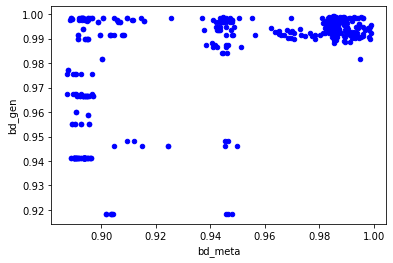

In [78]:
ax1 = diversity_df.plot.scatter(x='bd_meta',y='bd_gen',c='Blue')

## PS: also color this plot above with: 1) meta vs genome; 2) few BGCs vs many BGCs

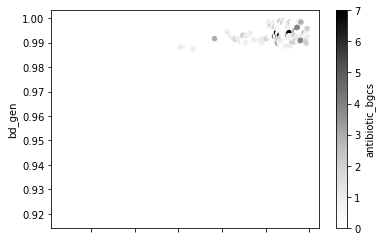

In [79]:
ax2 = diversity_df.plot.scatter(x='bd_meta',y='bd_gen',c='antibiotic_bgcs')

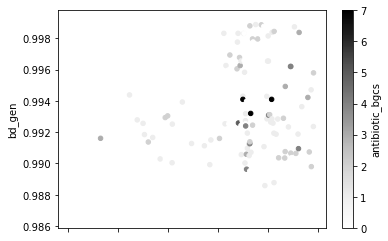

In [66]:
sub_diversity_df = diversity_df[diversity_df['bd_gen'] >= 0.985]
sub_diversity_df = sub_diversity_df[sub_diversity_df['bd_meta'] >= 0.95]

ax3 = sub_diversity_df.plot.scatter(x='bd_meta',y='bd_gen',c='antibiotic_bgcs')

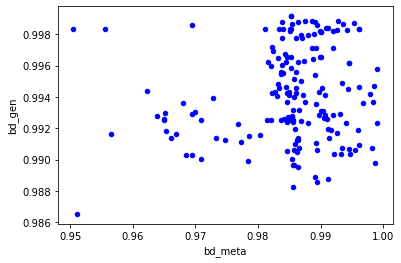

In [67]:
ax3 = sub_diversity_df.plot.scatter(x='bd_meta',y='bd_gen',c='Blue')

In [49]:
diversity_df.sort_values(by='antibiotic_bgcs',ascending=False)[:17]

,strain,bd_meta,bd_gen,antibiotic_bgcs
357,2518285535,0.990708,0.994098,7
321,GCA_000156695,0.986527,0.993199,7
287,GCA_000377965,0.984976,0.994098,7
275,GCA_000203835,0.984082,0.992585,5
390,2518285564,0.996068,0.990947,4
353,GCA_000702365,0.990097,0.993089,4
318,2517572165,0.986358,0.991267,4
306,GCA_000415505,0.985722,0.989631,4
381,2845467531,0.994472,0.996201,4
301,GCA_000739105,0.985520,0.992397,4


In [50]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
run_time = "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
print(run_time)

01:37:20.39
